## Optimize signal function for magnetic field in tungsten wheel 

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import corner
from datetime import datetime
now = datetime.now

In [2]:
# We want to optimise using PTMCMC
from PTMCMCSampler.PTMCMCSampler import PTMCMCSampler

Do not have mpi4py package.


In [3]:
# chi2 function as likelihood
from scripts_magnetic_field_calculation import chi2_one_exp_one_freq

### Load data and set-up physical parameters

Do not edit this cell

In [4]:
# Directory for saved plots
SaveDir = 'PythonFigs/FitFigs/Exp2_new_dir/Single_freqs/'

In [5]:
rtr_dims  = {'height':10,'outer_radius':18.9,'inner_radius':15,'hole_radius':2.5,'bar_width':7} # mm

sampling_factor = 100
f_sample = 500

dat = loadmat('data_2019-03-05.mat')
Time1 = np.array(dat['Time1'])
Time0 = np.array(dat['Time0'])
XCh0  = np.array(dat['ZCh0'])
XCh1  = np.array(dat['ZCh1'])
YCh0  = np.array(dat['YCh0'])
YCh1  = np.array(dat['YCh1'])

D_wheel_sensor = 10
Exp1_sensor_loc = {'coordinate':'cartesian','location':-np.array([rtr_dims['outer_radius']+D_wheel_sensor,0,0])}

Exp1_Freq       = [0.1,5  ,  3]
Exp1_Start_Time = [300,220,189]
Exp1_Stop_Time  = [330,220.5,190]

# Exp1_Freq       = [0.1,3,5]
# Exp1_Start_Time = [300,189,220]
# Exp1_Stop_Time  = [330,190,220.5]

Exp1A_Freq       = [0.5,  1,0.1]
Exp1A_Start_Time = [ 40, 97,  1]
Exp1A_Stop_Time  = [ 50,100, 28]

Exp1_Time_cut = {}
Exp1_X_cut    = {}
Exp1_Y_cut    = {}
Exp1A_Time_cut = {}
Exp1A_X_cut    = {}
Exp1A_Y_cut    = {}
# f_new_sample = {0.1:10,3:300,5:500,0.5:50}
# f_old_sample = 500
arraybool = {}
loop_theta = 0
loop_time =0
for  ii in range(len(Exp1_Freq)):
#    loop_nu            = Freq[ii]
    key           = Exp1_Freq[ii]
    f_new_sample = sampling_factor*key
    n_skips = int(np.ceil(f_sample/f_new_sample))
    arraybool = (Time1>Exp1_Start_Time[ii] )& (Time1<Exp1_Stop_Time[ii])
    Time_Full_Sample = Time1[arraybool]-Exp1_Start_Time[ii] + loop_time
    if ii < len(Exp1_Freq)-1:
        loop_theta += (Exp1_Stop_Time[ii]- Exp1_Start_Time[ii])*Exp1_Freq[ii]
        loop_time = loop_theta/Exp1_Freq[ii+1]
    new_indices = (np.arange(0,len(Time_Full_Sample),n_skips))
    Exp1_Time_cut[key] = Time_Full_Sample[new_indices]
    X_Full_Sample = 1e-12*XCh1[arraybool]
    Y_Full_Sample = 1e-12*YCh1[arraybool]
    Exp1_X_cut[key]         = X_Full_Sample[new_indices]
    Exp1_Y_cut[key]         = Y_Full_Sample[new_indices]

loop_theta = 0
loop_time =0
for  ii in range(len(Exp1A_Freq)):
#    loop_nu            = Freq[ii]
    key           = Exp1A_Freq[ii]
    f_new_sample = sampling_factor*key
    n_skips = int(np.ceil(f_sample/f_new_sample))
    arraybool = ((Time1>Exp1A_Start_Time[ii] )& (Time1<Exp1A_Stop_Time[ii]))
    Time_Full_Sample = Time1[arraybool] - Exp1A_Start_Time[ii] + loop_time
    if ii < len(Exp1A_Freq)-1:
        loop_theta += (Exp1A_Stop_Time[ii]- Exp1A_Start_Time[ii])*Exp1A_Freq[ii]
        loop_time = loop_theta/Exp1A_Freq[ii+1]
    new_indices = (np.arange(0,len(Time_Full_Sample),n_skips))
    X_Full_Sample = 1e-12*XCh1[arraybool]
    Y_Full_Sample = 1e-12*YCh1[arraybool]
    Exp1A_Time_cut[key] = Time_Full_Sample[new_indices]
    Exp1A_X_cut[key]         = X_Full_Sample[new_indices]
    Exp1A_Y_cut[key]         = Y_Full_Sample[new_indices]

### Experiment 1 (5Hz)

[18, 0, 2, -18, 18, 0, 18, 280, 4.5, 10, 0, 0, -5.26983047, 37.6604069]
0.01864656629395843


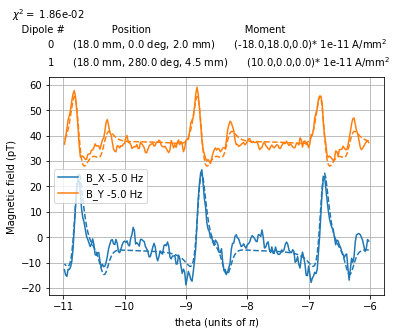

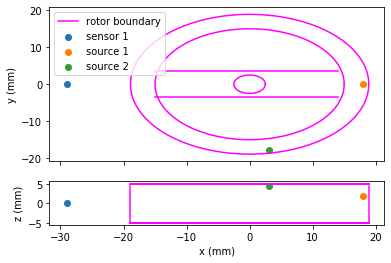

In [6]:
nu = 5
nowtext = now().strftime("%Y%m%d%H%M")
Opt_Settings_Exp1_5Hz = {'number of sources': 2,
                'location coordinate system': 'polar',
                'moment coordinate system':'polar',
                'location dimensions': 3,
                'moment dimensions': 3,
                'rotation sign':-1, # 1 for positive, -1 for negative, 0 for unknown and making it a free parameter
                'rotation frequency':nu,
                'rotor dimensions':rtr_dims,
                'time':Exp1_Time_cut[nu],
                'number of sensors':1,
                'sensor locations':[Exp1_sensor_loc],
                'sensor field order':[[0,1]],# list which order of B component of each sensor (0 for x, 1 for y, 2 for z) 
                'B data':[Exp1_X_cut[nu],Exp1_Y_cut[nu]],
                'bar location':320,
                'plot':1,
                'saveplot':0,
                'plotlabels':['B_X','B_Y'],
                'figname':SaveDir+'Exp1_5Hz_2src_'+nowtext+'_0'
                         
}

Opt_Params_Exp1_5Hz = [   18, 0,  2, -18,18, 0,

                        18, 280, 4.5, 10, 0 ,0,
       -5.26983047e+00,  3.76604069e+01]

chi_Exp1_5Hz = chi2_one_exp_one_freq(Opt_Params_Exp1_5Hz,Opt_Settings_Exp1_5Hz)

### Defining likelihood function

Either use chi squared distribution:
$$
\chi^2 = \sum^n_{i=1}\frac{(O_i-E_i)^2}{E_i}
$$

Or take difference between chi squared and true signal to construct a Gaussian likelihood:
$$
\mathcal{N} = \frac{1}{\sqrt{2\pi}}\exp{-\frac{(x-\mu)^2}{2\sigma^2}}, \\
\rm{where} \quad \mu = 0 \quad \rm{and} \quad x = \chi^2 - \rm{signal}
$$

In [7]:
class GaussianLikelihood(object):
    
    def __init__(self, ndim=2, pmin=-10, pmax=10):
        
        self.a = np.ones(ndim)*pmin
        self.b = np.ones(ndim)*pmax
        
        # get means
#         self.mu = np.random.uniform(pmin, pmax, ndim)
        self.mu = Opt_Settings_Exp1_5Hz['B data'][0]

        # ... and a positive definite, non-trivial covariance matrix.
        cov  = 0.5-np.random.rand(ndim**2).reshape((ndim, ndim))
        cov  = np.triu(cov)
        cov += cov.T - np.diag(cov.diagonal())
        self.cov  = np.dot(cov,cov)

        # Invert the covariance matrix first.
        self.icov = np.linalg.inv(self.cov)
        
    def lnlikefn(self, x):
        model = chi2_one_exp_one_freq(x, Opt_Settings_Exp1_5Hz)
        diff = model - self.mu
        return -np.dot(diff,np.dot(self.icov, diff))/2.0
    
    def lnpriorfn(self, x):
        
        if np.all(self.a <= x) and np.all(self.b >= x):
            return 0.0
        else:
            return -np.inf

### Run sampler

In [8]:
ndim = len(Opt_Params_Exp1_5Hz)
pmin= Opt_Settings_Exp1_5Hz['B data'][0].min()
pmax=Opt_Settings_Exp1_5Hz['B data'][0].max()

Opt_Settings_Exp1_5Hz['plot'] = 0
glo = GaussianLikelihood(ndim=ndim, pmin = pmin, pmax = pmax)

In [9]:
p0 = np.array(Opt_Params_Exp1_5Hz)
cov = np.eye(ndim)*0.1**2

In [17]:
sampler = PTMCMCSampler.PTSampler(ndim, glo.lnlikefn, glo.lnpriorfn, np.copy(cov), outDir='./chains')

In [18]:
sampler.sample(p0, 60000, burn=500, thin=1, covUpdate=500,
               SCAMweight=10, AMweight=10, DEweight=10)

0.1039213163888911
1.0
0.011546812932099006
0.1039213163888911
0.1039213163888911
1.0
0.1039213163888911
1.6165538104938608
0.025980329097222775
0.057734064660495014
1.0
1.0
0.030424873310482697
0.21742883671051533
0.14696448550585273
1.0
0.016329387278428083
0.14696448550585273
0.14696448550585273
1.0
0.14696448550585273
2.286114218979931
0.03674112137646318
0.08164693639214035
1.0
1.0
0.043026551318145353
0.3074856846666427
0.2649241212120936
1.0
0.02943601346801039
0.2649241212120936
0.2649241212120936
1.0
0.2649241212120936
4.121041885521453
0.0662310303030234
0.14718006734005193
1.0
1.0
0.07756140034452576
0.5542861223595754
0.33669022854843894
1.0
0.03741002539427098
0.33669022854843894
0.33669022854843894
1.0
0.33669022854843894
5.237403555197936
0.08417255713710974
0.1870501269713549
1.0
1.0
0.0985722458531015
0.7044383892437892
0.34461056280967367
1.0
0.038290062534408184
0.34461056280967367
0.34461056280967367
1.0
0.34461056280967367
5.360608754817143
0.08615264070241842
0.19

1.0
1.0
0.29374060829015985
2.099192923612386
1.013960901613075
1.0
0.1126623224014528
1.013960901613075
1.013960901613075
1.0
1.013960901613075
15.772725136203388
0.25349022540326877
0.5633116120072639
1.0
1.0
0.2968556697060697
2.1214544519688476
1.0218672907966084
1.0
0.11354081008851202
1.0218672907966084
1.0218672907966084
1.0
1.0218672907966084
15.895713412391684
0.2554668226991521
0.5677040504425601
1.0
1.0
0.29917041029646196
2.1379965538444945
1.0297121879437963
1.0
0.1144124653270885
1.0297121879437963
1.0297121879437963
1.0
1.0297121879437963
16.017745145792386
0.25742804698594907
0.5720623266354425
1.0
1.0
0.30146714796425467
2.154409999325147
1.037496987947435
1.0
0.11527744310527055
1.037496987947435
1.037496987947435
1.0
1.037496987947435
16.13884203473788
0.25937424698685874
0.5763872155263529
1.0
1.0
0.3037462910899231
2.1706977068680433
1.0400787998993148
1.0
0.11556431109992396
1.0400787998993148
1.0400787998993148
1.0
1.0400787998993148
16.179003553989354
0.26001969

3.113755759346716
1.506020049667334
1.0
0.1673355610741482
1.506020049667334
1.506020049667334
1.0
1.506020049667334
23.426978550380756
0.3765050124168335
0.8366778053707414
1.0
1.0
0.4409150192315462
3.150962659446112
1.5148311589084769
1.0
0.16831457321205304
1.5148311589084769
1.5148311589084769
1.0
1.5148311589084769
23.564040249687416
0.3787077897271192
0.841572866060265
1.0
1.0
0.44349463322896143
3.169397657182878
1.5165870598155589
1.0
0.16850967331283984
1.5165870598155589
1.5165870598155589
1.0
1.5165870598155589
23.59135426379757
0.3791467649538897
0.842548366564199
1.0
1.0
0.4440087054568745
3.1730714317738102
1.5288202510432678
1.0
0.16986891678258528
1.5288202510432678
1.5288202510432678
1.0
1.5288202510432678
23.781648349561948
0.38220506276081695
0.8493445839129264
1.0
1.0
0.4475901967833812
3.1986662628472
1.5461233974039719
1.0
0.1717914886004413
1.5461233974039719
1.5461233974039719
1.0
1.5461233974039719
24.05080840406179
0.38653084935099297
0.8589574430022064
1.0
1

28.962973688640627
0.4654763628531527
1.0343919174514504
1.0
1.0
0.545107004450738
3.895562050529284
1.8703977518164416
1.0
0.20782197242404907
1.8703977518164416
1.8703977518164416
1.0
1.8703977518164416
29.095076139366878
0.4675994379541104
1.0391098621202457
1.0
1.0
0.5475932813078767
3.913330022125135
1.8732195786933252
1.0
0.20813550874370285
1.8732195786933252
1.8732195786933252
1.0
1.8732195786933252
29.1389712241184
0.4683048946733313
1.040677543718514
1.0
1.0
0.5484194229332583
3.919233974813177
1.877444007154408
1.0
0.20860488968382304
1.877444007154408
1.877444007154408
1.0
1.877444007154408
29.20468455573523
0.469361001788602
1.0430244484191158
1.0
1.0
0.5496562019233995
3.928072513411195
1.9177786916117299
1.0
0.21308652129019232
1.9177786916117299
1.9177786916117299
1.0
1.9177786916117299
29.832112980626917
0.47944467290293247
1.065432606450961
1.0
1.0
0.5614649213206793
4.012462548347076
1.9342114439740037
1.0
0.21491238266377824
1.9342114439740037
1.9342114439740037
1.0

2.317892801662752
2.317892801662752
1.0
2.317892801662752
36.05611024808725
0.579473200415688
1.2877182231459734
1.0
1.0
0.6786056729108909
4.849599225622236
2.329119241258377
1.0
0.25879102680648647
2.329119241258377
2.329119241258377
1.0
2.329119241258377
36.23074375290809
0.5822798103145943
1.2939551340324318
1.0
1.0
0.6818924192137046
4.873087685800542
2.336943369018599
1.0
0.25966037433539985
2.336943369018599
2.336943369018599
1.0
2.336943369018599
36.35245240695597
0.5842358422546498
1.2983018716769996
1.0
1.0
0.6841830762621481
4.889457676638739
2.3547224358722194
1.0
0.26163582620802445
2.3547224358722194
2.3547224358722194
1.0
2.3547224358722194
36.62901566912342
0.5886806089680549
1.3081791310401223
1.0
1.0
0.6893882244973356
4.926655837305942
2.3569347021078038
1.0
0.26188163356753374
2.3569347021078038
2.3569347021078038
1.0
2.3569347021078038
36.66342869945471
0.5892336755269509
1.3094081678376686
1.0
1.0
0.6900359060537821
4.931284439895007
2.3580399996607353
1.0
0.26200

0.28776850070846893
2.5899165063762193
2.5899165063762193
1.0
2.5899165063762193
40.28759009918563
0.6474791265940548
1.4388425035423438
1.0
1.0
0.7582456066698529
5.418739414841937
2.595899410608971
1.0
0.28843326784544115
2.595899410608971
2.595899410608971
1.0
2.595899410608971
40.380657498361764
0.6489748526522428
1.4421663392272055
1.0
1.0
0.7599972117267884
5.431257115278002
2.6048456691328186
1.0
0.2894272965703132
2.6048456691328186
2.6048456691328186
1.0
2.6048456691328186
40.51982151984384
0.6512114172832046
1.4471364828515654
1.0
1.0
0.7626163931579818
5.449974878402484
2.6068291773723877
1.0
0.2896476863747096
2.6068291773723877
2.6068291773723877
1.0
2.6068291773723877
40.55067609245937
0.6517072943430969
1.4482384318735488
1.0
1.0
0.7631971016112249
5.4541248632575785
2.6088110395350603
1.0
0.2898678932816734
2.6088110395350603
2.6088110395350603
1.0
2.6088110395350603
40.58150505943426
0.6522027598837651
1.4493394664083668
1.0
1.0
0.763777328145235
5.458271404116798
2.60

1.0
0.8181953290359232
5.847165139483559
2.7992725912279433
1.0
0.3110302879142159
2.7992725912279433
2.7992725912279433
1.0
2.7992725912279433
43.544240307990215
0.6998181478069858
1.555151439571079
1.0
1.0
0.8195384441716036
5.85676360053676
2.803851920127024
1.0
0.3115391022363359
2.803851920127024
2.803851920127024
1.0
2.803851920127024
43.615474313087056
0.700962980031756
1.5576955111816804
1.0
1.0
0.8208791267807443
5.866344677740556
2.806595546208965
1.0
0.3118439495787738
2.806595546208965
2.806595546208965
1.0
2.806595546208965
43.65815294102834
0.7016488865522412
1.55921974789387
1.0
1.0
0.8216823736876833
5.872085015219854
2.808422980962804
1.0
0.312046997884756
2.808422980962804
2.808422980962804
1.0
2.808422980962804
43.68657970386584
0.702105745240701
1.56023498942378
1.0
1.0
0.8222173887625562
5.875908456131674
2.8184504093561764
1.0
0.3131611565951308
2.8184504093561764
2.8184504093561764
1.0
2.8184504093561764
43.842561923318314
0.7046126023390441
1.5658057829756544
1.

2.9496934739053824
1.0
0.3277437193228203
2.9496934739053824
2.9496934739053824
1.0
2.9496934739053824
45.88412070519484
0.7374233684763456
1.6387185966141016
1.0
1.0
0.8635769192192625
6.171480914308401
2.952286571456098
1.0
0.32803184127289986
2.952286571456098
2.952286571456098
1.0
2.952286571456098
45.92445777820597
0.7380716428640245
1.6401592063644987
1.0
1.0
0.8643360961350652
6.176906309246808
2.9566027379409623
1.0
0.32851141532677375
2.9566027379409623
2.9566027379409623
1.0
2.9566027379409623
45.99159814574832
0.7391506844852406
1.6425570766338682
1.0
1.0
0.8655997331159289
6.185936786250595
2.9677918458005106
1.0
0.32975464953338995
2.9677918458005106
2.9677918458005106
1.0
2.9677918458005106
46.1656509346746
0.7419479614501276
1.64877324766695
1.0
1.0
0.8688755498676151
6.209347139297183
2.97036723487181
1.0
0.3300408038746455
2.97036723487181
2.97036723487181
1.0
2.97036723487181
46.20571254245038
0.7425918087179525
1.6502040193732275
1.0
1.0
0.8696295423009504
6.21473548

3.143964217353626
1.0
0.34932935748373634
3.143964217353626
3.143964217353626
1.0
3.143964217353626
48.90611004772306
0.7859910543384065
1.7466467874186813
1.0
1.0
0.9204532460666576
6.577942872476536
3.1487881097336494
1.0
0.349865345525961
3.1487881097336494
3.1487881097336494
1.0
3.1487881097336494
48.98114837363452
0.7871970274334124
1.749326727629804
1.0
1.0
0.9218655291248932
6.58803563635839
3.150394203905282
1.0
0.3500438004339203
3.150394203905282
3.150394203905282
1.0
3.150394203905282
49.006132060748854
0.7875985509763205
1.7502190021696018
1.0
1.0
0.9223357426806359
6.591395978581917
3.1536035958883604
1.0
0.3504003995431512
3.1536035958883604
3.1536035958883604
1.0
3.1536035958883604
49.056055936041176
0.7884008989720901
1.7520019977157557
1.0
1.0
0.9232753511063362
6.598110812358823
3.1560081986585513
1.0
0.3506675776287281
3.1560081986585513
3.1560081986585513
1.0
3.1560081986585513
49.09346086802193
0.7890020496646378
1.7533378881436406
1.0
1.0
0.9239793427144803
6.6031

1.8310360151807195
1.0
1.0
0.9649249384466742
6.895756138026046
3.298150813713648
1.0
0.3664612015237386
3.298150813713648
3.298150813713648
1.0
3.298150813713648
51.30456821332342
0.824537703428412
1.8323060076186937
1.0
1.0
0.9655942029313044
6.900538981223448
3.300434971333324
1.0
0.3667149968148138
3.300434971333324
3.300434971333324
1.0
3.300434971333324
51.34009955407391
0.825108742833331
1.8335749840740694
1.0
1.0
0.9662629320103292
6.9053179981890445
3.3027173039786497
1.0
0.36696858933096105
3.3027173039786497
3.3027173039786497
1.0
3.3027173039786497
51.375602506334545
0.8256793259946624
1.834842946654805
1.0
1.0
0.9669311267946077
6.910093196861497
3.3049978154304434
1.0
0.3672219794922714
3.3049978154304434
3.3049978154304434
1.0
3.3049978154304434
51.41107712891798
0.8262494538576108
1.8361098974613566
1.0
1.0
0.9675987883910435
6.914864585151197
3.3057575818562372
1.0
0.36730639798402637
3.3057575818562372
3.3057575818562372
1.0
3.3057575818562372
51.4228957177637
0.82643

53.89437465594676
0.8661595926848585
1.924799094855241
1.0
1.0
1.0143364918696571
7.248871711300007
3.467513945177439
1.0
0.3852793272419376
3.467513945177439
3.467513945177439
1.0
3.467513945177439
53.93910581387126
0.8668784862943597
1.926396636209688
1.0
1.0
1.0151783690803315
7.2548881170448105
3.4682324013825827
1.0
0.38535915570917606
3.4682324013825827
3.4682324013825827
1.0
3.4682324013825827
53.950281799284625
0.8670581003456457
1.9267957785458798
1.0
1.0
1.0153887103248447
7.256391303324014
3.4711044798449957
1.0
0.38567827553833267
3.4711044798449957
3.4711044798449957
1.0
3.4711044798449957
53.99495857536661
0.8677761199612489
1.9283913776916646
1.0
1.0
1.0162295640244814
7.262400394631966
3.4768402767455404
1.0
0.3863155863050598
3.4768402767455404
3.4768402767455404
1.0
3.4768402767455404
54.0841820827084
0.8692100691863851
1.9315779315252997
1.0
1.0
1.0179088238731597
7.27440108603031
3.477556469706854
1.0
0.3863951633007616
3.477556469706854
3.477556469706854
1.0
3.4775

3.6344845232852485
1.0
0.4038316136983611
3.6344845232852485
3.6344845232852485
1.0
3.6344845232852485
56.53642591777053
0.9086211308213121
2.0191580684918042
1.0
1.0
1.064062071308446
7.6042314454819415
3.6365226852035453
1.0
0.40405807613372724
3.6365226852035453
3.6365226852035453
1.0
3.6365226852035453
56.56813065872182
0.9091306713008863
2.020290380668636
1.0
1.0
1.0646587806295473
7.608495779213672
3.637880701727311
1.0
0.4042089668585903
3.637880701727311
3.637880701727311
1.0
3.637880701727311
56.589255360202635
0.9094701754318277
2.021044834292951
1.0
1.0
1.0650563648993092
7.611337082261563
3.639916591077327
1.0
0.4044351767863698
3.639916591077327
3.639916591077327
1.0
3.639916591077327
56.62092475009178
0.9099791477693318
2.0221758839318493
1.0
1.0
1.0656524088843244
7.615596661224059
3.6460161052853293
1.0
0.40511290058725885
3.6460161052853293
3.6460161052853293
1.0
3.6460161052853293
56.71580608221625
0.9115040263213323
2.0255645029362936
1.0
1.0
1.0674381536524087
7.628

3.811424981552176
1.0
3.811424981552176
59.28883304636718
0.952856245388044
2.117458323084542
1.0
1.0
1.115864638994602
7.974434204115551
3.8133495984501615
1.0
0.4237055109389068
3.8133495984501615
3.8133495984501615
1.0
3.8133495984501615
59.318771531446934
0.9533373996125404
2.1185275546945332
1.0
1.0
1.1164281059263843
7.978460973865815
3.821036252118004
1.0
0.4245595835686671
3.821036252118004
3.821036252118004
1.0
3.821036252118004
59.43834169961338
0.955259063029501
2.122797917843335
1.0
1.0
1.1186785149103364
7.994543335245277
3.826150227055911
1.0
0.4251278030062122
3.826150227055911
3.826150227055911
1.0
3.826150227055911
59.517892420869714
0.9565375567639778
2.125639015031062
1.0
1.0
1.1201757249631479
8.0052430228585
3.8299802401579046
1.0
0.425553360017545
3.8299802401579046
3.8299802401579046
1.0
3.8299802401579046
59.57747040245629
0.9574950600394762
2.1277668000877243
1.0
1.0
1.1212970316156687
8.013256347961468
3.83826259523759
1.0
0.4264736216930656
3.83826259523759
3

1.0
3.960571311061071
61.60888706094996
0.9901428277652677
2.2003173950339274
1.0
1.0
1.1595299652020818
8.286484840612573
3.961183414082211
1.0
0.440131490453579
3.961183414082211
3.961183414082211
1.0
3.961183414082211
61.61840866350104
0.9902958535205527
2.2006574522678943
1.0
1.0
1.1597091695993924
8.287765509992623
3.962407268315564
1.0
0.4402674742572845
3.962407268315564
3.962407268315564
1.0
3.962407268315564
61.63744639601985
0.990601817078891
2.201337371286423
1.0
1.0
1.1600674753954896
8.29032611268231
3.9666870698354812
1.0
0.44074300775949793
3.9666870698354812
3.9666870698354812
1.0
3.9666870698354812
61.70402108632973
0.9916717674588703
2.20371503879749
1.0
1.0
1.1613204658652247
8.299280505276275
3.9740105674242985
1.0
0.4415567297138108
3.9740105674242985
3.9740105674242985
1.0
3.9740105674242985
61.81794215993355
0.9935026418560746
2.2077836485690545
1.0
1.0
1.1634645542396973
8.314603055227723
3.9801007009873497
1.0
0.4422334112208168
3.9801007009873497
3.98010070098

1.2053522742193876
8.61395017607512
4.119999689320378
1.0
0.45777774325781956
4.119999689320378
4.119999689320378
1.0
4.119999689320378
64.08888405609476
1.0299999223300944
2.288888716289098
1.0
1.0
1.2062055499539472
8.620048040426608
4.124657483961548
1.0
0.45829527599572745
4.124657483961548
4.124657483961548
1.0
4.124657483961548
64.16133863940186
1.031164370990387
2.2914763799786373
1.0
1.0
1.207569204849672
8.629793287173452
4.125820892864836
1.0
0.4584245436516486
4.125820892864836
4.125820892864836
1.0
4.125820892864836
64.17943611123079
1.031455223216209
2.2921227182582427
1.0
1.0
1.2079098141656512
8.632227423433948
4.126402441594857
1.0
0.4584891601772063
4.126402441594857
4.126402441594857
1.0
4.126402441594857
64.18848242480888
1.0316006103987143
2.292445800886031
1.0
1.0
1.2080800732332762
8.633444165756435
4.134533249352338
1.0
0.45939258326137083
4.134533249352338
4.134533249352338
1.0
4.134533249352338
64.3149616565919
1.0336333123380845
2.2969629163068546
1.0
1.0
1.21

4.28807604410183
4.28807604410183
1.0
4.28807604410183
66.70340513047292
1.0720190110254575
2.382264468945461
1.0
1.0
1.2554129886047163
8.971704924389849
4.290842843777897
1.0
0.47676031597532204
4.290842843777897
4.290842843777897
1.0
4.290842843777897
66.74644423654507
1.0727107109444742
2.3838015798766103
1.0
1.0
1.2562230200067899
8.977493746701597
4.293054622294015
1.0
0.47700606914377947
4.293054622294015
4.293054622294015
1.0
4.293054622294015
66.78084968012912
1.0732636555735038
2.385030345718897
1.0
1.0
1.2568705587744073
8.982121328862132
4.295817272650223
1.0
0.4773130302944692
4.295817272650223
4.295817272650223
1.0
4.295817272650223
66.82382424122568
1.0739543181625557
2.386565151472346
1.0
1.0
1.2576793753869133
8.987901469780867
4.298025737475288
1.0
0.477558415275032
4.298025737475288
4.298025737475288
1.0
4.298025737475288
66.8581781385045
1.074506434368822
2.3877920763751597
1.0
1.0
1.2583259440106385
8.99252211888844
4.312894562819732
1.0
0.47921050697997003
4.31289

9.293118987989775
4.442226323590458
1.0
0.4935807026211621
4.442226323590458
4.442226323590458
1.0
4.442226323590458
69.10129836696267
1.1105565808976146
2.467903513105811
1.0
1.0
1.300543313038504
9.29422504935043
4.449618679167914
1.0
0.4944020754631015
4.449618679167914
4.449618679167914
1.0
4.449618679167914
69.21629056483418
1.1124046697919785
2.4720103773155078
1.0
1.0
1.3027075608533454
9.309691667072451
4.450146082995479
1.0
0.49446067588838655
4.450146082995479
4.450146082995479
1.0
4.450146082995479
69.2244946243741
1.1125365207488698
2.472303379441932
1.0
1.0
1.3028619680067068
9.310795125002828
4.458047230570801
1.0
0.49533858117453355
4.458047230570801
4.458047230570801
1.0
4.458047230570801
69.34740136443469
1.1145118076427003
2.4766929058726683
1.0
1.0
1.3051751740200623
9.327326260150807
4.459099316005418
1.0
0.4954554795561579
4.459099316005418
4.459099316005418
1.0
4.459099316005418
69.36376713786208
1.1147748290013546
2.4772773977807887
1.0
1.0
1.3054831913467508
9.3

1.1430905475945463
2.54020121687677
1.0
1.0
1.3386429772628279
9.56650114354543
4.574396065056019
1.0
0.5082662294506689
4.574396065056019
4.574396065056019
1.0
4.574396065056019
71.15727212309363
1.1435990162640048
2.541331147253345
1.0
1.0
1.339238431415573
9.570756507320475
4.574904343262272
1.0
0.5083227048069191
4.574904343262272
4.574904343262272
1.0
4.574904343262272
71.16517867296871
1.143726085815568
2.541613524034596
1.0
1.0
1.3393872391921589
9.571819949768582
4.587586620435628
1.0
0.50973184671507
4.587586620435628
4.587586620435628
1.0
4.587586620435628
71.36245854010977
1.146896655108907
2.548659233575349
1.0
1.0
1.3431002086742228
9.598354378588981
4.588599158784739
1.0
0.5098443509760818
4.588599158784739
4.588599158784739
1.0
4.588599158784739
71.37820913665149
1.1471497896961846
2.5492217548804104
1.0
1.0
1.343396647865565
9.60047285671283
4.589611395314423
1.0
0.5099568217016025
4.589611395314423
4.589611395314423
1.0
4.589611395314423
71.39395503822433
1.14740284882

1.0
4.692782533849188
72.9988394154318
1.173195633462297
2.6071014076939925
1.0
1.0
1.3738982436645697
9.818449984331858
4.694745759889454
1.0
0.521638417765495
4.694745759889454
4.694745759889454
1.0
4.694745759889454
73.0293784871693
1.1736864399723634
2.608192088827474
1.0
1.0
1.3744730141315966
9.82255753386036
4.696707858702732
1.0
0.5218564287447479
4.696707858702732
4.696707858702732
1.0
4.696707858702732
73.05990002426469
1.174176964675683
2.6092821437237403
1.0
1.0
1.3750474545822282
9.826662724954032
4.703566347995955
1.0
0.5226184831106616
4.703566347995955
4.703566347995955
1.0
4.703566347995955
73.16658763549263
1.1758915869989888
2.6130924155533077
1.0
1.0
1.3770554032408722
9.841012363704147
4.704545009881403
1.0
0.5227272233201558
4.704545009881403
4.704545009881403
1.0
4.704545009881403
73.18181126482182
1.1761362524703507
2.6136361166007784
1.0
1.0
1.3773419244755256
9.843059963972118
4.705523391717439
1.0
0.5228359324130488
4.705523391717439
4.705523391717439
1.0
4.7

1.0
1.4079530001508118
10.061819480457658
4.810051326129484
1.0
0.5344501473477203
4.810051326129484
4.810051326129484
1.0
4.810051326129484
74.82302062868082
1.202512831532371
2.672250736738601
1.0
1.0
1.4082308355945032
10.063805008440053
4.813370743044836
1.0
0.5348189714494264
4.813370743044836
4.813370743044836
1.0
4.813370743044836
74.87465600291969
1.203342685761209
2.674094857247131
1.0
1.0
1.4092026558391233
10.070750041312436
4.813844683826016
1.0
0.5348716315362241
4.813844683826016
4.813844683826016
1.0
4.813844683826016
74.88202841507136
1.203461170956504
2.6743581576811195
1.0
1.0
1.4093414107041033
10.071741641460534
4.815266114141563
1.0
0.5350295682379518
4.815266114141563
4.815266114141563
1.0
4.815266114141563
74.9041395533132
1.2038165285353908
2.6751478411897582
1.0
1.0
1.4097575605256503
10.074715621686284
4.8162134078547645
1.0
0.5351348230949738
4.8162134078547645
4.8162134078547645
1.0
4.8162134078547645
74.91887523329633
1.2040533519636911
2.6756741154748696
1

4.932160252870946
1.0
0.5480178058745495
4.932160252870946
4.932160252870946
1.0
4.932160252870946
76.72249282243693
1.2330400632177365
2.740089029372748
1.0
1.0
1.4439804657501227
10.319286778840373
4.933991386291629
1.0
0.5482212651435142
4.933991386291629
4.933991386291629
1.0
4.933991386291629
76.750977120092
1.2334978465729072
2.7411063257175723
1.0
1.0
1.4445165636776203
10.32311795826877
4.93582154863808
1.0
0.5484246165153418
4.93582154863808
4.93582154863808
1.0
4.93582154863808
76.77944631214787
1.23395538715952
2.7421230825767102
1.0
1.0
1.4450523773053072
10.326947105972119
4.93765074099009
1.0
0.5486278601100102
4.93765074099009
4.93765074099009
1.0
4.93765074099009
76.80790041540142
1.2344126852475226
2.7431393005500504
1.0
1.0
1.4455879069493145
10.330774224209632
4.940392713135263
1.0
0.548932523681696
4.940392713135263
4.940392713135263
1.0
4.940392713135263
76.85055331543742
1.2350981782838157
2.744662618408479
1.0
1.0
1.4463906696358986
10.336511101248275
4.943132508

5.092757578169218
1.0
0.5658619531299132
5.092757578169218
5.092757578169218
1.0
5.092757578169218
79.22067343818784
1.2731893945423045
2.8293097656495663
1.0
1.0
1.4909982812088636
10.655295702050628
5.093631709301331
1.0
0.5659590788112588
5.093631709301331
5.093631709301331
1.0
5.093631709301331
79.23427103357626
1.2734079273253327
2.8297953940562945
1.0
1.0
1.4912541991463517
10.65712459839059
5.09668943138583
1.0
0.5662988257095363
5.09668943138583
5.09668943138583
1.0
5.09668943138583
79.28183559933511
1.2741723578464574
2.8314941285476825
1.0
1.0
1.4921494034246674
10.663522101606661
5.100180667388167
1.0
0.5666867408209073
5.100180667388167
5.100180667388167
1.0
5.100180667388167
79.33614371492705
1.2750451668470417
2.8334337041045368
1.0
1.0
1.4931715268615053
10.670826622075106
5.10366838656275
1.0
0.5670742651736387
5.10366838656275
5.10366838656275
1.0
5.10366838656275
79.39039712430942
1.2759170966406874
2.835371325868193
1.0
1.0
1.4941926206824505
10.678123784478863
5.104

5.232405250933838
1.0
0.5813783612148707
5.232405250933838
5.232405250933838
1.0
5.232405250933838
81.39297057008193
1.3081013127334595
2.9068918060743543
1.0
1.0
1.531882701264396
10.947472823103606
5.232825072558799
1.0
0.5814250080620887
5.232825072558799
5.232825072558799
1.0
5.232825072558799
81.39950112869239
1.3082062681396998
2.907125040310443
1.0
1.0
1.532005611752795
10.948351192727024
5.239116298575553
1.0
0.5821240331750616
5.239116298575553
5.239116298575553
1.0
5.239116298575553
81.49736464450858
1.3097790746438882
2.910620165875307
1.0
1.0
1.5338474836726146
10.961513977820957
5.239535307639409
1.0
0.5821705897377121
5.239535307639409
5.239535307639409
1.0
5.239535307639409
81.50388256327969
1.3098838269098523
2.910852948688561
1.0
1.0
1.5339701562688326
10.962390647367602
5.245396118502398
1.0
0.5828217909447106
5.245396118502398
5.245396118502398
1.0
5.245396118502398
81.59505073225948
1.3113490296255994
2.9141089547235537
1.0
1.0
1.5356860162502026
10.974652898582269


5.337844654914565
5.337844654914565
1.0
5.337844654914565
83.03313907644879
1.3344611637286412
2.965469252730314
1.0
1.0
1.5627520225886338
11.16807787072626
5.3415080033638445
1.0
0.5935008892626492
5.3415080033638445
5.3415080033638445
1.0
5.3415080033638445
83.09012449677091
1.3353770008409611
2.967504446313246
1.0
1.0
1.5638245351042026
11.175742492571604
5.345980168313384
1.0
0.5939977964792649
5.345980168313384
5.345980168313384
1.0
5.345980168313384
83.15969150709708
1.336495042078346
2.9699889823963246
1.0
1.0
1.5651338434996438
11.185099356556256
5.35044655986769
1.0
0.5944940622075212
5.35044655986769
5.35044655986769
1.0
5.35044655986769
83.22916870905296
1.3376116399669224
2.972470311037606
1.0
1.0
1.5664414616276348
11.19444414118458
5.3557175989777495
1.0
0.5950797332197503
5.3557175989777495
5.3557175989777495
1.0
5.3557175989777495
83.311162650765
1.3389293997444374
2.9753986660987497
1.0
1.0
1.567984655100455
11.205472445499614
5.35693285285526
1.0
0.5952147614283624
5

3.0225338707779605
1.0
1.0
1.5928241088832735
11.382985544253
5.441351537991272
1.0
0.6045946153323635
5.441351537991272
5.441351537991272
1.0
5.441351537991272
84.64324614653091
1.360337884497818
3.0229730766618186
1.0
1.0
1.5930555629382095
11.384639611482898
5.44293213626626
1.0
0.604770237362918
5.44293213626626
5.44293213626626
1.0
5.44293213626626
84.66783323080851
1.360733034066565
3.023851186814589
1.0
1.0
1.593518312102119
11.387946610048532
5.447275053639205
1.0
0.6052527837376893
5.447275053639205
5.447275053639205
1.0
5.447275053639205
84.73538972327651
1.3618187634098013
3.026263918688447
1.0
1.0
1.594789780896598
11.397033056459541
5.448064088279433
1.0
0.6053404542532702
5.448064088279433
5.448064088279433
1.0
5.448064088279433
84.74766359545782
1.3620160220698583
3.026702271266352
1.0
1.0
1.5950207852737621
11.398683910104493
5.45633807970144
1.0
0.6062597866334934
5.45633807970144
5.45633807970144
1.0
5.45633807970144
84.87637012868908
1.36408451992536
3.03129893316746

1.0
0.6182264957117255
5.564038461405529
5.564038461405529
1.0
5.564038461405529
86.55170939964155
1.3910096153513822
3.0911324785586274
1.0
1.0
1.6289744122314873
11.641330692432343
5.56594500062658
1.0
0.6184383334029532
5.56594500062658
5.56594500062658
1.0
5.56594500062658
86.58136667641345
1.391486250156645
3.092191667014766
1.0
1.0
1.6295325865914507
11.645319639256538
5.567088416757902
1.0
0.618565379639767
5.567088416757902
5.567088416757902
1.0
5.567088416757902
86.59915314956736
1.3917721041894755
3.0928268981988345
1.0
1.0
1.6298673426563803
11.647711945743298
5.5678504829063105
1.0
0.6186500536562565
5.5678504829063105
5.5678504829063105
1.0
5.5678504829063105
86.6110075118759
1.3919626207265776
3.0932502682812815
1.0
1.0
1.6300904515124375
11.649306374700721
5.568231452624792
1.0
0.6186923836249771
5.568231452624792
5.568231452624792
1.0
5.568231452624792
86.61693370749676
1.392057863156198
3.093461918124884
1.0
1.0
1.630201987391916
11.650103456623764
5.570897058822755
1.

5.648057151800077
1.0
0.6275619057555641
5.648057151800077
5.648057151800077
1.0
5.648057151800077
87.85866680577898
1.4120142879500193
3.137809528777821
1.0
1.0
1.6535724263809695
11.817118362846998
5.651405191631547
1.0
0.627933910181283
5.651405191631547
5.651405191631547
1.0
5.651405191631547
87.91074742537961
1.4128512979078867
3.139669550906416
1.0
1.0
1.6545526265097839
11.824123281867584
5.652148756004216
1.0
0.6280165284449128
5.652148756004216
5.652148756004216
1.0
5.652148756004216
87.92231398228782
1.413037189001054
3.1400826422245647
1.0
1.0
1.6547703186313116
11.82567900058042
5.653263799788579
1.0
0.628140422198731
5.653263799788579
5.653263799788579
1.0
5.653263799788579
87.93965910782234
1.4133159499471448
3.1407021109936557
1.0
1.0
1.6550967681707682
11.828011945171001
5.654006960554612
1.0
0.628222995617179
5.654006960554612
5.654006960554612
1.0
5.654006960554612
87.95121938640509
1.413501740138653
3.141114978085895
1.0
1.0
1.6553143421290428
11.829566819439941
5.65

1.4333329548206863
3.1851843440459686
1.0
1.0
1.6785381508820414
11.995533844828081
5.735146379997636
1.0
0.6372384866664039
5.735146379997636
5.735146379997636
1.0
5.735146379997636
89.21338813329658
1.433786594999409
3.1861924333320206
1.0
1.0
1.679069396845652
11.999330350098502
5.739135014094023
1.0
0.637681668232669
5.739135014094023
5.739135014094023
1.0
5.739135014094023
89.27543355257366
1.4347837535235057
3.1884083411633455
1.0
1.0
1.680237142706476
12.007675549156561
5.744566542394649
1.0
0.638285171377183
5.744566542394649
5.744566542394649
1.0
5.744566542394649
89.35992399280565
1.4361416355986623
3.1914258568859144
1.0
1.0
1.6818273223363251
12.019039636150474
5.745651808976942
1.0
0.6384057565529934
5.745651808976942
5.745651808976942
1.0
5.745651808976942
89.37680591741909
1.4364129522442355
3.1920287827649676
1.0
1.0
1.682145054053183
12.021310279544037
5.748905534099513
1.0
0.6387672815666126
5.748905534099513
5.748905534099513
1.0
5.748905534099513
89.42741941932574
1

1.0
1.0
1.7153638075600837
12.258705349632631
5.861563763194938
1.0
0.6512848625772152
5.861563763194938
5.861563763194938
1.0
5.861563763194938
91.17988076081015
1.4653909407987344
3.2564243128860766
1.0
1.0
1.716080406729586
12.263826466234255
5.862961632997441
1.0
0.6514401814441598
5.862961632997441
5.862961632997441
1.0
5.862961632997441
91.2016254021824
1.4657404082493604
3.2572009072207995
1.0
1.0
1.716489658778381
12.266751152098443
5.867849622306283
1.0
0.6519832913673649
5.867849622306283
5.867849622306283
1.0
5.867849622306283
91.27766079143107
1.4669624055765706
3.259916456836825
1.0
1.0
1.7179207073893135
12.27697802244811
5.8692448909548816
1.0
0.6521383212172095
5.8692448909548816
5.8692448909548816
1.0
5.8692448909548816
91.29936497040931
1.4673112227387204
3.2606916060860467
1.0
1.0
1.7183291979025483
12.279897266061504
5.873775531972601
1.0
0.6526417257747331
5.873775531972601
5.873775531972601
1.0
5.873775531972601
91.36984160846266
1.4684438829931503
3.2632086288736

1.0
5.956680208807588
92.6594699147847
1.489170052201897
3.309266782670881
1.0
1.0
1.7439274924677886
12.462833357603929
5.958718317725717
1.0
0.6620798130806353
5.958718317725717
5.958718317725717
1.0
5.958718317725717
92.69117383128894
1.4896795794314293
3.310399065403176
1.0
1.0
1.7445241862721181
12.467097580446332
5.959736906944804
1.0
0.6621929896605336
5.959736906944804
5.959736906944804
1.0
5.959736906944804
92.7070185524747
1.489934226736201
3.3109649483026677
1.0
1.0
1.7448223969667376
12.469228718471594
5.960076367799327
1.0
0.6622307075332585
5.960076367799327
5.960076367799327
1.0
5.960076367799327
92.71229905465616
1.4900190919498317
3.3111535376662924
1.0
1.0
1.7449217803642116
12.4699389536887
5.960415794221073
1.0
0.662268421580119
5.960415794221073
5.960415794221073
1.0
5.960415794221073
92.71757902121664
1.4901039485552683
3.311342107900594
1.0
1.0
1.7450211536808584
12.470649116864012
5.9627908155493765
1.0
0.6625323128388196
5.9627908155493765
5.9627908155493765
1.

6.0544518488464325
1.0
6.0544518488464325
94.18036209316675
1.5136129622116081
3.363584360470241
1.0
1.0
1.7725519351221535
12.667395565778554
6.057420163733071
1.0
0.6730466848592305
6.057420163733071
6.057420163733071
1.0
6.057420163733071
94.22653588029225
1.5143550409332678
3.3652334242961515
1.0
1.0
1.7734209638018292
12.673606007247336
6.058079428333702
1.0
0.6731199364815227
6.058079428333702
6.058079428333702
1.0
6.058079428333702
94.23679110741317
1.5145198570834255
3.365599682407612
1.0
1.0
1.7736139756173956
12.674985350198147
6.0607151756207776
1.0
0.6734127972911977
6.0607151756207776
6.0607151756207776
1.0
6.0607151756207776
94.27779162076763
1.5151787939051944
3.367063986455989
1.0
1.0
1.7743856390265431
12.680499978826857
6.06269061061176
1.0
0.6736322900679735
6.06269061061176
6.06269061061176
1.0
6.06269061061176
94.30852060951628
1.51567265265294
3.368161450339868
1.0
1.0
1.7749639838880418
12.684633072469351
6.064664867904904
1.0
0.6738516519894338
6.064664867904904

6.134963325073753
95.43276283448058
1.5337408312684382
3.408312958374307
1.0
1.0
1.7961231479336768
12.835845285491914
6.1381818154890135
1.0
0.6820202017210016
6.1381818154890135
6.1381818154890135
1.0
6.1381818154890135
95.48282824094021
1.5345454538722534
3.4101010086050074
1.0
1.0
1.79706542009244
12.842579155416498
6.139468328772453
1.0
0.6821631476413835
6.139468328772453
6.139468328772453
1.0
6.139468328772453
95.50284066979366
1.5348670821931132
3.410815738206918
1.0
1.0
1.7974420704758356
12.845270856179635
6.140432882948887
1.0
0.6822703203276542
6.140432882948887
6.140432882948887
1.0
6.140432882948887
95.51784484587161
1.5351082207372218
3.4113516016382723
1.0
1.0
1.797724461419666
12.847288939666399
6.140754338027211
1.0
0.6823060375585789
6.140754338027211
6.140754338027211
1.0
6.140754338027211
95.52284525820102
1.5351885845068027
3.4115301877928945
1.0
1.0
1.7978185732955818
12.847961502391383
6.1420398435698855
1.0
0.6824488715077651
6.1420398435698855
6.14203984356988

6.213548196481621
1.0
0.6903942440535134
6.213548196481621
6.213548196481621
1.0
6.213548196481621
96.65519416749189
1.5533870491204052
3.4519712202675663
1.0
1.0
1.8191303118129105
13.00026407623661
6.215119599814632
1.0
0.6905688444238481
6.215119599814632
6.215119599814632
1.0
6.215119599814632
96.67963821933874
1.553779899953658
3.45284422211924
1.0
1.0
1.819590368988742
13.00355183673246
6.216062077392728
1.0
0.6906735641547475
6.216062077392728
6.216062077392728
1.0
6.216062077392728
96.69429898166464
1.554015519348182
3.4533678207737375
1.0
1.0
1.819866296603095
13.00552373057052
6.216690244012485
1.0
0.6907433604458315
6.216690244012485
6.216690244012485
1.0
6.216690244012485
96.70407046241642
1.5541725610031212
3.4537168022291587
1.0
1.0
1.820050203913818
13.006838008931693
6.217632266385654
1.0
0.6908480295984057
6.217632266385654
6.217632266385654
1.0
6.217632266385654
96.71872414377684
1.5544080665964135
3.45424014799203
1.0
1.0
1.8203259982585707
13.008808950369605
6.21857

6.277975673734329
1.0
0.6975528526371476
6.277975673734329
6.277975673734329
1.0
6.277975673734329
97.65739936920068
1.5694939184335823
3.4877642631857384
1.0
1.0
1.8379926386313303
13.135062132285356
6.279516120689555
1.0
0.6977240134099506
6.279516120689555
6.279516120689555
1.0
6.279516120689555
97.68136187739307
1.5698790301723888
3.488620067049754
1.0
1.0
1.8384436327592228
13.138285124459898
6.281055831625762
1.0
0.6978950924028624
6.281055831625762
6.281055831625762
1.0
6.281055831625762
97.70531293640074
1.5702639579064406
3.489475462014312
1.0
1.0
1.8388944114040353
13.141506576702445
6.282902513965977
1.0
0.698100279329553
6.282902513965977
6.282902513965977
1.0
6.282902513965977
97.73403910613743
1.5707256284914943
3.4905013966477654
1.0
1.0
1.8394350615631947
13.145370288277315
6.283210191454683
1.0
0.6981344657171872
6.283210191454683
6.283210191454683
1.0
6.283210191454683
97.73882520040618
1.5708025478636707
3.4906723285859353
1.0
1.0
1.8395251397968015
13.14601402491168

6.350493621758864
1.0
0.7056104024176515
6.350493621758864
6.350493621758864
1.0
6.350493621758864
98.7854563384712
1.587623405439716
3.5280520120882572
1.0
1.0
1.8592235993047503
13.286787433960749
6.351698478359941
1.0
0.7057442753733268
6.351698478359941
6.351698478359941
1.0
6.351698478359941
98.80419855226576
1.5879246195899852
3.528721376866634
1.0
1.0
1.859576343195214
13.28930828895257
6.355911893662467
1.0
0.706212432629163
6.355911893662467
6.355911893662467
1.0
6.355911893662467
98.8697405680828
1.5889779734156166
3.531062163145815
1.0
1.0
1.8608098978809926
13.298123785326558
6.35741533565332
1.0
0.7063794817392576
6.35741533565332
6.35741533565332
1.0
6.35741533565332
98.89312744349608
1.58935383391333
3.531897408696288
1.0
1.0
1.8612500581261744
13.30126935405578
6.357715938920204
1.0
0.7064128821022448
6.357715938920204
6.357715938920204
1.0
6.357715938920204
98.89780349431426
1.589428984730051
3.5320644105112247
1.0
1.0
1.8613380652514635
13.30189828968613
6.36432204087

Finished 15.00 percent in 60.574152 s Acceptance rate = 06.427873648415937
1.0
0.7142081831573263
6.427873648415937
6.427873648415937
1.0
6.427873648415937
99.98914564202568
1.6069684121039842
3.571040915786631
1.0
1.0
1.881878022762909
13.448685394507319
6.428167638604333
1.0
0.7142408487338149
6.428167638604333
6.428167638604333
1.0
6.428167638604333
99.99371882273405
1.6070419096510833
3.5712042436690736
1.0
1.0
1.8819640937880584
13.449300493958406
6.428461601347555
1.0
0.7142735112608397
6.428461601347555
6.428461601347555
1.0
6.428461601347555
99.99829157651759
1.6071154003368888
3.5713675563041987
1.0
1.0
1.8820501567781303
13.449915535987476
6.4296371779440245
1.0
0.7144041308826695
6.4296371779440245
6.4296371779440245
1.0
6.4296371779440245
100.01657832357373
1.6074092944860061
3.5720206544133464
1.0
1.0
1.8823943284096796
13.45237513004109
6.430812315718754
1.0
0.7145347017465282
6.430812315718754
6.430812315718754
1.0
6.430812315718754
100.03485824451396
1.6077030789296884


1.0
0.723300570686596
6.509705136179363
6.509705136179363
1.0
6.509705136179363
101.26207989612345
1.6274262840448408
3.6165028534329804
1.0
1.0
1.9058356931863063
13.61989690152971
6.510277901902497
1.0
0.7233642113224997
6.510277901902497
6.510277901902497
1.0
6.510277901902497
101.27098958514996
1.6275694754756242
3.616821056612499
1.0
1.0
1.9060033808674142
13.621095267651464
6.512854040280651
1.0
0.7236504489200724
6.512854040280651
6.512854040280651
1.0
6.512854040280651
101.31106284881014
1.6282135100701627
3.618252244600362
1.0
1.0
1.9067575926740878
13.626485179848796
6.513712277956404
1.0
0.7237458086618227
6.513712277956404
6.513712277956404
1.0
6.513712277956404
101.32441321265516
1.628428069489101
3.618729043309114
1.0
1.0
1.9070088575104316
13.628280823186891
6.51599975138121
1.0
0.7239999723756901
6.51599975138121
6.51599975138121
1.0
6.51599975138121
101.35999613259662
1.6289999378453024
3.6199998618784504
1.0
1.0
1.9076785573522852
13.633066777628622
6.51857114327979
1

102.39365568671182
1.6456123235364402
3.6569162745254213
1.0
1.0
1.9271328809732955
13.772095489785944
6.583568010585141
1.0
0.7315075567316822
6.583568010585141
6.583568010585141
1.0
6.583568010585141
102.41105794243556
1.6458920026462853
3.6575377836584124
1.0
1.0
1.9274604057499372
13.774436118469993
6.58552478091154
1.0
0.7317249756568378
6.58552478091154
6.58552478091154
1.0
6.58552478091154
102.44149659195732
1.646381195227885
3.6586248782841895
1.0
1.0
1.9280332861882057
13.778530161064557
6.585804217405799
1.0
0.7317560241562
6.585804217405799
6.585804217405799
1.0
6.585804217405799
102.44584338186797
1.6464510543514497
3.658780120780999
1.0
1.0
1.9281150963521991
13.779114810624359
6.59194536916076
1.0
0.7324383743511957
6.59194536916076
6.59194536916076
1.0
6.59194536916076
102.5413724091674
1.64798634229019
3.6621918717559776
1.0
1.0
1.9299130312765989
13.791963603620275
6.595011323720374
1.0
0.7327790359689308
6.595011323720374
6.595011323720374
1.0
6.595011323720374
102.58

1.0
6.6655047250752135
103.68562905672555
1.6663761812688034
3.703058180597341
1.0
1.0
1.951448883229463
13.945867785566954
6.667953352416316
1.0
0.7408837058240353
6.667953352416316
6.667953352416316
1.0
6.667953352416316
103.72371881536495
1.666988338104079
3.704418529120176
1.0
1.0
1.9521657638390089
13.950990913456529
6.668769118810459
1.0
0.7409743465344952
6.668769118810459
6.668769118810459
1.0
6.668769118810459
103.73640851482934
1.6671922797026149
3.7048717326724763
1.0
1.0
1.9524045944279111
13.952697696475349
6.670128237897679
1.0
0.7411253597664086
6.670128237897679
6.670128237897679
1.0
6.670128237897679
103.75755036729721
1.6675320594744198
3.705626798832045
1.0
1.0
1.9528025014933663
13.955541306355919
6.670671713553291
1.0
0.7411857459503657
6.670671713553291
6.670671713553291
1.0
6.670671713553291
103.7660044330512
1.6676679283883227
3.7059287297518284
1.0
1.0
1.9529616139694583
13.956678390485395
6.674201911839346
1.0
0.741577990204372
6.674201911839346
6.674201911839

6.727727728587119
1.0
0.7475253031763465
6.727727728587119
6.727727728587119
1.0
6.727727728587119
104.6535424446885
1.6819319321467798
3.737626515881733
1.0
1.0
1.9696658098873498
14.076053542833542
6.7282608265435115
1.0
0.7475845362826126
6.7282608265435115
6.7282608265435115
1.0
6.7282608265435115
104.66183507956578
1.6820652066358779
3.7379226814130626
1.0
1.0
1.9698218841014663
14.077168914275498
6.729326735268543
1.0
0.7477029705853937
6.729326735268543
6.729326735268543
1.0
6.729326735268543
104.67841588195508
1.6823316838171358
3.7385148529269694
1.0
1.0
1.9701339484502107
14.079399056292331
6.730392261228166
1.0
0.7478213623586852
6.730392261228166
6.730392261228166
1.0
6.730392261228166
104.69499073021592
1.6825980653070416
3.7391068117934263
1.0
1.0
1.9704459007373556
14.081628397470212
6.730658582932281
1.0
0.7478509536591424
6.730658582932281
6.730658582932281
1.0
6.730658582932281
104.69913351227997
1.6826646457330703
3.7392547682957114
1.0
1.0
1.9705238713057531
14.0821

1.6946834505299218
3.7659632233998255
1.0
1.0
1.9845987743571816
14.182770736367297
6.782137886389512
1.0
0.7535708762655016
6.782137886389512
6.782137886389512
1.0
6.782137886389512
105.49992267717016
1.695534471597378
3.7678543813275076
1.0
1.0
1.9855953825242696
14.189892914074168
6.782661240987934
1.0
0.7536290267764374
6.782661240987934
6.782661240987934
1.0
6.782661240987934
105.50806374870118
1.6956653102469834
3.7681451338821867
1.0
1.0
1.9857486041914572
14.19098790002581
6.7829228832414135
1.0
0.7536580981379348
6.7829228832414135
6.7829228832414135
1.0
6.7829228832414135
105.51213373931084
1.6957307208103534
3.768290490689674
1.0
1.0
1.985825204764769
14.191535319677376
6.789717390289525
1.0
0.7544130433655029
6.789717390289525
6.789717390289525
1.0
6.789717390289525
105.61782607117041
1.6974293475723812
3.772065216827515
1.0
1.0
1.9878144214464788
14.20575109190609
6.790239391950771
1.0
0.754471043550086
6.790239391950771
6.790239391950771
1.0
6.790239391950771
105.62594609

1.713563123290181
3.8079180517559585
1.0
1.0
2.0067082576406583
14.340774327098467
6.855018242864128
1.0
0.7616686936515699
6.855018242864128
6.855018242864128
1.0
6.855018242864128
106.63361711121978
1.713754560716032
3.8083434682578496
1.0
1.0
2.0069324449250683
14.342376462954784
6.855528629507719
1.0
0.7617254032786356
6.855528629507719
6.855528629507719
1.0
6.855528629507719
106.641556459009
1.7138821573769298
3.8086270163931784
1.0
1.0
2.0070818699853956
14.343444316770002
6.856038925647959
1.0
0.761782102849773
6.856038925647959
6.856038925647959
1.0
6.856038925647959
106.64949439896819
1.7140097314119898
3.8089105142488657
1.0
1.0
2.0072312685492038
14.34451198123005
6.858843937574319
1.0
0.762093770841591
6.858843937574319
6.858843937574319
1.0
6.858843937574319
106.69312791782272
1.7147109843935797
3.8104688542079552
1.0
1.0
2.0080524872891066
14.350380752924833
6.85935364593487
1.0
0.7621504051038746
6.85935364593487
6.85935364593487
1.0
6.85935364593487
106.7010567145424
1.

6.917622186127254
1.0
0.7686246873474725
6.917622186127254
6.917622186127254
1.0
6.917622186127254
107.60745622864614
1.7294055465318134
3.8431234367373626
1.0
1.0
2.025260898688967
14.473359239445553
6.91837112621172
1.0
0.7687079029124132
6.91837112621172
6.91837112621172
1.0
6.91837112621172
107.61910640773782
1.72959278155293
3.8435395145620657
1.0
1.0
2.025480164648818
14.474926205463591
6.921364905854913
1.0
0.7690405450949904
6.921364905854913
6.921364905854913
1.0
6.921364905854913
107.66567631329869
1.7303412264637283
3.8452027254749517
1.0
1.0
2.0263566486034943
14.48118992543757
6.922611379385673
1.0
0.7691790421539635
6.922611379385673
6.922611379385673
1.0
6.922611379385673
107.68506590155492
1.7306528448464182
3.845895210769818
1.0
1.0
2.0267215766141855
14.483797853235261
6.924355519468943
1.0
0.7693728354965492
6.924355519468943
6.924355519468943
1.0
6.924355519468943
107.71219696951687
1.7310888798672357
3.8468641774827446
1.0
1.0
2.027232205645005
14.4874470213034
6.9

6.985703239474176
1.0
0.7761892488304639
6.985703239474176
6.985703239474176
1.0
6.985703239474176
108.66649483626497
1.746425809868544
3.88094624415232
1.0
1.0
2.045192876986595
14.615801471180308
6.987408549669898
1.0
0.7763787277410998
6.987408549669898
6.987408549669898
1.0
6.987408549669898
108.693021883754
1.7468521374174746
3.881893638705499
1.0
1.0
2.0456921378549406
14.619369397617069
6.988382542477194
1.0
0.7764869491641324
6.988382542477194
6.988382542477194
1.0
6.988382542477194
108.70817288297854
1.7470956356192986
3.8824347458206625
1.0
1.0
2.0459772921312434
14.621407229030421
6.98886941071301
1.0
0.7765410456347788
6.98886941071301
6.98886941071301
1.0
6.98886941071301
108.71574638886902
1.7472173526782524
3.8827052281738936
1.0
1.0
2.046119831745909
14.622425876578616
6.990572776961842
1.0
0.7767303085513158
6.990572776961842
6.990572776961842
1.0
6.990572776961842
108.74224319718422
1.7476431942404604
3.883651542756578
1.0
1.0
2.046618523488113
14.62598973580255
6.990

1.0
0.7814775720105828
7.033298148095245
7.033298148095245
1.0
7.033298148095245
109.4068600814816
1.7583245370238112
3.9073878600529146
1.0
1.0
2.059127160301494
14.715381672571302
7.035213642811424
1.0
0.781690404756825
7.035213642811424
7.035213642811424
1.0
7.035213642811424
109.43665666595551
1.758803410702856
3.9084520237841254
1.0
1.0
2.0596879565470747
14.719389356483862
7.036649384472698
1.0
0.7818499316080776
7.036649384472698
7.036649384472698
1.0
7.036649384472698
109.45899042513084
1.7591623461181745
3.909249658040388
1.0
1.0
2.0601082962778317
14.722393279548681
7.039279621523782
1.0
0.782142180169309
7.039279621523782
7.039279621523782
1.0
7.039279621523782
109.49990522370325
1.7598199053809456
3.9107109008465453
1.0
1.0
2.0608783464642277
14.727896379414647
7.0395186085413535
1.0
0.7821687342823728
7.0395186085413535
7.0395186085413535
1.0
7.0395186085413535
109.50362279953218
1.7598796521353384
3.910843671411863
1.0
1.0
2.06094831430129
14.728396398766067
7.04119093264

7.105853721404627
1.0
0.7895393023782922
7.105853721404627
7.105853721404627
1.0
7.105853721404627
110.53550233296089
1.7764634303511568
3.9476965118914613
1.0
1.0
2.080369136467833
14.86718569555431
7.107252475464761
1.0
0.7896947194960849
7.107252475464761
7.107252475464761
1.0
7.107252475464761
110.55726072945184
1.7768131188661902
3.9484735974804233
1.0
1.0
2.0807786473992853
14.87011223150196
7.107485530059134
1.0
0.789720614451015
7.107485530059134
7.107485530059134
1.0
7.107485530059134
110.56088602314215
1.7768713825147835
3.948603072255076
1.0
1.0
2.0808468784105405
14.870599838771627
7.110746163378354
1.0
0.7900829070420394
7.110746163378354
7.110746163378354
1.0
7.110746163378354
110.61160698588552
1.7776865408445885
3.9504145352101974
1.0
1.0
2.081801488678159
14.877421881969044
7.110978913623639
1.0
0.7901087681804041
7.110978913623639
7.110978913623639
1.0
7.110978913623639
110.61522754525654
1.7777447284059098
3.95054384090202
1.0
1.0
2.0818696305856292
14.87790885246589

7.159410332562313
1.0
0.7954900369513682
7.159410332562313
7.159410332562313
1.0
7.159410332562313
111.36860517319155
1.7898525831405783
3.9774501847568398
1.0
1.0
2.0960488176538723
14.979239238242274
7.1612379034633395
1.0
0.7956931003848156
7.1612379034633395
7.1612379034633395
1.0
7.1612379034633395
111.39703405387417
1.7903094758658349
3.9784655019240773
1.0
1.0
2.096583872588335
14.983062964007345
7.162151212450069
1.0
0.7957945791611188
7.162151212450069
7.162151212450069
1.0
7.162151212450069
111.41124108255663
1.7905378031125172
3.9789728958055943
1.0
1.0
2.0968512605620453
14.984973830010997
7.162835985836894
1.0
0.7958706650929883
7.162835985836894
7.162835985836894
1.0
7.162835985836894
111.42189311301838
1.7907089964592235
3.9793533254649414
1.0
1.0
2.0970517405430975
14.986406543587785
7.163748739312402
1.0
0.7959720821458223
7.163748739312402
7.163748739312402
1.0
7.163748739312402
111.4360915004151
1.7909371848281006
3.9798604107291116
1.0
1.0
2.097318965880698
14.98831

7.216596646619513
1.0
0.8018440718466123
7.216596646619513
7.216596646619513
1.0
7.216596646619513
112.25817005852574
1.8041491616548782
4.009220359233063
1.0
1.0
2.1127911610030736
15.098887008048134
7.217714202571339
1.0
0.8019682447301485
7.217714202571339
7.217714202571339
1.0
7.217714202571339
112.27555426222081
1.8044285506428348
4.009841223650742
1.0
1.0
2.1131183460256766
15.101225208708083
7.219277966666749
1.0
0.8021419962963053
7.219277966666749
7.219277966666749
1.0
7.219277966666749
112.29987948148279
1.8048194916666873
4.0107099814815275
1.0
1.0
2.1135761666744486
15.104496986048577
7.224632239775254
1.0
0.8027369155305838
7.224632239775254
7.224632239775254
1.0
7.224632239775254
112.38316817428172
1.8061580599438134
4.01368457765292
1.0
1.0
2.115143728428443
15.115699436266357
7.227527820077899
1.0
0.8030586466753223
7.227527820077899
7.227527820077899
1.0
7.227527820077899
112.42821053454512
1.8068819550194748
4.01529323337661
1.0
1.0
2.1159914627232883
15.1217576991779

7.286282385414387
113.3421704397794
1.8215705963535969
4.04793465856355
1.0
1.0
2.133192940426724
15.244686634611586
7.286717384391959
1.0
0.8096352649324399
7.286717384391959
7.286717384391959
1.0
7.286717384391959
113.34893709054163
1.8216793460979896
4.048176324662199
1.0
1.0
2.133320294363747
15.245596758972493
7.287152308000705
1.0
0.809683589777856
7.287152308000705
7.287152308000705
1.0
7.287152308000705
113.35570256889984
1.8217880770001762
4.04841794888928
1.0
1.0
2.1334476262351627
15.24650672564337
7.288239287372501
1.0
0.8098043652636111
7.288239287372501
7.288239287372501
1.0
7.288239287372501
113.37261113690553
1.8220598218431252
4.049021826318055
1.0
1.0
2.1337658594025934
15.248780952611906
7.2904118340461395
1.0
0.8100457593384598
7.2904118340461395
7.2904118340461395
1.0
7.2904118340461395
113.40640630738436
1.8226029585115349
4.050228796692301
1.0
1.0
2.1344019123280513
15.253326452152939
7.291280325841271
1.0
0.8101422584268079
7.291280325841271
7.291280325841271
1.

4.086778628156356
1.0
1.0
2.153663053880317
15.390974604659219
7.35937140726027
1.0
0.8177079341400297
7.35937140726027
7.35937140726027
1.0
7.35937140726027
114.47911077960416
1.8398428518150676
4.08853967070015
1.0
1.0
2.1545910934459416
15.397606762535965
7.360216012455069
1.0
0.8178017791616744
7.360216012455069
7.360216012455069
1.0
7.360216012455069
114.49224908263439
1.8400540031137673
4.089008895808371
1.0
1.0
2.154838367123201
15.399373883386295
7.3604271180414536
1.0
0.8178252353379392
7.3604271180414536
7.3604271180414536
1.0
7.3604271180414536
114.4955329473115
1.8401067795103634
4.089126176689695
1.0
1.0
2.1549001721593957
15.399815567957518
7.363802322170255
1.0
0.818200258018917
7.363802322170255
7.363802322170255
1.0
7.363802322170255
114.54803612264836
1.8409505805425637
4.091001290094584
1.0
1.0
2.155888325134975
15.406877321338703
7.36443465243599
1.0
0.8182705169373321
7.36443465243599
7.36443465243599
1.0
7.36443465243599
114.5578723712265
1.8411086631089975
4.0913

Finished 21.67 percent in 93.326250 s Acceptance rate = 07.417586602123361
1.0
0.8241762891248178
7.417586602123361
7.417586602123361
1.0
7.417586602123361
115.38468047747453
1.8543966505308402
4.12088144562409
1.0
1.0
2.171634660540748
15.51940720288634
7.417792738409453
1.0
0.8241991931566058
7.417792738409453
7.417792738409453
1.0
7.417792738409453
115.38788704192483
1.8544481846023633
4.120995965783029
1.0
1.0
2.1716950107230484
15.51983849046473
7.4179988568346396
1.0
0.8242220952038488
7.4179988568346396
7.4179988568346396
1.0
7.4179988568346396
115.39109332853882
1.8544997142086599
4.121110476019243
1.0
1.0
2.171755355676242
15.520269740673742
7.419235192390116
1.0
0.8243594658211242
7.419235192390116
7.419235192390116
1.0
7.419235192390116
115.41032521495737
1.854808798097529
4.12179732910562
1.0
1.0
2.1721173156085407
15.522856457345085
7.421088490915602
1.0
0.8245653878795114
7.421088490915602
7.421088490915602
1.0
7.421088490915602
115.43915430313156
1.8552721227289004
4.122

7.4539988623556965
115.95109341442192
1.8634997155889241
4.141110479086498
1.0
1.0
2.1822950182326317
15.595590566025141
7.45460775024414
1.0
0.8282897500271267
7.45460775024414
7.45460775024414
1.0
7.45460775024414
115.96056500379771
1.863651937561035
4.141448750135634
1.0
1.0
2.1824732813408176
15.59686450856044
7.455013587512769
1.0
0.828334843056974
7.455013587512769
7.455013587512769
1.0
7.455013587512769
115.96687802797642
1.8637533968781923
4.141674215284872
1.0
1.0
2.182592097652155
15.597713619486642
7.4564334637948715
1.0
0.8284926070883191
7.4564334637948715
7.4564334637948715
1.0
7.4564334637948715
115.9889649923647
1.8641083659487179
4.1424630354415966
1.0
1.0
2.183007792501881
15.600684348293962
7.45805512449459
1.0
0.8286727916105099
7.45805512449459
7.45805512449459
1.0
7.45805512449459
116.0141908254714
1.8645137811236474
4.14336395805255
1.0
1.0
2.183482563444513
15.604077259505353
7.459270631904972
1.0
0.8288078479894413
7.459270631904972
7.459270631904972
1.0
7.4592

15.690222138369741
7.500024665959439
1.0
0.8333360739954931
7.500024665959439
7.500024665959439
1.0
7.500024665959439
116.66705035936906
1.8750061664898598
4.166680369977467
1.0
1.0
2.195769917245812
15.691887815559397
7.502610145809257
1.0
0.833623349534362
7.502610145809257
7.502610145809257
1.0
7.502610145809257
116.70726893481068
1.8756525364523142
4.168116747671809
1.0
1.0
2.1965268639398206
15.6972972724025
7.502808908002389
1.0
0.8336454342224875
7.502808908002389
7.502808908002389
1.0
7.502808908002389
116.71036079114828
1.8757022270005972
4.168227171112438
1.0
1.0
2.1965850552210235
15.697713131573032
7.503802460086486
1.0
0.8337558288984985
7.503802460086486
7.503802460086486
1.0
7.503802460086486
116.72581604578981
1.8759506150216214
4.168779144492492
1.0
1.0
2.196875935834706
15.699791885782115
7.505788270395057
1.0
0.8339764744883394
7.505788270395057
7.505788270395057
1.0
7.505788270395057
116.75670642836752
1.8764470675987643
4.169882372441698
1.0
1.0
2.1974573182609145


1.0
0.838544357138541
7.546899214246868
7.546899214246868
1.0
7.546899214246868
117.39620999939574
1.886724803561717
4.1927217856927035
1.0
1.0
2.209493301847622
15.789960846768189
7.547483901274649
1.0
0.8386093223638497
7.547483901274649
7.547483901274649
1.0
7.547483901274649
117.40530513093901
1.8868709753186623
4.193046611819249
1.0
1.0
2.2096644797095344
15.791184155177929
7.547678763037016
1.0
0.8386309736707798
7.547678763037016
7.547678763037016
1.0
7.547678763037016
117.40833631390916
1.886919690759254
4.193154868353899
1.0
1.0
2.209721529068021
15.791591853692374
7.549042320718571
1.0
0.8387824800798409
7.549042320718571
7.549042320718571
1.0
7.549042320718571
117.42954721117776
1.8872605801796427
4.1939124003992045
1.0
1.0
2.2101207356134576
15.794444750198974
7.549237046880962
1.0
0.838804116320107
7.549237046880962
7.549237046880962
1.0
7.549237046880962
117.43257628481499
1.8873092617202405
4.194020581600534
1.0
1.0
2.2101777452725617
15.794852165005077
7.550599655656497

7.596437522944553
1.0
0.8440486136605061
7.596437522944553
7.596437522944553
1.0
7.596437522944553
118.16680591247086
1.8991093807361383
4.220243068302531
1.0
1.0
2.223996551214696
15.893607116917774
7.597199810456482
1.0
0.8441333122729425
7.597199810456482
7.597199810456482
1.0
7.597199810456482
118.17866371821195
1.8992999526141205
4.220666561364712
1.0
1.0
2.2242197248789886
15.89520200902189
7.598723587550742
1.0
0.8443026208389711
7.598723587550742
7.598723587550742
1.0
7.598723587550742
118.20236691745596
1.8996808968876855
4.221513104194856
1.0
1.0
2.2246658385990337
15.898390123766035
7.59910436564731
1.0
0.8443449295163679
7.59910436564731
7.59910436564731
1.0
7.59910436564731
118.20829013229147
1.8997760914118276
4.221724647581839
1.0
1.0
2.2247773183776784
15.899186804769117
7.599675408200011
1.0
0.8444083786888901
7.599675408200011
7.599675408200011
1.0
7.599675408200011
118.2171730164446
1.8999188520500028
4.222041893444452
1.0
1.0
2.2249445015690057
15.900381565596444
7.

0.8484763278305935
7.636286950475342
7.636286950475342
1.0
7.636286950475342
118.78668589628309
1.9090717376188355
4.242381639152967
1.0
1.0
2.235663202737685
15.976981875558975
7.637222364184508
1.0
0.8485802626871674
7.637222364184508
7.637222364184508
1.0
7.637222364184508
118.80123677620344
1.909305591046127
4.242901313435836
1.0
1.0
2.2359370622747194
15.978938990053807
7.637596415103378
1.0
0.8486218239003757
7.637596415103378
7.637596415103378
1.0
7.637596415103378
118.80705534605256
1.9093991037758444
4.243109119501877
1.0
1.0
2.2360465725485867
15.979721596154143
7.637783416018028
1.0
0.8486426017797807
7.637783416018028
7.637783416018028
1.0
7.637783416018028
118.80996424916931
1.909445854004507
4.243213008898905
1.0
1.0
2.2361013204995825
15.9801128478506
7.638531256072729
1.0
0.8487256951191918
7.638531256072729
7.638531256072729
1.0
7.638531256072729
118.82159731668686
1.9096328140181822
4.243628475595959
1.0
1.0
2.236320264405524
15.981677512337056
7.638905077954563
1.0
0

7.686948366549627
1.0
0.8541053740610699
7.686948366549627
7.686948366549627
1.0
7.686948366549627
119.57475236854975
1.9217370916374068
4.270526870305348
1.0
1.0
2.2504952624088865
16.0829779613083
7.687496341462545
1.0
0.8541662601625051
7.687496341462545
7.687496341462545
1.0
7.687496341462545
119.58327642275067
1.9218740853656362
4.270831300812525
1.0
1.0
2.2506556921251573
16.084124458985595
7.688956901947105
1.0
0.8543285446607893
7.688956901947105
7.688956901947105
1.0
7.688956901947105
119.6059962525105
1.9222392254867762
4.2716427233039465
1.0
1.0
2.2510832980220914
16.087180309105072
7.689139399828827
1.0
0.8543488222032031
7.689139399828827
7.689139399828827
1.0
7.689139399828827
119.60883510844842
1.9222848499572067
4.271744111016014
1.0
1.0
2.251136727627525
16.087562139354187
7.69515284058738
1.0
0.8550169822874863
7.69515284058738
7.69515284058738
1.0
7.69515284058738
119.7023775202481
1.923788210146845
4.275084911437432
1.0
1.0
2.252897272813023
16.10014372967842
7.6966

1.9331194335516366
4.295820963448081
1.0
1.0
2.263824820684345
16.17823654530047
7.736939650792165
1.0
0.8596599611991296
7.736939650792165
7.736939650792165
1.0
7.736939650792165
120.35239456787812
1.9342349126980412
4.298299805995647
1.0
1.0
2.2651311286830946
16.187571967198714
7.73747441934382
1.0
0.8597193799270914
7.73747441934382
7.73747441934382
1.0
7.73747441934382
120.36071318979276
1.934368604835955
4.298596899635455
1.0
1.0
2.2652876919946463
16.188690833934974
7.737830853023347
1.0
0.8597589836692606
7.737830853023347
7.737830853023347
1.0
7.737830853023347
120.36625771369651
1.9344577132558367
4.298794918346304
1.0
1.0
2.265392044498251
16.189436580457404
7.739434025818685
1.0
0.859937113979854
7.739434025818685
7.739434025818685
1.0
7.739434025818685
120.39119595717953
1.9348585064546713
4.299685569899268
1.0
1.0
2.2658614027674484
16.192790810446485
7.741747471340046
1.0
0.8601941634822274
7.741747471340046
7.741747471340046
1.0
7.741747471340046
120.42718288751183
1.93

1.9455166248325921
4.323370277405759
1.0
1.0
2.278342842096522
16.281988382646677
7.783286117701187
1.0
0.864809568633465
7.783286117701187
7.783286117701187
1.0
7.783286117701187
121.07333960868509
1.9458215294252967
4.3240478431673255
1.0
1.0
2.2786999077660957
16.284540122874887
7.784853085318953
1.0
0.86498367614655
7.784853085318953
7.784853085318953
1.0
7.784853085318953
121.09771466051704
1.9462132713297382
4.324918380732751
1.0
1.0
2.2791586663048506
16.28781860276845
7.787114273593267
1.0
0.8652349192881407
7.787114273593267
7.787114273593267
1.0
7.787114273593267
121.13288870033969
1.9467785683983168
4.326174596440704
1.0
1.0
2.2798206706863176
16.292549562240016
7.787288103056161
1.0
0.8652542336729064
7.787288103056161
7.787288103056161
1.0
7.787288103056161
121.13559271420694
1.9468220257640403
4.326271168364533
1.0
1.0
2.279871562452992
16.292913256034673
7.787461917081843
1.0
0.8652735463424268
7.787461917081843
7.787461917081843
1.0
7.787461917081843
121.13829648793977


1.0
0.869783619962779
7.828052579665011
7.828052579665011
1.0
7.828052579665011
121.76970679478903
1.9570131449162527
4.348918099813893
1.0
1.0
2.291806111393376
16.378202521376604
7.828392932780011
1.0
0.8698214369755566
7.828392932780011
7.828392932780011
1.0
7.828392932780011
121.77500117657789
1.9570982331950026
4.349107184877783
1.0
1.0
2.2919057560164857
16.37891462342109
7.828733225113754
1.0
0.8698592472348616
7.828733225113754
7.828733225113754
1.0
7.828733225113754
121.78029461288064
1.9571833062784385
4.349296236174308
1.0
1.0
2.292005382844768
16.37962659829629
7.8292435496668515
1.0
0.8699159499629834
7.8292435496668515
7.8292435496668515
1.0
7.8292435496668515
121.78823299481769
1.9573108874167129
4.349579749814918
1.0
1.0
2.292154789726963
16.380694322203002
7.830603746838427
1.0
0.8700670829820474
7.830603746838427
7.830603746838427
1.0
7.830603746838427
121.80939161748665
1.9576509367096067
4.350335414910235
1.0
1.0
2.2925530124214055
16.383540187699985
7.8312834810138

7.884220179573879
1.0
0.8760244643970978
7.884220179573879
7.884220179573879
1.0
7.884220179573879
122.64342501559369
1.9710550448934698
4.38012232198549
1.0
1.0
2.308250207472628
16.495718891774636
7.884715578256455
1.0
0.8760795086951615
7.884715578256455
7.884715578256455
1.0
7.884715578256455
122.65113121732261
1.9711788945641138
4.380397543475806
1.0
1.0
2.308395244532196
16.496755387105935
7.884880681405394
1.0
0.8760978534894883
7.884880681405394
7.884880681405394
1.0
7.884880681405394
122.65369948852835
1.9712201703513486
4.380489267447442
1.0
1.0
2.3084435815102506
16.49710082331536
7.886365940659868
1.0
0.8762628822955408
7.886365940659868
7.886365940659868
1.0
7.886365940659868
122.67680352137573
1.971591485164967
4.381314411477704
1.0
1.0
2.308878418425533
16.500208349308437
7.887355444634151
1.0
0.8763728271815725
7.887355444634151
7.887355444634151
1.0
7.887355444634151
122.69219580542011
1.9718388611585378
4.381864135907863
1.0
1.0
2.309168113880747
16.5022786338807
7.89

0.8804530550927868
7.924077495835082
7.924077495835082
1.0
7.924077495835082
123.2634277129902
1.9810193739587705
4.402265275463935
1.0
1.0
2.3199191685662788
16.579110155571236
7.924885078662026
1.0
0.8805427865180028
7.924885078662026
7.924885078662026
1.0
7.924885078662026
123.27599011252038
1.9812212696655065
4.4027139325900135
1.0
1.0
2.320155603265637
16.58079981656391
7.925046551282837
1.0
0.8805607279203151
7.925046551282837
7.925046551282837
1.0
7.925046551282837
123.27850190884415
1.9812616378207093
4.402803639601577
1.0
1.0
2.320202877339928
16.58113765681963
7.926499145902937
1.0
0.8807221273225484
7.926499145902937
7.926499145902937
1.0
7.926499145902937
123.3010978251568
1.9816247864757341
4.403610636612743
1.0
1.0
2.3206281510837927
16.584176840400396
7.92666047210299
1.0
0.8807400524558877
7.92666047210299
7.92666047210299
1.0
7.92666047210299
123.3036073438243
1.9816651180257474
4.403700262279439
1.0
1.0
2.3206753822907182
16.584514374308043
7.927305630540556
1.0
0.880

Finished 26.67 percent in 113.896295 s Acceptance rate = 07.960374312179044
1.0
0.8844860346865605
7.960374312179044
7.960374312179044
1.0
7.960374312179044
123.82804485611844
1.990093578044761
4.4224301734328035
1.0
1.0
2.3305457279403563
16.655051981831694
7.960848997437397
1.0
0.8845387774930443
7.960848997437397
7.960848997437397
1.0
7.960848997437397
123.83542884902616
1.9902122493593493
4.422693887465221
1.0
1.0
2.3306847007646962
16.656045139608295
7.962272273038646
1.0
0.8846969192265162
7.962272273038646
7.962272273038646
1.0
7.962272273038646
123.85756869171226
1.9905680682596616
4.423484596132582
1.0
1.0
2.3311013908275116
16.65902298062352
7.963062476208509
1.0
0.8847847195787233
7.963062476208509
7.963062476208509
1.0
7.963062476208509
123.86986074102126
1.9907656190521272
4.423923597893616
1.0
1.0
2.331332737313181
16.660676279118558
7.963536424855479
1.0
0.8848373805394978
7.963536424855479
7.963536424855479
1.0
7.963536424855479
123.87723327552968
1.9908841062138698
4.4

1.0
8.002423472923686
124.48214291214624
2.0006058682309216
4.445790818290937
1.0
1.0
2.342856391747581
16.74302912091207
8.003040932045769
1.0
0.8892267702273076
8.003040932045769
8.003040932045769
1.0
8.003040932045769
124.49174783182308
2.0007602330114422
4.446133851136539
1.0
1.0
2.343037164241777
16.7443209965666
8.003195261269088
1.0
0.8892439179187878
8.003195261269088
8.003195261269088
1.0
8.003195261269088
124.49414850863026
2.000798815317272
4.446219589593938
1.0
1.0
2.343082346955303
16.744643891085875
8.003349576271175
1.0
0.8892610640301304
8.003349576271175
8.003349576271175
1.0
8.003349576271175
124.49654896421828
2.0008373940677937
4.446305320150653
1.0
1.0
2.343127525505302
16.744966755850836
8.004891944305056
1.0
0.8894324382561175
8.004891944305056
8.004891944305056
1.0
8.004891944305056
124.52054135585644
2.001222986076264
4.447162191280587
1.0
1.0
2.3435790820642404
16.748193767392255
8.006124815414756
1.0
0.889569423934973
8.006124815414756
8.006124815414756
1.0
8

8.050355817602103
1.0
0.8944839797335667
8.050355817602103
8.050355817602103
1.0
8.050355817602103
125.22775716269938
2.0125889544005258
4.472419898667835
1.0
1.0
2.356889465663406
16.843315321148737
8.051405141961247
1.0
0.8946005713290275
8.051405141961247
8.051405141961247
1.0
8.051405141961247
125.24407998606385
2.012851285490312
4.473002856645137
1.0
1.0
2.357196674634558
16.845510764611824
8.052603531777782
1.0
0.8947337257530867
8.052603531777782
8.052603531777782
1.0
8.052603531777782
125.26272160543218
2.0131508829444456
4.4736686287654335
1.0
1.0
2.3575475252551197
16.84801808950713
8.052753267671871
1.0
0.8947503630746523
8.052753267671871
8.052753267671871
1.0
8.052753267671871
125.26505083045134
2.013188316917968
4.473751815373263
1.0
1.0
2.3575913631871828
16.848331373657068
8.053651389897627
1.0
0.8948501544330698
8.053651389897627
8.053651389897627
1.0
8.053651389897627
125.27902162062978
2.013412847474407
4.474250772165349
1.0
1.0
2.3578543049577982
16.85021046523862
8

8.089166082483409
8.089166082483409
1.0
8.089166082483409
125.83147239418635
2.0222915206208523
4.493981156935227
1.0
1.0
2.368251883242311
16.924515897111345
8.089312393522702
1.0
0.898812488169189
8.089312393522702
8.089312393522702
1.0
8.089312393522702
125.8337483436865
2.0223280983806755
4.494062440845945
1.0
1.0
2.368294718485254
16.924822015626553
8.090043742156157
1.0
0.898893749128462
8.090043742156157
8.090043742156157
1.0
8.090043742156157
125.84512487798467
2.022510935539039
4.494468745642309
1.0
1.0
2.3685088342248517
16.9263521760222
8.091067052002474
1.0
0.8990074502224972
8.091067052002474
8.091067052002474
1.0
8.091067052002474
125.86104303114959
2.0227667630006185
4.4950372511124845
1.0
1.0
2.368808426969762
16.928493190755365
8.091797574704893
1.0
0.8990886194116549
8.091797574704893
8.091797574704893
1.0
8.091797574704893
125.87240671763168
2.0229493936762233
4.495443097058274
1.0
1.0
2.369022300902886
16.93002162310108
8.091943637964862
1.0
0.8991048486627626
8.091

8.129170385715875
1.0
0.9032411539684307
8.129170385715875
8.129170385715875
1.0
8.129170385715875
126.45376155558029
2.032292596428969
4.516205769842153
1.0
1.0
2.3799638774703986
17.00821469363832
8.129455420875376
1.0
0.9032728245417082
8.129455420875376
8.129455420875376
1.0
8.129455420875376
126.45819543583916
2.032363855218844
4.5163641227085405
1.0
1.0
2.380047326746429
17.008811056976516
8.129597918101487
1.0
0.9032886575668316
8.129597918101487
8.129597918101487
1.0
8.129597918101487
126.46041205935641
2.0323994795253717
4.516443287834158
1.0
1.0
2.380089045425543
17.00910919606082
8.130167771331658
1.0
0.9033519745924069
8.130167771331658
8.130167771331658
1.0
8.130167771331658
126.46927644293693
2.0325419428329146
4.516759872962034
1.0
1.0
2.3802558804208656
17.010301468534244
8.13045261655217
1.0
0.9033836240613521
8.13045261655217
8.13045261655217
1.0
8.13045261655217
126.47370736858927
2.0326131541380423
4.5169181203067605
1.0
1.0
2.380339274088769
17.01089743447357
8.131

8.168549734193945
1.0
0.9076166371326608
8.168549734193945
8.168549734193945
1.0
8.168549734193945
127.06632919857252
2.0421374335484863
4.538083185663304
1.0
1.0
2.391492904720314
17.090605931812828
8.16993665581319
1.0
0.907770739534799
8.16993665581319
8.16993665581319
1.0
8.16993665581319
127.08790353487183
2.0424841639532976
4.538853697673994
1.0
1.0
2.3918989514874585
17.09350771139722
8.171876100382336
1.0
0.907986233375815
8.171876100382336
8.171876100382336
1.0
8.171876100382336
127.1180726726141
2.042969025095584
4.539931166879074
1.0
1.0
2.3924667594921996
17.097565504265777
8.172014531925404
1.0
0.9080016146583784
8.172014531925404
8.172014531925404
1.0
8.172014531925404
127.12022605217298
2.043003632981351
4.540008073291891
1.0
1.0
2.39250728786796
17.097855136945764
8.172706489284929
1.0
0.9080784988094367
8.172706489284929
8.172706489284929
1.0
8.172706489284929
127.13098983332114
2.043176622321232
4.540392494047183
1.0
1.0
2.392709871088914
17.099302881152273
8.17408940

8.203771010334211
1.0
0.9115301122593568
8.203771010334211
8.203771010334211
1.0
8.203771010334211
127.61421571630996
2.050942752583553
4.557650561296785
1.0
1.0
2.401804579953439
17.164297464645024
8.204041671639656
1.0
0.9115601857377396
8.204041671639656
8.204041671639656
1.0
8.204041671639656
127.61842600328356
2.051010417909914
4.557800928688698
1.0
1.0
2.4018838210197995
17.16486375436142
8.204853338725805
1.0
0.9116503709695342
8.204853338725805
8.204853338725805
1.0
8.204853338725805
127.63105193573475
2.051213334681451
4.55825185484767
1.0
1.0
2.4021214514610265
17.166561960624296
8.206069948519815
1.0
0.9117855498355351
8.206069948519815
8.206069948519815
1.0
8.206069948519815
127.64997697697487
2.0515174871299537
4.558927749177675
1.0
1.0
2.402477636314503
17.169107406173236
8.20809525712269
1.0
0.9120105841247432
8.20809525712269
8.20809525712269
1.0
8.20809525712269
127.68148177746409
2.0520238142806724
4.560052920623717
1.0
1.0
2.403070582591535
17.173344847622257
8.20890

8.239439240627968
1.0
0.9154932489586632
8.239439240627968
8.239439240627968
1.0
8.239439240627968
128.16905485421287
2.059859810156992
4.577466244793316
1.0
1.0
2.4122471092208295
17.238924134993127
8.24049355560697
1.0
0.9156103950674412
8.24049355560697
8.24049355560697
1.0
8.24049355560697
128.18545530944175
2.0601233889017423
4.578051975337205
1.0
1.0
2.4125557792875694
17.241130020054793
8.240625286348118
1.0
0.9156250318164573
8.240625286348118
8.240625286348118
1.0
8.240625286348118
128.18750445430405
2.0601563215870295
4.578125159082287
1.0
1.0
2.4125943458805437
17.24140563301662
8.24220503930835
1.0
0.9158005599231505
8.24220503930835
8.24220503930835
1.0
8.24220503930835
128.21207838924101
2.0605512598270876
4.579002799615752
1.0
1.0
2.413056847563039
17.244710862976834
8.243125695996634
1.0
0.9159028551107371
8.243125695996634
8.243125695996634
1.0
8.243125695996634
128.2263997155032
2.0607814239991584
4.579514275553684
1.0
1.0
2.4133263867112786
17.246637102171057
8.24378

8.273793130118738
1.0
0.9193103477909707
8.273793130118738
8.273793130118738
1.0
8.273793130118738
128.7034486907359
2.0684482825296846
4.596551738954854
1.0
1.0
2.4223048410875774
17.310800882594236
8.274178339267289
1.0
0.9193531488074768
8.274178339267289
8.274178339267289
1.0
8.274178339267289
128.70944083304673
2.0685445848168222
4.596765744037383
1.0
1.0
2.422417618138042
17.311606834442905
8.275333271838663
1.0
0.9194814746487403
8.275333271838663
8.275333271838663
1.0
8.275333271838663
128.72740645082365
2.068833317959666
4.597407373243701
1.0
1.0
2.422755745852232
17.3140232361418
8.276487162437936
1.0
0.9196096847153263
8.276487162437936
8.276487162437936
1.0
8.276487162437936
128.7453558601457
2.069121790609484
4.598048423576634
1.0
1.0
2.42309356850996
17.31643745777995
8.276871561163674
1.0
0.9196523956848528
8.276871561163674
8.276871561163674
1.0
8.276871561163674
128.75133539587938
2.0692178902909184
4.598261978424262
1.0
1.0
2.423206108294266
17.31724171402568
8.278024

8.309997833934734
1.0
0.923333092659415
8.309997833934734
8.309997833934734
1.0
8.309997833934734
129.2666329723181
2.0774994584836834
4.616665463297076
1.0
1.0
2.4329044328279594
17.386549986894487
8.310995550474082
1.0
0.9234439500526759
8.310995550474082
8.310995550474082
1.0
8.310995550474082
129.28215300737463
2.0777488876185206
4.617219750263379
1.0
1.0
2.433196532662374
17.388637454163526
8.312241553275506
1.0
0.9235823948083896
8.312241553275506
8.312241553275506
1.0
8.312241553275506
129.30153527317455
2.0780603883188764
4.617911974041948
1.0
1.0
2.4335613228584103
17.3912443970802
8.312615106571457
1.0
0.9236239007301618
8.312615106571457
8.312615106571457
1.0
8.312615106571457
129.30734610222265
2.078153776642864
4.618119503650809
1.0
1.0
2.4336706874440313
17.39202596203155
8.312864078643413
1.0
0.9236515642937126
8.312864078643413
8.312864078643413
1.0
8.312864078643413
129.31121900111975
2.0782160196608532
4.618257821468562
1.0
1.0
2.4337435785890857
17.39254687256136
8.3

1.0
2.4412433626490118
17.446143458061954
8.338602703091208
1.0
0.9265114114545787
8.338602703091208
8.338602703091208
1.0
8.338602703091208
129.711597603641
2.084650675772802
4.632557057272894
1.0
1.0
2.4412790334430223
17.446398376436374
8.339455228610559
1.0
0.9266061365122846
8.339455228610559
8.339455228610559
1.0
8.339455228610559
129.7248591117198
2.0848638071526397
4.633030682561422
1.0
1.0
2.4415286259407076
17.448182068544785
8.34079366727172
1.0
0.9267548519190797
8.34079366727172
8.34079366727172
1.0
8.34079366727172
129.74567926867118
2.08519841681793
4.633774259595399
1.0
1.0
2.4419204784317525
17.450982409910896
8.341036856410598
1.0
0.9267818729345108
8.341036856410598
8.341036856410598
1.0
8.341036856410598
129.74946221083155
2.0852592141026496
4.633909364672554
1.0
1.0
2.441991676516977
17.45149122112889
8.341279995300482
1.0
0.92680888836672
8.341279995300482
8.341279995300482
1.0
8.341279995300482
129.7532443713408
2.0853199988251205
4.634044441833601
1.0
1.0
2.4420

8.371159656224458
130.21803909682492
2.0927899140561146
4.650644253458033
1.0
1.0
2.4508106792003543
17.514515493237624
8.372106826241529
1.0
0.9302340918046142
8.372106826241529
8.372106826241529
1.0
8.372106826241529
130.232772852646
2.0930267065603823
4.6511704590230725
1.0
1.0
2.4510879806123667
17.516497204806864
Finished 31.67 percent in 131.977158 s Acceptance rate = 08.373644281912147
1.0
0.9304049202124606
8.373644281912147
8.373644281912147
1.0
8.373644281912147
130.25668882974452
2.093411070478037
4.652024601062304
1.0
1.0
2.4515380989867714
17.519713938481654
8.37399878134694
1.0
0.9304443090385487
8.37399878134694
8.37399878134694
1.0
8.37399878134694
130.2622032653968
2.093499695336735
4.6522215451927424
1.0
1.0
2.4516418852047193
17.520455638090546
8.374471273459598
1.0
0.9304968081621773
8.374471273459598
8.374471273459598
1.0
8.374471273459598
130.26955314270486
2.0936178183648995
4.6524840408108865
1.0
1.0
2.4517802159453934
17.521444207269422
8.37482551221218
1.0
0.9

2.459096393825252
17.573728666414127
8.400499506576974
1.0
0.9333888340641084
8.400499506576974
8.400499506576974
1.0
8.400499506576974
130.67443676897514
2.1001248766442435
4.6669441703205425
1.0
1.0
2.4594004590544056
17.57590164338545
8.401421858233284
1.0
0.933491317581476
8.401421858233284
8.401421858233284
1.0
8.401421858233284
130.68878446140664
2.100355464558321
4.66745658790738
1.0
1.0
2.4596704944356538
17.57783142886775
8.401882739005586
1.0
0.9335425265561763
8.401882739005586
8.401882739005586
1.0
8.401882739005586
130.69595371786468
2.1004706847513965
4.667712632780881
1.0
1.0
2.459805425743261
17.578795704279827
8.401997928469155
1.0
0.9335553253854617
8.401997928469155
8.401997928469155
1.0
8.401997928469155
130.69774555396467
2.100499482117289
4.667776626927309
1.0
1.0
2.459839149573535
17.579036708839197
8.402113105641936
1.0
0.9335681228491042
8.402113105641936
8.402113105641936
1.0
8.402113105641936
130.69953719887457
2.100528276410484
4.667840614245521
1.0
1.0
2.45

8.431195559349812
1.0
0.9367995065944236
8.431195559349812
8.431195559349812
1.0
8.431195559349812
131.1519309232193
2.107798889837453
4.683997532972119
1.0
1.0
2.46838729206613
17.64012530103261
8.432315361749703
1.0
0.9369239290833002
8.432315361749703
8.432315361749703
1.0
8.432315361749703
131.169350071662
2.1080788404374258
4.6846196454164994
1.0
1.0
2.4687151347776464
17.642468201811916
8.432874806968261
1.0
0.9369860896631402
8.432874806968261
8.432874806968261
1.0
8.432874806968261
131.17805255283963
2.1082187017420653
4.684930448315701
1.0
1.0
2.468878922636484
17.643638698176872
8.432986659541209
1.0
0.936998517726801
8.432986659541209
8.432986659541209
1.0
8.432986659541209
131.17979248175217
2.108246664885302
4.684992588634005
1.0
1.0
2.4689116695307654
17.643872721144096
8.433881042556862
1.0
0.937097893617429
8.433881042556862
8.433881042556862
1.0
8.433881042556862
131.19370510644004
2.1084702606392156
4.685489468087145
1.0
1.0
2.4691735165789725
17.645743989382645
8.434

131.65449860904866
2.1158758705025678
4.701946378894595
1.0
1.0
2.47784602958049
17.707721385115207
8.464154251311822
1.0
0.9404615834790913
8.464154251311822
8.464154251311822
1.0
8.464154251311822
131.6646216870728
2.1160385628279554
4.702307917395458
1.0
1.0
2.478036554241282
17.70908295382045
8.4646962284538
1.0
0.9405218031615333
8.4646962284538
8.4646962284538
1.0
8.4646962284538
131.67305244261468
2.11617405711345
4.702609015807667
1.0
1.0
2.4781952279999953
17.710216902692526
8.465995747695601
1.0
0.9406661941884001
8.465995747695601
8.465995747695601
1.0
8.465995747695601
131.69326718637603
2.1164989369239002
4.703330970942001
1.0
1.0
2.4785756861164834
17.712935815104785
8.466753001593942
1.0
0.940750333510438
8.466753001593942
8.466753001593942
1.0
8.466753001593942
131.7050466914613
2.1166882503984854
4.70375166755219
1.0
1.0
2.4787973860979835
17.714520175656894
8.468157768960141
1.0
0.9409064187733489
8.468157768960141
8.468157768960141
1.0
8.468157768960141
131.726898628

8.489514473749367
1.0
0.943279385972152
8.489514473749367
8.489514473749367
1.0
8.489514473749367
132.05911403610128
2.1223786184373417
4.716396929860759
1.0
1.0
2.4854612249594683
17.762142748046696
8.490780684954712
1.0
0.9434200761060789
8.490780684954712
8.490780684954712
1.0
8.490780684954712
132.07881065485108
2.122695171238678
4.717100380530395
1.0
1.0
2.4858319315367674
17.764791971891952
8.491518516143033
1.0
0.9435020573492262
8.491518516143033
8.491518516143033
1.0
8.491518516143033
132.09028802889162
2.1228796290357583
4.717510286746131
1.0
1.0
2.4860479451633193
17.766335695379496
8.491939872019818
1.0
0.943548874668869
8.491939872019818
8.491939872019818
1.0
8.491939872019818
132.09684245364164
2.1229849680049546
4.717744373344344
1.0
1.0
2.4861713048321086
17.76721727503335
8.492992428467131
1.0
0.9436658253852367
8.492992428467131
8.492992428467131
1.0
8.492992428467131
132.11321555393314
2.123248107116783
4.718329126926183
1.0
1.0
2.48647946005641
17.769419480816175
8.

8.511941479474586
132.4079785696047
2.1279853698686466
4.72885637748588
1.0
1.0
2.492027142632891
17.809065534777826
8.512559492303124
1.0
0.945839943589236
8.512559492303124
8.512559492303124
1.0
8.512559492303124
132.417592102493
2.128139873075781
4.7291997179461776
1.0
1.0
2.4922080772348183
17.81035856892183
8.51276540203006
1.0
0.9458628224477844
8.51276540203006
8.51276540203006
1.0
8.51276540203006
132.4207951426898
2.128191350507515
4.729314112238921
1.0
1.0
2.492268361087767
17.81078938248301
8.512868339167476
1.0
0.9458742599074973
8.512868339167476
8.512868339167476
1.0
8.512868339167476
132.42239638704962
2.128217084791869
4.729371299537485
1.0
1.0
2.4922984978246134
17.81100475217635
8.513074177992344
1.0
0.9458971308880381
8.513074177992344
8.513074177992344
1.0
8.513074177992344
132.42559832432534
2.128268544498086
4.72948565444019
1.0
1.0
2.4923587609196804
17.811435417393035
8.51379424169976
1.0
0.9459771379666401
8.51379424169976
8.51379424169976
1.0
8.51379424169976


0.9488479658102356
8.539631692292122
8.539631692292122
1.0
8.539631692292122
132.838715213433
2.1349079230730306
4.744239829051179
1.0
1.0
2.5001339608121493
17.86700023932538
8.53993111857467
1.0
0.9488812353971855
8.53993111857467
8.53993111857467
1.0
8.53993111857467
132.843372955606
2.1349827796436673
4.744406176985927
1.0
1.0
2.500221623353664
17.867626712416346
8.540629370251352
1.0
0.9489588189168169
8.540629370251352
8.540629370251352
1.0
8.540629370251352
132.85423464835438
2.135157342562838
4.744794094584084
1.0
1.0
2.500426049351527
17.869087625875373
8.541426670059282
1.0
0.9490474077843647
8.541426670059282
8.541426670059282
1.0
8.541426670059282
132.86663708981106
2.1353566675148206
4.7452370389218235
1.0
1.0
2.5006594735082794
17.8707557722747
8.54192460221934
1.0
0.9491027335799266
8.54192460221934
8.54192460221934
1.0
8.54192460221934
132.87438270118972
2.135481150554835
4.745513667899632
1.0
1.0
2.500805252289894
17.871797568261158
8.542223221152675
1.0
0.949135913461

8.565482397973858
1.0
0.9517202664415398
8.565482397973858
8.565482397973858
1.0
8.565482397973858
133.2408373018156
2.1413705994934644
4.758601332207698
1.0
1.0
2.5077022295050724
17.9210862445824
8.565675898024628
1.0
0.9517417664471808
8.565675898024628
8.565675898024628
1.0
8.565675898024628
133.24384730260533
2.141418974506157
4.758708832235904
1.0
1.0
2.5077588801974877
17.921491094062795
8.566352782835876
1.0
0.9518169758706532
8.566352782835876
8.566352782835876
1.0
8.566352782835876
133.25437662189148
2.141588195708969
4.759084879353266
1.0
1.0
2.507957050653211
17.92290730280814
8.566546074118785
1.0
0.9518384526798651
8.566546074118785
8.566546074118785
1.0
8.566546074118785
133.25738337518112
2.141636518529696
4.759192263399326
1.0
1.0
2.5080136402250033
17.92331171549506
8.566642702365963
1.0
0.9518491891517739
8.566642702365963
8.566642702365963
1.0
8.566642702365963
133.2588864812483
2.1416606755914906
4.7592459457588685
1.0
1.0
2.5080419299184045
17.92351388544543
8.567

Finished 35.00 percent in 144.590062 s Acceptance rate = 08.585735797821874
1.0
0.9539706442024305
8.585735797821874
8.585735797821874
1.0
8.585735797821874
133.55589018834027
2.1464339494554685
4.769853221012151
1.0
1.0
2.5136317841517477
17.963461315659327
8.58658413107331
1.0
0.9540649034525902
8.58658413107331
8.58658413107331
1.0
8.58658413107331
133.5690864833626
2.1466460327683277
4.77032451726295
1.0
1.0
2.5138801492860336
17.965236236516876
8.588747856934676
1.0
0.9543053174371862
8.588747856934676
8.588747856934676
1.0
8.588747856934676
133.60274444120608
2.147186964233669
4.771526587185932
1.0
1.0
2.514513619756753
17.96976328075905
8.589029633200715
1.0
0.9543366259111905
8.589029633200715
8.589029633200715
1.0
8.589029633200715
133.60712762756668
2.1472574083001787
4.771683129555952
1.0
1.0
2.514596114931891
17.97035282569426
8.589405173817335
1.0
0.9543783526463705
8.589405173817335
8.589405173817335
1.0
8.589405173817335
133.61296937049184
2.1473512934543337
4.7718917632

1.0
0.9570670381721207
8.613603343549087
8.613603343549087
1.0
8.613603343549087
133.98938534409692
2.153400835887272
4.785335190860603
1.0
1.0
2.521790519796047
18.021767044069946
8.614239090598774
1.0
0.9571376767331969
8.614239090598774
8.614239090598774
1.0
8.614239090598774
133.9992747426476
2.1535597726496936
4.785688383665986
1.0
1.0
2.5219766464168063
18.02309718254643
8.615055658554969
1.0
0.9572284065061076
8.615055658554969
8.615055658554969
1.0
8.615055658554969
134.01197691085508
2.153763914638742
4.786142032530539
1.0
1.0
2.522215711677716
18.024805642629314
8.615871303008188
1.0
0.9573190336675762
8.615871303008188
8.615871303008188
1.0
8.615871303008188
134.0246647134607
2.153967825752047
4.786595168337882
1.0
1.0
2.522454506566175
18.026512170517858
8.615961873174694
1.0
0.9573290970194106
8.615961873174694
8.615961873174694
1.0
8.615961873174694
134.02607358271746
2.1539904682936735
4.786645485097054
1.0
1.0
2.522481022645238
18.02670166548029
8.616414553049314
1.0
0.

8.639562358707762
1.0
0.9599513731897512
8.639562358707762
8.639562358707762
1.0
8.639562358707762
134.39319224656515
2.1598905896769405
4.799756865948755
1.0
1.0
2.5293904980768454
18.07607965926989
8.640874434916872
1.0
0.960097159435208
8.640874434916872
8.640874434916872
1.0
8.640874434916872
134.41360232092916
2.160218608729218
4.800485797176041
1.0
1.0
2.529774632476054
18.078824843932058
8.641311228627284
1.0
0.9601456920696985
8.641311228627284
8.641311228627284
1.0
8.641311228627284
134.4203968897578
2.160327807156821
4.800728460348491
1.0
1.0
2.5299025118540666
18.079738723313472
8.64192226532963
1.0
0.9602135850366256
8.64192226532963
8.64192226532963
1.0
8.64192226532963
134.42990190512756
2.1604805663324074
4.801067925183128
1.0
1.0
2.5300814040669724
18.081017161693538
8.642096745582057
1.0
0.9602329717313396
8.642096745582057
8.642096745582057
1.0
8.642096745582057
134.4326160423876
2.1605241863955142
4.801164858656699
1.0
1.0
2.530132486364231
18.08138221709923
8.642532

8.663889452203321
8.663889452203321
1.0
8.663889452203321
134.7716137009406
2.1659723630508303
4.813271917890734
1.0
1.0
2.536512701329593
18.126977894810846
8.664564060586084
1.0
0.9627293400651202
8.664564060586084
8.664564060586084
1.0
8.664564060586084
134.78210760911685
2.166141015146521
4.813646700325601
1.0
1.0
2.5367102053190815
18.128389340710452
8.665658769533911
1.0
0.9628509743926569
8.665658769533911
8.665658769533911
1.0
8.665658769533911
134.79913641497194
2.1664146923834777
4.814254871963285
1.0
1.0
2.5370307014618065
18.13067973984447
8.665911125784756
1.0
0.9628790139760839
8.665911125784756
8.665911125784756
1.0
8.665911125784756
134.80306195665176
2.166477781446189
4.81439506988042
1.0
1.0
2.5371045833873604
18.131207730905054
8.666247443963275
1.0
0.9629163826625862
8.666247443963275
8.666247443963275
1.0
8.666247443963275
134.80829357276204
2.166561860990819
4.814581913312931
1.0
1.0
2.537203046708738
18.131911390874546
8.666835569572092
1.0
0.9629817299524545
8.6

8.682098432406763
1.0
0.9646776036007516
8.682098432406763
8.682098432406763
1.0
8.682098432406763
135.05486450410527
2.1705246081016907
4.823388018003758
1.0
1.0
2.541843714590911
18.165075539460606
8.68226225761466
1.0
0.9646958064016289
8.68226225761466
8.68226225761466
1.0
8.68226225761466
135.05741289622802
2.170565564403665
4.8234790320081435
1.0
1.0
2.5418916774282625
18.165418301904484
8.682835294994373
1.0
0.9647594772215968
8.682835294994373
8.682835294994373
1.0
8.682835294994373
135.06632681102354
2.170708823748593
4.823797386107985
1.0
1.0
2.5420594446418208
18.166617236398313
8.683326035569548
1.0
0.964814003952172
8.683326035569548
8.683326035569548
1.0
8.683326035569548
135.0739605533041
2.170831508892387
4.824070019760861
1.0
1.0
2.5422031179549287
18.167643985828505
8.683571255537665
1.0
0.9648412506152964
8.683571255537665
8.683571255537665
1.0
8.683571255537665
135.07777508614151
2.170892813884416
4.824206253076482
1.0
1.0
2.5422749106026976
18.168157046038466
8.683

2.1741661388622076
4.831480308582683
1.0
1.0
2.546108214537402
18.19555143505614
8.696744473652195
1.0
0.9663049415169108
8.696744473652195
8.696744473652195
1.0
8.696744473652195
135.2826918123675
2.174186118413049
4.8315247075845535
1.0
1.0
2.546131612058692
18.19571864350378
8.697702627705777
1.0
0.9664114030784199
8.697702627705777
8.697702627705777
1.0
8.697702627705777
135.29759643097873
2.174425656926444
4.832057015392098
1.0
1.0
2.5464121292490542
18.197723336366604
8.697782401853933
1.0
0.9664202668726594
8.697782401853933
8.697782401853933
1.0
8.697782401853933
135.2988373621723
2.1744456004634833
4.832101334363297
1.0
1.0
2.546435484595536
18.197890243415472
8.698181106415296
1.0
0.9664645673794773
8.698181106415296
8.698181106415296
1.0
8.698181106415296
135.30503943312684
2.174545276603824
4.8323228368973865
1.0
1.0
2.546552212675868
18.198724430971787
8.698499870667355
1.0
0.9664999856297061
8.698499870667355
8.698499870667355
1.0
8.698499870667355
135.30999798815884
2.17

8.714367426267957
1.0
0.9682630473631062
8.714367426267957
8.714367426267957
1.0
8.714367426267957
135.55682663083485
2.1785918565669893
4.841315236815531
1.0
1.0
2.551291054984575
18.232590174964276
8.714444858394595
1.0
0.9682716509327329
8.714444858394595
8.714444858394595
1.0
8.714444858394595
135.55803113058258
2.1786112145986487
4.841358254663663
1.0
1.0
2.5513137246612594
18.232752181930742
8.715450473727676
1.0
0.9683833859697422
8.715450473727676
8.715450473727676
1.0
8.715450473727676
135.57367403576387
2.178862618431919
4.84191692984871
1.0
1.0
2.551608137012558
18.234856175410115
8.715527751662547
1.0
0.9683919724069494
8.715527751662547
8.715527751662547
1.0
8.715527751662547
135.57487613697293
2.178881937915637
4.841959862034749
1.0
1.0
2.5516307615467717
18.235017859769645
8.716993940573781
1.0
0.9685548822859756
8.716993940573781
8.716993940573781
1.0
8.716993940573781
135.5976835200366
2.1792484851434453
4.842774411429878
1.0
1.0
2.5520600152689488
18.23808548593572
8.

18.27705409253918
8.736139485493577
1.0
0.9706821650548422
8.736139485493577
8.736139485493577
1.0
8.736139485493577
135.89550310767788
2.1840348713733944
4.85341082527421
1.0
1.0
2.5576652250457874
18.278142653269153
8.736288039550896
1.0
0.9706986710612103
8.736288039550896
8.736288039550896
1.0
8.736288039550896
135.89781394856948
2.184072009887724
4.853493355306053
1.0
1.0
2.5577087169734365
18.278453464727217
8.73643654987547
1.0
0.9707151722083854
8.73643654987547
8.73643654987547
1.0
8.73643654987547
135.900124109174
2.1841091374688677
4.853575861041928
1.0
1.0
2.557752196097523
18.278764184685684
8.73695599164835
1.0
0.970772887960928
8.73695599164835
8.73695599164835
1.0
8.73695599164835
135.9082043145299
2.1842389979120873
4.853864439804639
1.0
1.0
2.5579042722131966
18.279850984048327
8.73747489781802
1.0
0.9708305442020021
8.73747489781802
8.73747489781802
1.0
8.73747489781802
135.9162761882803
2.184368724454505
4.854152721010011
1.0
1.0
2.5580561915211963
18.28093666279791

8.756441277139931
1.0
8.756441277139931
136.21130875551006
2.189110319284983
4.864689598411072
1.0
1.0
2.5636089472798735
18.32061897183586
8.757224349644126
1.0
0.9730249277382365
8.757224349644126
8.757224349644126
1.0
8.757224349644126
136.22348988335307
2.1893060874110315
4.8651246386911815
1.0
1.0
2.5638382061322527
18.322257351232537
8.757295472918566
1.0
0.9730328303242849
8.757295472918566
8.757295472918566
1.0
8.757295472918566
136.22459624539988
2.1893238682296414
4.865164151621425
1.0
1.0
2.563859028776628
18.322406158535617
8.757793031923056
1.0
0.9730881146581172
8.757793031923056
8.757793031923056
1.0
8.757793031923056
136.23233605213645
2.189448257980764
4.865440573290585
1.0
1.0
2.5640046983100993
18.323447173789273
8.759282518562806
1.0
0.9732536131736452
8.759282518562806
8.759282518562806
1.0
8.759282518562806
136.25550584431033
2.1898206296407015
4.866268065868226
1.0
1.0
2.5644407728700345
18.326563544507334
8.760767221539448
1.0
0.9734185801710494
8.76076722153944

2.5703000358817207
18.368436282237788
8.779363509959023
1.0
0.9754848344398913
8.779363509959023
8.779363509959023
1.0
8.779363509959023
136.56787682158478
2.1948408774897556
4.877424172199456
1.0
1.0
2.5703198517771217
18.368577894892717
8.779498846745184
1.0
0.9754998718605757
8.779498846745184
8.779498846745184
1.0
8.779498846745184
136.56998206048064
2.194874711686296
4.877499359302879
1.0
1.0
2.570359474105979
18.368861052583572
8.779566498979321
1.0
0.97550738877548
8.779566498979321
8.779566498979321
1.0
8.779566498979321
136.57103442856723
2.1948916247448302
4.8775369438774
1.0
1.0
2.57037928053958
18.369002597620536
8.779972186174625
1.0
0.9755524651305136
8.779972186174625
8.779972186174625
1.0
8.779972186174625
136.57734511827192
2.1949930465436562
4.8777623256525695
1.0
1.0
2.5704980529141963
18.369851394556605
8.780174884363069
1.0
0.9755749871514519
8.780174884363069
8.780174884363069
1.0
8.780174884363069
136.58049820120328
2.195043721090767
4.877874935757259
1.0
1.0
2.5

8.796791296262517
1.0
0.9774212551402798
8.796791296262517
8.796791296262517
1.0
8.796791296262517
136.83897571963917
2.1991978240656294
4.887106275701398
1.0
1.0
2.575422156181945
18.405041090645827
8.797633497708347
1.0
0.977514833078705
8.797633497708347
8.797633497708347
1.0
8.797633497708347
136.85207663101872
2.1994083744270867
4.887574165393526
1.0
1.0
2.575668726117563
18.40680318226481
8.79899015512576
1.0
0.9776655727917508
8.79899015512576
8.79899015512576
1.0
8.79899015512576
136.87318019084512
2.19974753878144
4.888327863958754
1.0
1.0
2.576065912483985
18.40964164172945
8.799183578037225
1.0
0.9776870642263584
8.799183578037225
8.799183578037225
1.0
8.799183578037225
136.87618899169019
2.199795894509306
4.888435321131792
1.0
1.0
2.576122540592455
18.410046329815547
8.799441325447882
1.0
0.9777157028275427
8.799441325447882
8.799441325447882
1.0
8.799441325447882
136.88019839585598
2.1998603313619705
4.888578514137713
1.0
1.0
2.576198000879025
18.410585600502365
8.80002063

8.816259609947974
1.0
0.9795844011053303
8.816259609947974
8.816259609947974
1.0
8.816259609947974
137.14181615474627
2.2040649024869934
4.897922005526652
1.0
1.0
2.581121862440786
18.445773569259774
8.81681328145266
1.0
0.9796459201614066
8.81681328145266
8.81681328145266
1.0
8.81681328145266
137.1504288225969
2.204203320363165
4.898229600807032
1.0
1.0
2.5812839599388835
18.44693198560174
8.81736609141301
1.0
0.9797073434903348
8.81736609141301
8.81736609141301
1.0
8.81736609141301
137.1590280886469
2.2043415228532526
4.898536717451673
1.0
1.0
2.581445805204061
18.448088599382036
8.817488821087327
1.0
0.9797209801208142
8.817488821087327
8.817488821087327
1.0
8.817488821087327
137.16093721691402
2.2043722052718318
4.898604900604071
1.0
1.0
2.5814817365694656
18.448345379908343
8.81755016997352
1.0
0.9797277966637242
8.81755016997352
8.81755016997352
1.0
8.81755016997352
137.16189153292143
2.20438754249338
4.898638983318622
1.0
1.0
2.581499697582229
18.448473736798157
8.81767283584506

8.830493630029977
137.36323424491076
2.2076234075074943
4.9058297944610985
1.0
1.0
2.5852891331484935
18.475554624154825
8.831083724549325
1.0
0.9812315249499249
8.831083724549325
8.831083724549325
1.0
8.831083724549325
137.37241349298952
2.2077709311373312
4.906157624749626
1.0
1.0
2.58546189415284
18.476789246360845
8.831260546490517
1.0
0.9812511718322797
8.831260546490517
8.831260546490517
1.0
8.831260546490517
137.37516405651917
2.2078151366226293
4.906255859161398
1.0
1.0
2.5855136620224766
18.477159201152734
8.831319465968832
1.0
0.9812577184409813
8.831319465968832
8.831319465968832
1.0
8.831319465968832
137.3760805817374
2.207829866492208
4.9062885922049055
1.0
1.0
2.585530911781482
18.477282475126493
8.831378374863121
1.0
0.9812642638736803
8.831378374863121
8.831378374863121
1.0
8.831378374863121
137.37699694231523
2.2078445937157802
4.906321319368401
1.0
1.0
2.5855481584418203
18.477405726955883
8.831731605976259
1.0
0.98130351177514
8.831731605976259
8.831731605976259
1.0


1.0
0.9828512807134149
8.845661526420738
8.845661526420738
1.0
8.845661526420738
137.5991792998781
2.2114153816051845
4.914256403567076
1.0
1.0
2.5897298132910382
18.507289576926663
8.846223852017312
1.0
0.9829137613352569
8.846223852017312
8.846223852017312
1.0
8.846223852017312
137.60792658693597
2.211555963004328
4.914568806676285
1.0
1.0
2.5898944444334218
18.508466099747633
8.846392344340149
1.0
0.9829324827044609
8.846392344340149
8.846392344340149
1.0
8.846392344340149
137.61054757862453
2.2115980860850373
4.914662413522306
1.0
1.0
2.589943773654358
18.50881862693861
8.847177388862505
1.0
0.9830197098736115
8.847177388862505
8.847177388862505
1.0
8.847177388862505
137.62275938230565
2.2117943472156263
4.915098549368059
1.0
1.0
2.5901736098512593
18.510461132280085
8.847513204850276
1.0
0.9830570227611418
8.847513204850276
8.847513204850276
1.0
8.847513204850276
137.62798318655985
2.211878301212569
4.915285113805709
1.0
1.0
2.590271926147074
18.51116374154358
8.847625059302638
1.

1.0
1.0
2.594394741977842
18.540627103343237
8.861967725059712
1.0
0.9846630805621902
8.861967725059712
8.861967725059712
1.0
8.861967725059712
137.85283127870662
2.215491931264928
4.923315402810951
1.0
1.0
2.594503752315347
18.54140613668978
8.862233370319245
1.0
0.9846925967021383
8.862233370319245
8.862233370319245
1.0
8.862233370319245
137.85696353829934
2.2155583425798113
4.9234629835106904
1.0
1.0
2.5945815248421744
18.541961931610068
8.862339555106201
1.0
0.9847043950118005
8.862339555106201
8.862339555106201
1.0
8.862339555106201
137.85861530165207
2.2155848887765504
4.923521975059001
1.0
1.0
2.59461261238805
18.542184096181362
8.863081675692717
1.0
0.9847868528547461
8.863081675692717
8.863081675692717
1.0
8.863081675692717
137.8701593996645
2.2157704189231793
4.92393426427373
1.0
1.0
2.594829881814674
18.54373679414008
8.863187525377084
1.0
0.9847986139307874
8.863187525377084
8.863187525377084
1.0
8.863187525377084
137.87180595031023
2.215796881344271
4.923993069653936
1.0
1

2.2192983844843845
4.931774187743077
1.0
1.0
2.5989613885727967
18.573262264932126
8.877293663611674
1.0
0.9863659626235194
8.877293663611674
8.877293663611674
1.0
8.877293663611674
138.09123476729275
2.2193234159029185
4.931829813117597
1.0
1.0
2.598990702202152
18.573471752355967
8.87739374760408
1.0
0.9863770830671198
8.87739374760408
8.87739374760408
1.0
8.87739374760408
138.0927916293968
2.21934843690102
4.9318854153356
1.0
1.0
2.5990200036284152
18.57368115257142
8.87764377523676
1.0
0.9864048639151958
8.87764377523676
8.87764377523676
1.0
8.87764377523676
138.09668094812739
2.21941094380919
4.932024319575979
1.0
1.0
2.59909320380825
18.574204271592695
8.87809316858074
1.0
0.9864547965089709
8.87809316858074
8.87809316858074
1.0
8.87809316858074
138.10367151125595
2.219523292145185
4.932273982544855
1.0
1.0
2.5992247719603125
18.575144512492276
8.878292628090154
1.0
0.9864769586766838
8.878292628090154
8.878292628090154
1.0
8.878292628090154
138.10677421473574
2.2195731570225385


138.29849379592758
2.222654364577408
4.939231921283128
1.0
1.0
2.6028914877174474
18.601348392899137
8.890759022715665
1.0
0.987862113635074
8.890759022715665
8.890759022715665
1.0
8.890759022715665
138.30069590891034
2.2226897556789162
4.93931056817537
1.0
1.0
2.602932933296357
18.60164458029546
8.890806190104472
1.0
0.9878673544560523
8.890806190104472
8.890806190104472
1.0
8.890806190104472
138.30142962384738
2.222701547526118
4.939336772280264
1.0
1.0
2.602946742415398
18.601743266020733
8.891041871456911
1.0
0.98789354127299
8.891041871456911
8.891041871456911
1.0
8.891041871456911
138.30509577821863
2.222760467864228
4.93946770636495
1.0
1.0
2.603015742458303
18.602236369111374
8.891324346800088
1.0
0.9879249274222318
8.891324346800088
8.891324346800088
1.0
8.891324346800088
138.30948983911247
2.222831086700022
4.93962463711116
1.0
1.0
2.603098442301108
18.60282737668711
8.891794309361861
1.0
0.9879771454846512
8.891794309361861
8.891794309361861
1.0
8.891794309361861
138.3168003

8.904664943163219
1.0
0.9894072159070241
8.904664943163219
8.904664943163219
1.0
8.904664943163219
138.5170102269834
2.2261662357908047
4.947036079535121
1.0
1.0
2.6070041468123524
18.630739170427344
8.90510458950371
1.0
0.989456065500412
8.90510458950371
8.90510458950371
1.0
8.90510458950371
138.52384917005764
2.2262761473759274
4.947280327502059
1.0
1.0
2.607132861350193
18.631659018209284
8.905148497358143
1.0
0.9894609441509049
8.905148497358143
8.905148497358143
1.0
8.905148497358143
138.52453218112666
2.2262871243395357
4.947304720754524
1.0
1.0
2.6071457161807032
18.631750884190623
8.905499388580068
1.0
0.9894999320644524
8.905499388580068
8.905499388580068
1.0
8.905499388580068
138.52999048902333
2.226374847145017
4.947499660322261
1.0
1.0
2.60724844602809
18.63248503453481
8.905937073660468
1.0
0.9895485637400522
8.905937073660468
8.905937073660468
1.0
8.905937073660468
138.5367989236073
2.226484268415117
4.947742818700261
1.0
1.0
2.6073765863710316
18.633400778880475
8.906024

8.919075196453948
1.0
8.919075196453948
138.74116972261697
2.229768799113487
4.955041775807748
1.0
1.0
2.6112230130274576
18.66088894834184
8.919196662816667
1.0
0.9910218514240744
8.919196662816667
8.919196662816667
1.0
8.919196662816667
138.7430591993704
2.2297991657041667
4.955109257120373
1.0
1.0
2.6112585745351997
18.661143085710993
8.919237131055548
1.0
0.9910263478950608
8.919237131055548
8.919237131055548
1.0
8.919237131055548
138.7436887053085
2.229809282763887
4.955131739475306
1.0
1.0
2.6112704223551053
18.661227755174473
8.919439318141023
1.0
0.9910488131267805
8.919439318141023
8.919439318141023
1.0
8.919439318141023
138.74683383774925
2.229859829535256
4.955244065633901
1.0
1.0
2.611329616336421
18.661650780058302
Finished 43.33 percent in 177.426432 s Acceptance rate = 08.92036607096368
1.0
0.991151785662631
8.92036607096368
8.92036607096368
1.0
8.92036607096368
138.76124999276834
2.23009151774092
4.955758928313156
1.0
1.0
2.611600940239921
18.663589773858135
8.920446401

2.6138486095557196
18.6796525564261
8.9281578161455
1.0
0.992017535127278
8.9281578161455
8.9281578161455
1.0
8.9281578161455
138.88245491781888
2.232039454036375
4.960087675636389
1.0
1.0
2.613882116694012
18.679892012414165
8.928500610964868
1.0
0.9920556234405404
8.928500610964868
8.928500610964868
1.0
8.928500610964868
138.88778728167568
2.232125152741217
4.960278117202702
1.0
1.0
2.613982476170904
18.680609223101975
8.92914584884803
1.0
0.9921273165386699
8.92914584884803
8.92914584884803
1.0
8.92914584884803
138.8978243154138
2.2322864622120075
4.9606365826933505
1.0
1.0
2.614171381407409
18.681959218725705
8.929788127385779
1.0
0.992198680820642
8.929788127385779
8.929788127385779
1.0
8.929788127385779
138.90781531488986
2.2324470318464447
4.96099340410321
1.0
1.0
2.6143594202412115
18.683303022674302
8.930652383224867
1.0
0.9922947092472074
8.930652383224867
8.930652383224867
1.0
8.930652383224867
138.92125929460906
2.232663095806217
4.961473546236038
1.0
1.0
2.614612447005362


8.939976437888413
1.0
0.9933307153209348
8.939976437888413
8.939976437888413
1.0
8.939976437888413
139.06630014493086
2.2349941094721033
4.966653576604675
1.0
1.0
2.617342235192579
18.704619462627235
8.94056694175487
1.0
0.9933963268616521
8.94056694175487
8.94056694175487
1.0
8.94056694175487
139.0754857606313
2.2351417354387175
4.96698163430826
1.0
1.0
2.6175151160408063
18.70585494128761
8.940705455387734
1.0
0.993411717265304
8.940705455387734
8.940705455387734
1.0
8.940705455387734
139.07764041714256
2.2351763638469335
4.9670585863265195
1.0
1.0
2.6175556684498615
18.706144745719545
8.941085526377654
1.0
0.9934539473752951
8.941085526377654
8.941085526377654
1.0
8.941085526377654
139.0835526325413
2.2352713815944134
4.967269736876476
1.0
1.0
2.6176669412100533
18.706939947282397
8.941120017089581
1.0
0.9934577796766201
8.941120017089581
8.941120017089581
1.0
8.941120017089581
139.08408915472683
2.2352800042723953
4.967288898383101
1.0
1.0
2.6176770389992
18.70701211029603
8.941154

2.236985757107094
4.971079460237988
1.0
1.0
2.6196746008353298
18.721287520479496
8.948007822973782
1.0
0.9942230914415313
8.948007822973782
8.948007822973782
1.0
8.948007822973782
139.19123280181438
2.2370019557434455
4.971115457207656
1.0
1.0
2.6196935706280886
18.72142308653199
8.948040204983435
1.0
0.9942266894426041
8.948040204983435
8.948040204983435
1.0
8.948040204983435
139.19173652196454
2.237010051245859
4.97113344721302
1.0
1.0
2.619703051055931
18.721490837624195
8.948460245204197
1.0
0.9942733605782443
8.948460245204197
8.948460245204197
1.0
8.948460245204197
139.19827048095422
2.2371150613010493
4.971366802891222
1.0
1.0
2.619826025542264
18.722369664603548
8.948878566055079
1.0
0.9943198406727866
8.948878566055079
8.948878566055079
1.0
8.948878566055079
139.2047776941901
2.2372196415137697
4.971599203363933
1.0
1.0
2.619948496651497
18.723244894240153
8.948910673372488
1.0
0.9943234081524983
8.948910673372488
8.948910673372488
1.0
8.948910673372488
139.2052771413498
2.23

8.955637540119632
1.0
0.9950708377910701
8.955637540119632
8.955637540119632
1.0
8.955637540119632
139.30991729074984
2.238909385029908
4.97535418895535
1.0
1.0
2.621927310399904
18.737386322767797
8.955667432413955
1.0
0.9950741591571063
8.955667432413955
8.955667432413955
1.0
8.955667432413955
139.3103822819949
2.238916858103489
4.9753707957855315
1.0
1.0
2.6219360619178738
18.73744886476599
8.955846573049364
1.0
0.9950940636721515
8.955846573049364
8.955846573049364
1.0
8.955846573049364
139.31316891410117
2.238961643262341
4.975470318360757
1.0
1.0
2.6219885086278114
18.737823670833865
8.955995577823831
1.0
0.9951106197582033
8.955995577823831
8.955995577823831
1.0
8.955995577823831
139.3154867661485
2.238998894455958
4.975553098791017
1.0
1.0
2.6220321325111815
18.73813542530256
8.956025348333934
1.0
0.9951139275926597
8.956025348333934
8.956025348333934
1.0
8.956025348333934
139.3159498629723
2.2390063370834836
4.975569637963298
1.0
1.0
2.622040848374585
18.738197712498344
8.9565

8.96537519069894
1.0
0.9961527989665486
8.96537519069894
8.96537519069894
1.0
8.96537519069894
139.46139185531683
2.241343797674735
4.980763994832742
1.0
1.0
2.6247781863848507
18.757759871827055
8.965427953533506
1.0
0.9961586615037228
8.965427953533506
8.965427953533506
1.0
8.965427953533506
139.4622126105212
2.2413569883833766
4.980793307518614
1.0
1.0
2.6247936336733675
18.757870264594786
8.965585999252921
1.0
0.9961762221392132
8.965585999252921
8.965585999252921
1.0
8.965585999252921
139.46467109948986
2.2413964998132303
4.980881110696067
1.0
1.0
2.6248399044593573
18.75820093493378
8.965743680810867
1.0
0.9961937423123187
8.965743680810867
8.965743680810867
1.0
8.965743680810867
139.46712392372456
2.2414359202027168
4.980968711561593
1.0
1.0
2.624886068630392
18.75853084335783
8.965900998226557
1.0
0.9962112220251733
8.965900998226557
8.965900998226557
1.0
8.965900998226557
139.46957108352424
2.2414752495566392
4.981056110125866
1.0
1.0
2.624932126192096
18.758859989907137
8.966

8.972509770961521
1.0
0.996945530106836
8.972509770961521
8.972509770961521
1.0
8.972509770961521
139.57237421495702
2.2431274427403802
4.98472765053418
1.0
1.0
2.626866965743653
18.77268716047982
8.972556754348227
1.0
0.9969507504831365
8.972556754348227
8.972556754348227
1.0
8.972556754348227
139.57310506763906
2.243139188587057
4.984753752415682
1.0
1.0
2.6268807209926996
18.77278546122764
8.972674036205706
1.0
0.9969637818006342
8.972674036205706
8.972674036205706
1.0
8.972674036205706
139.57492945208878
2.2431685090514266
4.984818909003169
1.0
1.0
2.626915057409706
18.773030843587343
8.972697462301959
1.0
0.9969663847002175
8.972697462301959
8.972697462301959
1.0
8.972697462301959
139.57529385803048
2.2431743655754897
4.984831923501088
1.0
1.0
2.6269219158294734
18.773079856716063
8.972861162416367
1.0
0.9969845736018186
8.972861162416367
8.972861162416367
1.0
8.972861162416367
139.57784030425458
2.2432152906040916
4.984922868009093
1.0
1.0
2.6269698420434104
18.77342235743374
8.9

8.97743606994781
1.0
0.9974928966608682
8.97743606994781
8.97743606994781
1.0
8.97743606994781
139.64900553252153
2.2443590174869525
4.987464483304339
1.0
1.0
2.6283092302160016
18.782994184053965
8.977690744840793
1.0
0.997521193871199
8.977690744840793
8.977690744840793
1.0
8.977690744840793
139.65296714196785
2.244422686210198
4.987605969355994
1.0
1.0
2.628383790966611
18.78352702628157
8.977711902261065
1.0
0.9975235446956738
8.977711902261065
8.977711902261065
1.0
8.977711902261065
139.65329625739437
2.2444279755652663
4.987617723478369
1.0
1.0
2.6283899851898345
18.78357129278471
8.977775314074194
1.0
0.9975305904526882
8.977775314074194
8.977775314074194
1.0
8.977775314074194
139.65428266337636
2.2444438285185484
4.987652952263441
1.0
1.0
2.6284085501623333
18.78370396582275
8.978049050879594
1.0
0.9975610056532885
8.978049050879594
8.978049050879594
1.0
8.978049050879594
139.65854079146035
2.2445122627198986
4.987805028266442
1.0
1.0
2.62848869163777
18.78427669023802
8.978070

8.98347738851721
1.0
0.9981641542796901
8.98347738851721
8.98347738851721
1.0
8.98347738851721
139.7429815991566
2.2458693471293025
4.990820771398451
1.0
1.0
2.6300779371424454
18.79563410158375
8.983586428036409
1.0
0.9981762697818234
8.983586428036409
8.983586428036409
1.0
8.983586428036409
139.74467776945528
2.245896607009102
4.9908813489091175
1.0
1.0
2.6301098604635964
18.79586223895382
8.983622694102865
1.0
0.9981802993447626
8.983622694102865
8.983622694102865
1.0
8.983622694102865
139.74524190826676
2.245905673525716
4.990901496723813
1.0
1.0
2.630120478020375
18.79593811644378
8.983695105578773
1.0
0.9981883450643082
8.983695105578773
8.983695105578773
1.0
8.983695105578773
139.74636830900315
2.2459237763946933
4.990941725321541
1.0
1.0
2.6301416778093825
18.796089618979725
8.983713183311231
1.0
0.9981903537012478
8.983713183311231
8.983713183311231
1.0
8.983713183311231
139.7466495181747
2.2459282958278077
4.990951768506239
1.0
1.0
2.6301469703974565
18.79612744202196
8.98373

2.6314186880655286
18.805215666987475
8.988241874248825
1.0
0.9986935415832024
8.988241874248825
8.988241874248825
1.0
8.988241874248825
139.81709582164834
2.247060468562206
4.993467707916013
1.0
1.0
2.6314728278136865
18.80560257221274
8.988257219283392
1.0
0.9986952465870433
8.988257219283392
8.988257219283392
1.0
8.988257219283392
139.81733452218606
2.247064304820848
4.993476232935217
1.0
1.0
2.6314773203542825
18.80563467778195
8.988287879234843
1.0
0.998698653248316
8.988287879234843
8.988287879234843
1.0
8.988287879234843
139.81781145476424
2.2470719698087107
4.99349326624158
1.0
1.0
2.6314862966179695
18.805698825906795
8.988318499029726
1.0
0.9987020554477475
8.988318499029726
8.988318499029726
1.0
8.988318499029726
139.81828776268466
2.2470796247574314
4.993510277238737
1.0
1.0
2.631495261125084
18.805762890014265
8.988425352084757
1.0
0.9987139280094175
8.988425352084757
8.988425352084757
1.0
8.988425352084757
139.81994992131843
2.2471063380211893
4.993569640047087
1.0
1.0
2.

2.247935021163868
4.995411158141929
1.0
1.0
2.6324969931354327
18.81292168484253
8.991817074985455
1.0
0.9990907861094951
8.991817074985455
8.991817074985455
1.0
8.991817074985455
139.87271005532932
2.247954268746364
4.995453930547475
1.0
1.0
2.632519533468035
18.813082767462223
8.991855434780968
1.0
0.9990950483089964
8.991855434780968
8.991855434780968
1.0
8.991855434780968
139.87330676325948
2.247963858695242
4.99547524154498
1.0
1.0
2.632530764002435
18.81316302554598
8.991893704331694
1.0
0.9990993004812997
8.991893704331694
8.991893704331694
1.0
8.991893704331694
139.87390206738198
2.2479734260829236
4.995496502406498
1.0
1.0
2.6325419681160187
18.813243094815554
8.991931883638799
1.0
0.9991035426265333
8.991931883638799
8.991931883638799
1.0
8.991931883638799
139.87449596771467
2.2479829709096997
4.995517713132666
1.0
1.0
2.632553145809124
18.813322975273366
8.991995315279029
1.0
0.9991105905865588
8.991995315279029
8.991995315279029
1.0
8.991995315279029
139.87548268211822
2.24

Finished 48.33 percent in 195.937555 s Acceptance rate = 08.995078334289257
1.0
0.999453148254362
8.995078334289257
8.995078334289257
1.0
8.995078334289257
139.92344075561064
2.2487695835723143
4.99726574127181
1.0
1.0
2.6334743270041314
18.819906120372647
8.995088254708788
1.0
0.9994542505231988
8.995088254708788
8.995088254708788
1.0
8.995088254708788
139.92359507324784
2.248772063677197
4.997271252615994
1.0
1.0
2.633477231389083
18.819926876319098
8.995226088876253
1.0
0.9994695654306948
8.995226088876253
8.995226088876253
1.0
8.995226088876253
139.9257391602973
2.248806522219063
4.997347827153475
1.0
1.0
2.633517584872167
18.820215259143072
8.995342669959827
1.0
0.9994825188844254
8.995342669959827
8.995342669959827
1.0
8.995342669959827
139.92755264381952
2.248835667489957
4.997412594422127
1.0
1.0
2.6335517161247473
18.82045917531219
8.995410009554874
1.0
0.9994900010616523
8.995410009554874
8.995410009554874
1.0
8.995410009554874
139.92860014863135
2.2488525023887185
4.99745000

1.0
8.997407626644467
139.95967419224723
2.2493519066611167
4.998559792580259
1.0
1.0
2.6341562701056325
18.82477957025521
8.99747203996767
1.0
0.9997191155519636
8.99747203996767
8.99747203996767
1.0
8.99747203996767
139.9606761772749
2.2493680099919175
4.998595577759817
1.0
1.0
2.634175128288593
18.82491433869753
8.997660415908125
1.0
0.9997400462120142
8.997660415908125
8.997660415908125
1.0
8.997660415908125
139.96360646968193
2.2494151039770314
4.998700231060069
1.0
1.0
2.63423027880364
18.825308467284625
8.997708063168087
1.0
0.9997453403520097
8.997708063168087
8.997708063168087
1.0
8.997708063168087
139.96434764928134
2.2494270157920218
4.998726701760047
1.0
1.0
2.6342442284137704
18.825408157017836
8.997761916721291
1.0
0.9997513240801433
8.997761916721291
8.997761916721291
1.0
8.997761916721291
139.96518537122006
2.249440479180323
4.9987566204007186
1.0
1.0
2.6342599950301917
18.82552083183598
8.997775280034505
1.0
0.9997528088927227
8.997775280034505
8.997775280034505
1.0
8.

1.0
0.9999052349542376
8.999147114588137
8.999147114588137
1.0
8.999147114588137
139.98673289359326
2.2497867786470342
4.999526174771186
1.0
1.0
2.6346655371371748
18.828419004908344
8.999171716885948
1.0
0.9999079685428832
8.999171716885948
8.999171716885948
1.0
8.999171716885948
139.98711559600366
2.249792929221487
4.999539842714416
1.0
1.0
2.6346727399115433
18.82847047893869
8.999191943724727
1.0
0.9999102159694138
8.999191943724727
8.999191943724727
1.0
8.999191943724727
139.98743023571797
2.2497979859311816
4.99955107984707
1.0
1.0
2.634678661689949
18.828512798437504
8.9992158858425
1.0
0.9999128762047224
8.9992158858425
8.9992158858425
1.0
8.9992158858425
139.98780266866112
2.249803971460625
4.999564381023611
1.0
1.0
2.634685671184491
18.82856289120958
8.999227721865916
1.0
0.9999141913184351
8.999227721865916
8.999227721865916
1.0
8.999227721865916
139.98798678458093
2.249806930466479
4.999570956592176
1.0
1.0
2.6346891363976495
18.828587655068358
8.999231647201887
1.0
0.99991

18.829901118195313
8.999865518995271
1.0
0.999985057666141
8.999865518995271
8.999865518995271
1.0
8.999865518995271
139.99790807325977
2.249966379748818
4.999925288330705
1.0
1.0
2.6348758632168687
18.829922082813418
8.999868779043393
1.0
0.9999854198937103
8.999868779043393
8.999868779043393
1.0
8.999868779043393
139.99795878511944
2.249967194760848
4.999927099468552
1.0
1.0
2.6348768176558086
18.82992890363224
8.999871999089766
1.0
0.9999857776766404
8.999871999089766
8.999871999089766
1.0
8.999871999089766
139.99800887472966
2.2499679997724416
4.999928888383203
1.0
1.0
2.634877760383503
18.829935640757604
8.99987987419832
1.0
0.9999866526887026
8.99987987419832
8.99987987419832
1.0
8.99987987419832
139.99813137641834
2.24996996854958
4.999933263443513
1.0
1.0
2.6348800659661156
18.829952117412752
8.999882954238904
1.0
0.999986994915434
8.999882954238904
8.999882954238904
1.0
8.999882954238904
139.99817928816074
2.249970738559726
4.99993497457717
1.0
1.0
2.634880967704544
18.8299585

18.830098837468018
8.999947979849662
1.0
0.9999942199832956
8.999947979849662
8.999947979849662
1.0
8.999947979849662
139.9991907976614
2.2499869949624154
4.999971099916479
1.0
1.0
2.6349000051459277
18.830094611109512
8.999940594803945
1.0
0.9999933994226605
8.999940594803945
8.999940594803945
1.0
8.999940594803945
139.99907591917247
2.2499851487009863
4.999966997113304
1.0
1.0
2.634897843038209
18.83007915978581
8.999937279781456
1.0
0.999993031086828
8.999937279781456
8.999937279781456
1.0
8.999937279781456
139.99902435215594
2.249984319945364
4.999965155434142
1.0
1.0
2.6348968725045125
18.830072223947152
8.99993501976542
1.0
0.9999927799739354
8.99993501976542
8.99993501976542
1.0
8.99993501976542
139.99898919635098
2.249983754941355
4.999963899869678
1.0
1.0
2.634896210843326
18.830067495440293
8.999933874757081
1.0
0.9999926527507866
8.999933874757081
8.999933874757081
1.0
8.999933874757081
139.99897138511017
2.2499834686892703
4.9999632637539335
1.0
1.0
2.6348958756211123
18.83

1.0
1.0
2.6347499679335233
18.829022382600183
8.9994287618715
1.0
0.9999365290968332
8.9994287618715
8.9994287618715
1.0
8.9994287618715
139.99111407355667
2.249857190467875
4.999682645484166
1.0
1.0
2.634747994550267
18.82900827998022
8.999394459628936
1.0
0.9999327177365486
8.999394459628936
8.999394459628936
1.0
8.999394459628936
139.9905804831168
2.249848614907234
4.9996635886827425
1.0
1.0
2.634737951938986
18.82893651129063
8.999359157184472
1.0
0.999928795242719
8.999359157184472
8.999359157184472
1.0
8.999359157184472
139.99003133398065
2.249839789296118
4.999643976213595
1.0
1.0
2.634727616500235
18.82886264993379
8.999344756147526
1.0
0.999927195127503
8.999344756147526
8.999344756147526
1.0
8.999344756147526
139.98980731785042
2.2498361890368814
4.999635975637515
1.0
1.0
2.634723400332276
18.82883251943873
8.999341130882861
1.0
0.9999267923203179
8.999341130882861
8.999341130882861
1.0
8.999341130882861
139.98975092484451
2.2498352827207153
4.99963396160159
1.0
1.0
2.6347223

8.99797092626999
1.0
0.9997745473633319
8.99797092626999
8.99797092626999
1.0
8.99797092626999
139.9684366308665
2.2494927315674973
4.998872736816659
1.0
1.0
2.6343211864128726
18.825958130983203
8.9979453604698
1.0
0.9997717067188668
8.9979453604698
8.9979453604698
1.0
8.9979453604698
139.96803894064132
2.24948634011745
4.998858533594333
1.0
1.0
2.634313701555493
18.82590464106999
8.997938944002676
1.0
0.9997709937780752
8.997938944002676
8.997938944002676
1.0
8.997938944002676
139.9679391289305
2.249484736000669
4.998854968890376
1.0
1.0
2.63431182301694
18.82589121624984
8.997913178065234
1.0
0.9997681308961373
8.997913178065234
8.997913178065234
1.0
8.997913178065234
139.9675383254592
2.2494782945163085
4.998840654480685
1.0
1.0
2.634304279565706
18.82583730760049
8.997900235054844
1.0
0.9997666927838715
8.997900235054844
8.997900235054844
1.0
8.997900235054844
139.967336989742
2.249475058763711
4.9988334639193575
1.0
1.0
2.634300490261787
18.825810227653943
8.997821736398205
1.0
0

8.995985024442849
139.93754482466656
2.248996256110712
4.9977694580238055
1.0
1.0
2.633739777192923
18.8218031381569
8.995967076418188
1.0
0.9995518973797984
8.995967076418188
8.995967076418188
1.0
8.995967076418188
139.93726563317182
2.248991769104547
4.9977594868989925
1.0
1.0
2.6337345225791884
18.82176558649513
8.995949088339707
1.0
0.9995498987044117
8.995949088339707
8.995949088339707
1.0
8.995949088339707
139.93698581861767
2.2489872720849267
4.9977494935220586
1.0
1.0
2.633729256238961
18.821727951030965
8.995931060207162
1.0
0.9995478955785737
8.995931060207162
8.995931060207162
1.0
8.995931060207162
139.93670538100034
2.2489827650517906
4.9977394778928685
1.0
1.0
2.633723978172173
18.821690231763903
8.995840318725095
1.0
0.9995378131916772
8.995840318725095
8.995840318725095
1.0
8.995840318725095
139.9352938468348
2.248960079681274
4.997689065958387
1.0
1.0
2.6336974119373338
18.821500378367375
8.995720857718961
1.0
0.9995245397465514
8.995720857718961
8.995720857718961
1.0
8

1.0
2.632995402400628
18.816483525367918
8.993419549314932
1.0
0.9992688388127704
8.993419549314932
8.993419549314932
1.0
8.993419549314932
139.89763743378785
2.248354887328733
4.996344194063851
1.0
1.0
2.6329886872485275
18.81643553608972
8.99333895502666
1.0
0.9992598838918508
8.99333895502666
8.99333895502666
1.0
8.99333895502666
139.89638374485915
2.248334738756665
4.9962994194592545
1.0
1.0
2.632965091790969
18.81626691310693
8.993315837887602
1.0
0.9992573153208447
8.993315837887602
8.993315837887602
1.0
8.993315837887602
139.89602414491827
2.2483289594719005
4.996286576604224
1.0
1.0
2.632958323824093
18.81621854639231
8.993199650847302
1.0
0.9992444056497001
8.993199650847302
8.993199650847302
1.0
8.993199650847302
139.894216790958
2.2482999127118255
4.996222028248501
1.0
1.0
2.6329243079349145
18.815975454658176
8.99318797701905
1.0
0.9992431085576725
8.99318797701905
8.99318797701905
1.0
8.99318797701905
139.8940351980741
2.2482969942547624
4.996215542788362
1.0
1.0
2.6329208

1.0
0.9989839816311148
8.990855834680033
8.990855834680033
1.0
8.990855834680033
139.85775742835608
2.2477139586700083
4.994919908155574
1.0
1.0
2.632238112720785
18.811071617404956
8.990733624682694
1.0
0.9989704027425212
8.990733624682694
8.990733624682694
1.0
8.990733624682694
139.855856383953
2.2476834061706734
4.994852013712608
1.0
1.0
2.6322023335003557
18.810815924170114
8.990583153500111
1.0
0.9989536837222347
8.990583153500111
8.990583153500111
1.0
8.990583153500111
139.8535157211128
2.247645788375028
4.994768418611173
1.0
1.0
2.6321582802990866
18.81050110161663
8.990528135765997
1.0
0.9989475706406663
8.990528135765997
8.990528135765997
1.0
8.990528135765997
139.85265988969329
2.2476320339414992
4.994737853203331
1.0
1.0
2.6321421728473298
18.810385991046992
8.990208668879715
1.0
0.9989120743199685
8.990208668879715
8.990208668879715
1.0
8.990208668879715
139.84769040479554
2.247552167219929
4.994560371599843
1.0
1.0
2.6320486430511365
18.809717588106526
8.990194658626697
1.

18.800513518425063
8.98575888781799
1.0
0.998417654201999
8.98575888781799
8.98575888781799
1.0
8.98575888781799
139.77847158827984
2.2464397219544976
4.992088271009994
1.0
1.0
2.6307458879498085
18.800407556695387
8.985555403535166
1.0
0.9983950448372406
8.985555403535166
8.985555403535166
1.0
8.985555403535166
139.7753062772137
2.2463888508837915
4.991975224186203
1.0
1.0
2.6306863141901524
18.799981817757107
8.985504306381474
1.0
0.9983893673757193
8.985504306381474
8.985504306381474
1.0
8.985504306381474
139.7745114326007
2.2463760765953684
4.991946836878597
1.0
1.0
2.630671354560294
18.799874910001584
8.985453118791504
1.0
0.9983836798657229
8.985453118791504
8.985453118791504
1.0
8.985453118791504
139.7737151812012
2.246363279697876
4.991918399328615
1.0
1.0
2.6306563684535553
18.79976781303123
8.985299013388481
1.0
0.9983665570431645
8.985299013388481
8.985299013388481
1.0
8.985299013388481
139.77131798604302
2.2463247533471202
4.991832785215822
1.0
1.0
2.63061125126753
18.79944

8.980712487882018
1.0
0.997856943098002
8.980712487882018
8.980712487882018
1.0
8.980712487882018
139.69997203372026
2.2451781219705045
4.989284715490008
1.0
1.0
2.6292684617194535
18.789849252530445
8.980673123435682
1.0
0.9978525692706315
8.980673123435682
8.980673123435682
1.0
8.980673123435682
139.69935969788838
2.2451682808589206
4.989262846353157
1.0
1.0
2.6292569370550787
18.789766892471203
8.980633718730543
1.0
0.9978481909700603
8.980633718730543
8.980633718730543
1.0
8.980633718730543
139.69874673580847
2.2451584296826357
4.9892409548503025
1.0
1.0
2.6292454006042014
18.789684448180687
8.980594273766075
1.0
0.9978438081962303
8.980594273766075
8.980594273766075
1.0
8.980594273766075
139.69813314747225
2.2451485684415187
4.989219040981153
1.0
1.0
2.6292338523666654
18.789601919657795
8.980554788541742
1.0
0.9978394209490824
8.980554788541742
8.980554788541742
1.0
8.980554788541742
139.6975189328715
2.2451386971354355
4.989197104745411
1.0
1.0
2.629222292342315
18.7895193069014

8.975767376664795
1.0
0.9973074862960882
8.975767376664795
8.975767376664795
1.0
8.975767376664795
139.62304808145234
2.2439418441661987
4.986537431480441
1.0
1.0
2.627820689621116
18.779502869163426
8.97565695367197
1.0
0.9972952170746635
8.97565695367197
8.97565695367197
1.0
8.97565695367197
139.6213303904529
2.2439142384179926
4.986476085373317
1.0
1.0
2.6277883612626622
18.779271837227824
8.97559057889786
1.0
0.9972878420997621
8.97559057889786
8.97559057889786
1.0
8.97559057889786
139.6202978939667
2.243897644724465
4.98643921049881
1.0
1.0
2.6277689288289374
18.779132964949994
8.975568433809638
1.0
0.997285381534404
8.975568433809638
8.975568433809638
1.0
8.975568433809638
139.6199534148166
2.2438921084524095
4.986426907672021
1.0
1.0
2.627762445447789
18.779086632003704
8.975190424720802
1.0
0.9972433805245338
8.975190424720802
8.975190424720802
1.0
8.975190424720802
139.6140732734347
2.2437976061802005
4.986216902622669
1.0
1.0
2.6276517763469958
18.778295744442733
8.9750115297

4.9835298484106625
1.0
1.0
2.6262357443308986
18.76817618894409
8.970207082893905
1.0
0.9966896758771007
8.970207082893905
8.970207082893905
1.0
8.970207082893905
139.5365546227941
2.2425517707234763
4.983448379385504
1.0
1.0
2.6261928115357844
18.767869373280362
8.970158120679926
1.0
0.9966842356311026
8.970158120679926
8.970158120679926
1.0
8.970158120679926
139.5357929883544
2.2425395301699815
4.983421178155512
1.0
1.0
2.6261784769487226
18.767766932341402
8.970035538391139
1.0
0.9966706153767931
8.970035538391139
8.970035538391139
1.0
8.970035538391139
139.53388615275102
2.2425088845977847
4.983353076883965
1.0
1.0
2.6261425887331376
18.767510460181708
8.97001099163206
1.0
0.996667887959118
8.97001099163206
8.97001099163206
1.0
8.97001099163206
139.53350431427648
2.242502747908015
4.98333943979559
1.0
1.0
2.6261354022187526
18.767459102351996
8.969690964576204
1.0
0.996632329397356
8.969690964576204
8.969690964576204
1.0
8.969690964576204
139.52852611562986
2.242422741144051
4.9831

8.964552191827543
8.964552191827543
1.0
8.964552191827543
139.44858965065072
2.241138047956886
4.9803067732375235
1.0
1.0
2.624537238355448
18.756037956695117
8.964525481585738
1.0
0.9960583868428597
8.964525481585738
8.964525481585738
1.0
8.964525481585738
139.44817415800037
2.2411313703964346
4.980291934214299
1.0
1.0
2.6245294184417745
18.755982072329854
8.964418539425743
1.0
0.9960465043806381
8.964418539425743
8.964418539425743
1.0
8.964418539425743
139.44651061328938
2.241104634856436
4.980232521903192
1.0
1.0
2.624498109161038
18.755758323148736
8.964042966764493
1.0
0.9960047740849437
8.964042966764493
8.964042966764493
1.0
8.964042966764493
139.44066837189214
2.2410107416911234
4.98002387042472
1.0
1.0
2.6243881533691513
18.754972533190777
8.963989151599861
1.0
0.9959987946222069
8.963989151599861
8.963989151599861
1.0
8.963989151599861
139.43983124710897
2.2409972878999653
4.979993973111033
1.0
1.0
2.624372397991688
18.754859938690917
8.9634216480092
1.0
0.9959357386676891
8.

2.622066978138788
18.738384446693626
8.955965797165597
1.0
0.9951073107961774
8.955965797165597
8.955965797165597
1.0
8.955965797165597
139.31502351146483
2.238991449291399
4.975536553980887
1.0
1.0
2.6220234136767275
18.738073116874396
8.955906205404343
1.0
0.9951006894893714
8.955906205404343
8.955906205404343
1.0
8.955906205404343
139.31409652851198
2.2389765513510858
4.975503447446856
1.0
1.0
2.6220059670945486
18.737948436320142
8.955757048401884
1.0
0.995084116489098
8.955757048401884
8.955757048401884
1.0
8.955757048401884
139.31177630847372
2.238939262100471
4.975420582445492
1.0
1.0
2.6219622986436395
18.737636363353218
8.955487926405796
1.0
0.9950542140450885
8.955487926405796
8.955487926405796
1.0
8.955487926405796
139.3075899663124
2.238871981601449
4.975271070225442
1.0
1.0
2.621883508238355
18.737073294248866
8.95503756273529
1.0
0.9950041736372544
8.95503756273529
8.95503756273529
1.0
8.95503756273529
139.30058430921562
2.2387593906838226
4.975020868186273
1.0
1.0
2.6217

8.948524714163783
1.0
0.9942805237959756
8.948524714163783
8.948524714163783
1.0
8.948524714163783
139.19927333143661
2.237131178540946
4.971402618979879
1.0
1.0
2.619844900013797
18.72250454945079
8.948363465461158
1.0
0.9942626072734619
8.948363465461158
8.948363465461158
1.0
8.948363465461158
139.19676501828465
2.2370908663652895
4.971313036367309
1.0
1.0
2.6197976914956667
18.72216717768674
8.948266594151072
1.0
0.9942518437945634
8.948266594151072
8.948266594151072
1.0
8.948266594151072
139.1952581312389
2.237066648537768
4.9712592189728175
1.0
1.0
2.619769330641135
18.721964499189248
8.947910615892404
1.0
0.9942122906547116
8.947910615892404
8.947910615892404
1.0
8.947910615892404
139.18972069165963
2.236977653973101
4.971061453273558
1.0
1.0
2.619665111470348
18.721219705518752
8.947878193180772
1.0
0.994208688131197
8.947878193180772
8.947878193180772
1.0
8.947878193180772
139.18921633836757
2.236969548295193
4.971043440655985
1.0
1.0
2.6196556191262537
18.721151869268034
8.947

8.941292317668626
1.0
0.993476924185403
8.941292317668626
8.941292317668626
1.0
8.941292317668626
139.08676938595642
2.2353230794171566
4.967384620927015
1.0
1.0
2.617727483157058
18.70737260529136
8.94105102546675
1.0
0.99345011394075
8.94105102546675
8.94105102546675
1.0
8.94105102546675
139.083015951705
2.2352627563666876
4.967250569703749
1.0
1.0
2.6176568404349676
18.70686776293
8.941016514356743
1.0
0.9934462793729713
8.941016514356743
8.941016514356743
1.0
8.941016514356743
139.082479112216
2.235254128589186
4.967231396864858
1.0
1.0
2.6176467366739087
18.706795557238593
8.940981993047519
1.0
0.9934424436719467
8.940981993047519
8.940981993047519
1.0
8.940981993047519
139.08194211407252
2.2352454982618797
4.967212218359733
1.0
1.0
2.617636629926842
18.706723330207918
8.940843805816094
1.0
0.9934270895351215
8.940843805816094
8.940843805816094
1.0
8.940843805816094
139.07979253491703
2.2352109514540235
4.9671354476756076
1.0
1.0
2.617596173077801
18.706434208687703
8.940774651002

8.931175801091365
1.0
0.9923528667879297
8.931175801091365
8.931175801091365
1.0
8.931175801091365
138.92940135031014
2.2327939502728413
4.961764333939647
1.0
1.0
2.614765687195441
18.686206375807465
8.931101149914271
1.0
0.9923445722126966
8.931101149914271
8.931101149914271
1.0
8.931101149914271
138.92824010977753
2.232775287478568
4.961722861063483
1.0
1.0
2.6147438316927922
18.686050187268297
8.930989096399124
1.0
0.9923321218221248
8.930989096399124
8.930989096399124
1.0
8.930989096399124
138.9264970550974
2.232747274099781
4.961660609110623
1.0
1.0
2.614711025968992
18.685815743880788
8.930876950781485
1.0
0.9923196611979428
8.930876950781485
8.930876950781485
1.0
8.930876950781485
138.92475256771198
2.2327192376953713
4.961598305989713
1.0
1.0
2.614678193280498
18.685581107792327
8.930802135866632
1.0
0.9923113484296259
8.930802135866632
8.930802135866632
1.0
8.930802135866632
138.9235887801476
2.232700533966658
4.961556742148129
1.0
1.0
2.6146562898406143
18.685424576673686
8.9

8.918018614019596
1.0
0.9908909571132886
8.918018614019596
8.918018614019596
1.0
8.918018614019596
138.7247339958604
2.229504653504899
4.954454785566442
1.0
1.0
2.6109136791215355
18.658678319208445
8.917977837492085
1.0
0.9908864263880095
8.917977837492085
8.917977837492085
1.0
8.917977837492085
138.72409969432132
2.2294944593730213
4.954432131940047
1.0
1.0
2.6109017410444717
18.658593004729664
8.917610386196518
1.0
0.9908455984662798
8.917610386196518
8.917610386196518
1.0
8.917610386196518
138.71838378527917
2.2294025965491295
4.954227992331398
1.0
1.0
2.6107941629314935
18.657824206657054
8.917569506877982
1.0
0.9908410563197757
8.917569506877982
8.917569506877982
1.0
8.917569506877982
138.71774788476858
2.2293923767194954
4.954205281598878
1.0
1.0
2.61078219476047
18.657738677114285
8.917446807242529
1.0
0.9908274230269478
8.917446807242529
8.917446807242529
1.0
8.917446807242529
138.7158392237727
2.229361701810632
4.954137115134738
1.0
1.0
2.6107462721894943
18.65748195943664
8.

1.0
8.908971981098606
138.58400859486719
2.2272429952746515
4.949428878388114
1.0
1.0
2.6082651112427606
18.639750548270698
8.908842950125454
1.0
0.9898714389028281
8.908842950125454
8.908842950125454
1.0
8.908842950125454
138.58200144639596
2.2272107375313634
4.949357194514142
1.0
1.0
2.6082273350564336
18.6394805838845
8.90836904264748
1.0
0.9898187825163867
8.90836904264748
8.90836904264748
1.0
8.90836904264748
138.57462955229414
2.22709226066187
4.949093912581935
1.0
1.0
2.608088589941579
18.638489053414865
8.908023598980865
1.0
0.9897803998867628
8.908023598980865
8.908023598980865
1.0
8.908023598980865
138.5692559841468
2.2270058997452162
4.948901999433814
1.0
1.0
2.6079874549660236
18.6377663006901
8.907764083090663
1.0
0.9897515647878512
8.907764083090663
8.907764083090663
1.0
8.907764083090663
138.56521907029918
2.226941020772666
4.948757823939255
1.0
1.0
2.607911476924598
18.637223329911095
8.90728733958886
1.0
0.9896985932876512
8.90728733958886
8.90728733958886
1.0
8.907287

8.897398720412612
1.0
0.9885998578236238
8.897398720412612
8.897398720412612
1.0
8.897398720412612
138.4039800953073
2.224349680103153
4.942999289118117
1.0
1.0
2.6048768266983
18.615536453459907
8.896987083277125
1.0
0.988554120364125
8.896987083277125
8.896987083277125
1.0
8.896987083277125
138.3975768509775
2.2242467708192812
4.942770601820626
1.0
1.0
2.6047563123694566
18.614675207792256
8.89694129406281
1.0
0.9885490326736456
8.89694129406281
8.89694129406281
1.0
8.89694129406281
138.39686457431037
2.2242353235157024
4.942745163368227
1.0
1.0
2.6047429067363006
18.614579405545438
8.896895494496944
1.0
0.9885439438329937
8.896895494496944
8.896895494496944
1.0
8.896895494496944
138.39615213661912
2.224223873624236
4.942719719164969
1.0
1.0
2.604729498072539
18.61448358164064
8.896849684579367
1.0
0.988538853842152
8.896849684579367
8.896849684579367
1.0
8.896849684579367
138.39543953790127
2.2242124211448417
4.942694269210761
1.0
1.0
2.604716086378124
18.614387736077536
8.896803864

8.88733569974714
1.0
0.9874817444163491
8.88733569974714
8.88733569974714
1.0
8.88733569974714
138.24744421828885
2.221833924936785
4.937408722081745
1.0
1.0
2.601930692647014
18.594482150520754
8.887191893393549
1.0
0.9874657659326165
8.887191893393549
8.887191893393549
1.0
8.887191893393549
138.2452072305663
2.2217979733483872
4.937328829663082
1.0
1.0
2.6018885906967943
18.59418127242125
8.88675991348928
1.0
0.9874177681654758
8.88675991348928
8.88675991348928
1.0
8.88675991348928
138.23848754316657
2.22168997837232
4.9370888408273785
1.0
1.0
2.6017621206489094
18.59327746470084
8.886567652361624
1.0
0.9873964058179584
8.886567652361624
8.886567652361624
1.0
8.886567652361624
138.23549681451416
2.221641913090406
4.936982029089792
1.0
1.0
2.6017058326739804
18.592875207350914
8.885845192777108
1.0
0.9873161325307896
8.885845192777108
8.885845192777108
1.0
8.885845192777108
138.22425855431055
2.221461298194277
4.936580662653948
1.0
1.0
2.601494319366656
18.59136364502193
8.88574868820

Finished 58.33 percent in 235.965272 s Acceptance rate = 08.873815231342153
1.0
0.9859794701491282
8.873815231342153
8.873815231342153
1.0
8.873815231342153
138.03712582087795
2.2184538078355382
4.929897350745641
1.0
1.0
2.5979723272931654
18.566194020431286
8.873764454277564
1.0
0.9859738282530626
8.873764454277564
8.873764454277564
1.0
8.873764454277564
138.0363359554288
2.218441113569391
4.929869141265314
1.0
1.0
2.5979574613752683
18.566087782380528
8.873713666780105
1.0
0.9859681851977893
8.873713666780105
8.873713666780105
1.0
8.873713666780105
138.03554592769052
2.2184284166950263
4.929840925988946
1.0
1.0
2.597942592402956
18.565981522501648
8.87351041245797
1.0
0.9859456013842188
8.87351041245797
8.87351041245797
1.0
8.87351041245797
138.03238419379065
2.2183776031144924
4.929728006921096
1.0
1.0
2.597883085968515
18.565556264697438
8.873205217958164
1.0
0.9859116908842406
8.873205217958164
8.873205217958164
1.0
8.873205217958164
138.02763672379368
2.218301304489541
4.92955845

8.859350539966234
1.0
0.9843722822184704
8.859350539966234
8.859350539966234
1.0
8.859350539966234
137.81211951058586
2.2148376349915586
4.921861411092352
1.0
1.0
2.593737523329167
18.535930344714615
8.858920854709112
1.0
0.9843245394121232
8.858920854709112
8.858920854709112
1.0
8.858920854709112
137.80543551769725
2.214730213677278
4.921622697060617
1.0
1.0
2.5936117250813613
18.535031337957832
8.85854432962888
1.0
0.984282703292098
8.85854432962888
8.85854432962888
1.0
8.85854432962888
137.79957846089368
2.21463608240722
4.92141351646049
1.0
1.0
2.593501490451333
18.534243555306187
8.85849049838628
1.0
0.9842767220429199
8.85849049838628
8.85849049838628
1.0
8.85849049838628
137.7987410860088
2.21462262459657
4.921383610214599
1.0
1.0
2.5934857303667496
18.534130927167283
8.857465712042018
1.0
0.9841628568935573
8.857465712042018
8.857465712042018
1.0
8.857465712042018
137.78279996509806
2.2143664280105044
4.920814284467788
1.0
1.0
2.5931857053499594
18.531986823238924
8.85735761951

8.843628431814624
1.0
0.982625381312736
8.843628431814624
8.843628431814624
1.0
8.843628431814624
137.56755338378304
2.210907107953656
4.91312690656368
1.0
1.0
2.5891345875186125
18.503035845252647
8.84357176202014
1.0
0.9826190846689042
8.84357176202014
8.84357176202014
1.0
8.84357176202014
137.5666718536466
2.210892940505035
4.913095423344521
1.0
1.0
2.589117996395851
18.502917278168244
8.843118024203905
1.0
0.9825686693559896
8.843118024203905
8.843118024203905
1.0
8.843118024203905
137.55961370983857
2.2107795060509763
4.912843346779948
1.0
1.0
2.588985156319774
18.50196794756906
8.842493033076137
1.0
0.9824992258973485
8.842493033076137
8.842493033076137
1.0
8.842493033076137
137.54989162562876
2.210623258269034
4.912496129486742
1.0
1.0
2.58880217869263
18.500660313114576
8.842094647197577
1.0
0.9824549607997305
8.842094647197577
8.842094647197577
1.0
8.842094647197577
137.5436945119623
2.210523661799394
4.912274803998653
1.0
1.0
2.5886855439125376
18.4998267923207
8.842037692749

8.831142675780978
1.0
0.9812380750867751
8.831142675780978
8.831142675780978
1.0
8.831142675780978
137.37333051214856
2.2077856689452444
4.9061903754338765
1.0
1.0
2.5854791532082175
18.47691258677035
8.830788809613782
1.0
0.9811987566237534
8.830788809613782
8.830788809613782
1.0
8.830788809613782
137.36782592732553
2.2076972024034456
4.905993783118768
1.0
1.0
2.5853755523909854
18.476172212112314
8.830375484088998
1.0
0.9811528315654441
8.830375484088998
8.830375484088998
1.0
8.830375484088998
137.3613964191622
2.2075938710222496
4.905764157827221
1.0
1.0
2.5852545437551777
18.475307433920896
8.83025729579835
1.0
0.9811396995331502
8.83025729579835
8.83025729579835
1.0
8.83025729579835
137.35955793464103
2.2075643239495877
4.9056984976657505
1.0
1.0
2.585219941963219
18.47506015508108
8.830139065156335
1.0
0.9811265627951483
8.830139065156335
8.830139065156335
1.0
8.830139065156335
137.3577187913208
2.2075347662890836
4.905632813975742
1.0
1.0
2.5851853277721206
18.474812787631844
8.

0.9796527497026688
8.816874747324022
8.816874747324022
1.0
8.816874747324022
137.15138495837365
2.2042186868310054
4.898263748513344
1.0
1.0
2.5813019552012038
18.44706058725318
8.81681328145266
1.0
0.9796459201614066
8.81681328145266
8.81681328145266
1.0
8.81681328145266
137.1504288225969
2.204203320363165
4.898229600807032
1.0
1.0
2.581283959938883
18.44693198560174
8.816690317800665
1.0
0.9796322575334071
8.816690317800665
8.816690317800665
1.0
8.816690317800665
137.14851605467703
2.2041725794501663
4.898161287667037
1.0
1.0
2.5812479600722185
18.446674715536854
8.816259609947974
1.0
0.9795844011053303
8.816259609947974
8.816259609947974
1.0
8.816259609947974
137.14181615474627
2.2040649024869934
4.897922005526652
1.0
1.0
2.5811218624407855
18.445773569259774
8.816074861297402
1.0
0.9795638734774892
8.816074861297402
8.816074861297402
1.0
8.816074861297402
137.13894228684848
2.2040187153243505
4.897819367387445
1.0
1.0
2.5810677738814483
18.445387029851176
8.816013257136131
1.0
0.97

8.800920051335542
1.0
0.9778800057039491
8.800920051335542
8.800920051335542
1.0
8.800920051335542
136.9032007985529
2.2002300128338854
4.889400028519746
1.0
1.0
2.576630925031222
18.41367945709252
8.800406353686176
1.0
0.9778229281873526
8.800406353686176
8.800406353686176
1.0
8.800406353686176
136.89520994622941
2.200101588421544
4.889114640936764
1.0
1.0
2.5764805306131664
18.41260467584259
8.800213540590931
1.0
0.9778015045101037
8.800213540590931
8.800213540590931
1.0
8.800213540590931
136.8922106314145
2.200053385147733
4.889007522550518
1.0
1.0
2.5764240810395926
18.412201263641343
8.799891971496015
1.0
0.977765774610668
8.799891971496015
8.799891971496015
1.0
8.799891971496015
136.88720844549357
2.1999729928740037
4.888828873053341
1.0
1.0
2.5763299357832254
18.411528462365723
8.799312473142434
1.0
0.9777013859047147
8.799312473142434
8.799312473142434
1.0
8.799312473142434
136.87819402666003
2.1998281182856085
4.888506929523573
1.0
1.0
2.576160277000947
18.41031600993274
8.798

1.0
8.783069576748211
136.62552674941662
2.195767394187053
4.87948309819345
1.0
1.0
2.5714048708709845
18.376331893963794
8.78286826725757
1.0
0.9758742519175079
8.78286826725757
8.78286826725757
1.0
8.78286826725757
136.6223952684511
2.1957170668143924
4.87937125958754
1.0
1.0
2.5713459338216693
18.375910705223227
8.78280114257405
1.0
0.9758667936193386
8.78280114257405
8.78280114257405
1.0
8.78280114257405
136.6213511067074
2.1957002856435124
4.879333968096693
1.0
1.0
2.5713262818381954
18.37577026395131
8.782734007130125
1.0
0.9758593341255695
8.782734007130125
8.782734007130125
1.0
8.782734007130125
136.62030677757974
2.1956835017825314
4.879296670627848
1.0
1.0
2.5713066267044185
18.375629800166003
8.781994806990038
1.0
0.9757772007766708
8.781994806990038
8.781994806990038
1.0
8.781994806990038
136.60880810873394
2.1954987017475096
4.878886003883355
1.0
1.0
2.5710902122921038
18.37408321249621
8.781186921481629
1.0
0.9756874357201808
8.781186921481629
8.781186921481629
1.0
8.7811

8.761190544098445
1.0
8.761190544098445
136.28518624153136
2.1902976360246114
4.867328080054691
1.0
1.0
2.564999382375881
18.330555601065548
8.760555413899281
1.0
0.973395045988809
8.760555413899281
8.760555413899281
1.0
8.760555413899281
136.27530643843323
2.1901388534748203
4.866975229944045
1.0
1.0
2.5648134363494384
18.32922675319138
8.758219087805466
1.0
0.9731354542006073
8.758219087805466
8.758219087805466
1.0
8.758219087805466
136.23896358808503
2.1895547719513666
4.865677271003037
1.0
1.0
2.564129433991825
18.32433858700559
8.758148105621414
1.0
0.9731275672912684
8.758148105621414
8.758148105621414
1.0
8.758148105621414
136.2378594207776
2.1895370264053535
4.865637836456342
1.0
1.0
2.5641086526542507
18.32419007489815
8.758077112585845
1.0
0.973119679176205
8.758077112585845
8.758077112585845
1.0
8.758077112585845
136.2367550846687
2.189519278146461
4.865598395881024
1.0
1.0
2.564087868139695
18.324041540086665
8.757935093959077
1.0
0.9731038993287864
8.757935093959077
8.7579

8.743001020244707
8.743001020244707
1.0
8.743001020244707
136.00223809269545
2.1857502550611767
4.857222789024838
1.0
1.0
2.559674065318147
18.292498663862823
8.742561189948859
1.0
0.9713956877720953
8.742561189948859
8.742561189948859
1.0
8.742561189948859
135.99539628809336
2.1856402974872147
4.8569784388604775
1.0
1.0
2.559545296923997
18.291578431201234
8.742194364688995
1.0
0.9713549294098881
8.742194364688995
8.742194364688995
1.0
8.742194364688995
135.98969011738436
2.1855485911722488
4.856774647049441
1.0
1.0
2.5594379020944635
18.290810942948582
8.742120966904999
1.0
0.9713467741005555
8.742120966904999
8.742120966904999
1.0
8.742120966904999
135.98854837407777
2.1855302417262497
4.856733870502777
1.0
1.0
2.559416413545657
18.29065737681465
8.741386388897359
1.0
0.9712651543219287
8.741386388897359
8.741386388897359
1.0
8.741386388897359
135.97712160507004
2.1853465972243398
4.856325771609644
1.0
1.0
2.5592013523474755
18.289120459777568
8.741239342335845
1.0
0.971248815815093

4.849085752890836
1.0
1.0
2.5553859852227023
18.261854254686178
8.72805256113871
1.0
0.969783617904301
8.72805256113871
8.72805256113871
1.0
8.72805256113871
135.76970650660218
2.1820131402846776
4.848918089521506
1.0
1.0
2.5552976294694614
18.261222827615054
8.7274484467111
1.0
0.9697164940790111
8.7274484467111
8.7274484467111
1.0
8.7274484467111
135.76030917106155
2.181862111677775
4.848582470395055
1.0
1.0
2.555120763879574
18.2599588723285
8.726616643350388
1.0
0.9696240714833765
8.726616643350388
8.726616643350388
1.0
8.726616643350388
135.74737000767274
2.181654160837597
4.848120357416882
1.0
1.0
2.5548772381742775
18.258218536049323
8.726162373002236
1.0
0.9695735970002484
8.726162373002236
8.726162373002236
1.0
8.726162373002236
135.74030358003478
2.181540593250559
4.8478679850012405
1.0
1.0
2.554744242189704
18.257268091262983
8.726086622879697
1.0
0.9695651803199665
8.726086622879697
8.726086622879697
1.0
8.726086622879697
135.7391252447953
2.181521655719924
4.84782590159983

8.70711804847046
1.0
0.9674575609411621
8.70711804847046
8.70711804847046
1.0
8.70711804847046
135.44405853176266
2.176779512117615
4.837287804705809
1.0
1.0
2.5491686665398086
18.217422701762857
8.706961099603006
1.0
0.9674401221781118
8.706961099603006
8.706961099603006
1.0
8.706961099603006
135.4416171049357
2.1767402749007516
4.83720061089056
1.0
1.0
2.5491227168773682
18.2170943263067
8.706332862347958
1.0
0.967370318038662
8.706332862347958
8.706332862347958
1.0
8.706332862347958
135.43184452541269
2.1765832155869895
4.8368515901933105
1.0
1.0
2.5489387888868658
18.21577990015921
8.70531046890345
1.0
0.96725671876705
8.70531046890345
8.70531046890345
1.0
8.70531046890345
135.41594062738702
2.1763276172258625
4.83628359383525
1.0
1.0
2.54863946443541
18.213640802762985
8.704995510624919
1.0
0.9672217234027689
8.704995510624919
8.704995510624919
1.0
8.704995510624919
135.4110412763876
2.1762488776562297
4.836108617013845
1.0
1.0
2.548547254616911
18.212981832933764
8.70491674342724

8.68152469327825
1.0
0.9646138548086943
8.68152469327825
8.68152469327825
1.0
8.68152469327825
135.0459396732172
2.1703811733195626
4.823069274043472
1.0
1.0
2.5416757419275067
18.163875136736472
8.679635706065088
1.0
0.9644039673405653
8.679635706065088
8.679635706065088
1.0
8.679635706065088
135.01655542767915
2.169908926516272
4.822019836702826
1.0
1.0
2.541122706240098
18.15992291301
8.679141957013954
1.0
0.9643491063348837
8.679141957013954
8.679141957013954
1.0
8.679141957013954
135.00887488688375
2.1697854892534885
4.82174553167442
1.0
1.0
2.5409781521404198
18.15888986911154
8.678977284795714
1.0
0.9643308094217461
8.678977284795714
8.678977284795714
1.0
8.678977284795714
135.00631331904447
2.1697443211989285
4.821654047108731
1.0
1.0
2.5409299413252397
18.158545334514653
8.676997738273302
1.0
0.9641108598081447
8.676997738273302
8.676997738273302
1.0
8.676997738273302
134.97552037314026
2.1692494345683255
4.820554299040723
1.0
1.0
2.5403503927374294
18.154403638541794
8.676749

8.662368960047823
1.0
0.9624854400053136
8.662368960047823
8.662368960047823
1.0
8.662368960047823
134.74796160074393
2.165592240011956
4.812427200026568
1.0
1.0
2.536067549335679
18.123796652962824
8.660420820606815
1.0
0.9622689800674238
8.660420820606815
8.660420820606815
1.0
8.660420820606815
134.71765720943932
2.1651052051517037
4.811344900337119
1.0
1.0
2.5354971957475656
18.11972066829358
8.660081407815978
1.0
0.9622312675351087
8.660081407815978
8.660081407815978
1.0
8.660081407815978
134.71237745491527
2.1650203519539946
4.811156337675544
1.0
1.0
2.535397826421619
18.11901053363748
8.659911634075721
1.0
0.9622124037861911
8.659911634075721
8.659911634075721
1.0
8.659911634075721
134.70973653006672
2.1649779085189302
4.811062018930955
1.0
1.0
2.5353481220422065
18.118655325407527
8.659826730368225
1.0
0.9622029700409137
8.659826730368225
8.659826730368225
1.0
8.659826730368225
134.70841580572792
2.1649566825920563
4.811014850204569
1.0
1.0
2.535323264923052
18.118477686064658
8

8.637018464724965
1.0
0.9596687183027741
8.637018464724965
8.637018464724965
1.0
8.637018464724965
134.3536205623884
2.1592546161812414
4.79834359151387
1.0
1.0
2.5286457264089024
18.070757210241972
8.636227045996415
1.0
0.9595807828884908
8.636227045996415
8.636227045996415
1.0
8.636227045996415
134.34130960438873
2.159056761499104
4.797903914442454
1.0
1.0
2.528414024046112
18.069101368500565
8.636139053998612
1.0
0.9595710059998455
8.636139053998612
8.636139053998612
1.0
8.636139053998612
134.3399408399784
2.159034763499653
4.797855029999227
1.0
1.0
2.528388262773269
18.06891726769826
8.635786972824192
1.0
0.9595318858693545
8.635786972824192
8.635786972824192
1.0
8.635786972824192
134.3344640217096
2.158946743206048
4.797659429346773
1.0
1.0
2.5282851845454433
18.068180627682125
8.635522793091337
1.0
0.959502532565704
8.635522793091337
8.635522793091337
1.0
8.635522793091337
134.33035455919858
2.158880698272834
4.797512662828521
1.0
1.0
2.528207841078457
18.067627899002456
8.634994

133.9554128141981
2.152854848799612
4.784121886221359
1.0
1.0
2.521151128820319
18.017197689429192
8.610781171879818
1.0
0.9567534635422021
8.610781171879818
8.610781171879818
1.0
8.610781171879818
133.94548489590827
2.1526952929699545
4.7837673177110105
1.0
1.0
2.520964277226365
18.015862369991826
8.610598719601327
1.0
0.9567331910668139
8.610598719601327
8.610598719601327
1.0
8.610598719601327
133.94264674935397
2.152649679900332
4.783665955334071
1.0
1.0
2.5209108609721143
18.015480635155832
8.609320274562911
1.0
0.9565911416181014
8.609320274562911
8.609320274562911
1.0
8.609320274562911
133.92275982653413
2.152330068640728
4.782955708090506
1.0
1.0
2.520536572715577
18.012805815136606
8.608588729286584
1.0
0.9565098588096204
8.608588729286584
8.608588729286584
1.0
8.608588729286584
133.91138023334685
2.152147182321646
4.782549294048102
1.0
1.0
2.5203223994051673
18.011275243315925
8.608222682412439
1.0
0.9564691869347155
8.608222682412439
8.608222682412439
1.0
8.608222682412439
13

8.589123535611767
8.589123535611767
1.0
8.589123535611767
133.6085883317386
2.147280883902942
4.771735297562094
1.0
1.0
2.5146236065867233
17.970549292528098
8.588747856934674
1.0
0.9543053174371862
8.588747856934674
8.588747856934674
1.0
8.588747856934674
133.60274444120608
2.1471869642336685
4.771526587185932
1.0
1.0
2.514513619756753
17.96976328075905
8.588653908500447
1.0
0.9542948787222718
8.588653908500447
8.588653908500447
1.0
8.588653908500447
133.60128302111806
2.147163477125112
4.771474393611359
1.0
1.0
2.5144861146277915
17.96956671763345
8.588277999692371
1.0
0.9542531110769302
8.588277999692371
8.588277999692371
1.0
8.588277999692371
133.59543555077025
2.147069499923093
4.771265555384651
1.0
1.0
2.5143760604227503
17.968780224374044
8.587901906752313
1.0
0.9542113229724792
8.587901906752313
8.587901906752313
1.0
8.587901906752313
133.58958521614707
2.146975476688078
4.771056614862395
1.0
1.0
2.5142659523096906
17.96799334586544
8.587619716196102
1.0
0.9541799684662333
8.58

1.0
2.5077588801974886
17.921491094062798
8.565095258664668
1.0
0.9516772509627409
8.565095258664668
8.565095258664668
1.0
8.565095258664668
133.23481513478373
2.141273814666167
4.758386254813704
1.0
1.0
2.507588887364644
17.92027625436512
8.564901619399958
1.0
0.951655735488884
8.564901619399958
8.564901619399958
1.0
8.564901619399958
133.2318029684438
2.1412254048499895
4.75827867744442
1.0
1.0
2.50753219591479
17.919871113615073
8.563544844864188
1.0
0.9515049827626875
8.563544844864188
8.563544844864188
1.0
8.563544844864188
133.21069758677623
2.140886211216047
4.757524913813437
1.0
1.0
2.5071349752598175
17.917032409110146
8.56169986860086
1.0
0.9512999854000957
8.56169986860086
8.56169986860086
1.0
8.56169986860086
133.18199795601342
2.140424967150215
4.756499927000478
1.0
1.0
2.5065948245859895
17.91317226706583
8.561408173308875
1.0
0.9512675748120973
8.561408173308875
8.561408173308875
1.0
8.561408173308875
133.1774604736936
2.1403520433272187
4.756337874060485
1.0
1.0
2.50650

8.540828765406784
1.0
0.9489809739340872
8.540828765406784
8.540828765406784
1.0
8.540828765406784
132.85733635077224
2.135207191351696
4.744904869670436
1.0
1.0
2.5004844259440646
17.86950480935801
8.539831321519177
1.0
0.9488701468354643
8.539831321519177
8.539831321519177
1.0
8.539831321519177
132.84182055696502
2.1349578303797943
4.744350734177321
1.0
1.0
2.500192405933452
17.867417912543164
8.53923229336221
1.0
0.9488035881513565
8.53923229336221
8.53923229336221
1.0
8.53923229336221
132.83250234118992
2.1348080733405523
4.744017940756782
1.0
1.0
2.5000170294426747
17.866164598980053
8.539132414361545
1.0
0.9487924904846158
8.539132414361545
8.539132414361545
1.0
8.539132414361545
132.83094866784623
2.134783103590386
4.74396245242308
1.0
1.0
2.4999877880315067
17.865955627657506
8.538932621235512
1.0
0.9487702912483903
8.538932621235512
8.538932621235512
1.0
8.538932621235512
132.82784077477464
2.134733155308878
4.743851456241953
1.0
1.0
2.499929294925771
17.865537611522946
8.5380

1.0
8.510188131880517
132.38070427369695
2.127547032970129
4.727882295489176
1.0
1.0
2.4915138179342406
17.805397102342837
8.509775082809181
1.0
0.9455305647565756
8.509775082809181
8.509775082809181
1.0
8.509775082809181
132.3742790659206
2.1274437707022953
4.727652823782878
1.0
1.0
2.491392890235255
17.804532902559718
8.509465171795464
1.0
0.9454961301994961
8.509465171795464
8.509465171795464
1.0
8.509465171795464
132.3694582279294
2.127366292948866
4.72748065099748
1.0
1.0
2.4913021580961954
17.803884492844194
8.508327920337816
1.0
0.9453697689264237
8.508327920337816
8.508327920337816
1.0
8.508327920337816
132.35176764969935
2.127081980084454
4.726848844632119
1.0
1.0
2.4909692068526637
17.801505084364045
8.508224462835944
1.0
0.9453582736484384
8.508224462835944
8.508224462835944
1.0
8.508224462835944
132.35015831078132
2.127056115708986
4.726791368242192
1.0
1.0
2.490938917769569
17.801288625940867
8.508017512323303
1.0
0.9453352791470336
8.508017512323303
8.508017512323303
1.0


Finished 66.67 percent in 268.581613 s Acceptance rate = 08.485175302255104
1.0
0.942797255806123
8.485175302255104
8.485175302255104
1.0
8.485175302255104
131.9916158128572
2.121293825563776
4.713986279030612
1.0
1.0
2.4841908528397445
17.753064138930984
8.484644763335705
1.0
0.9427383070373007
8.484644763335705
8.484644763335705
1.0
8.484644763335705
131.98336298522207
2.1211611908339263
4.713691535186503
1.0
1.0
2.4840355278306907
17.751954121620933
8.48443246422529
1.0
0.9427147182472544
8.48443246422529
8.48443246422529
1.0
8.48443246422529
131.9800605546156
2.1211081160563223
4.713573591236272
1.0
1.0
2.483973373368422
17.751509939905226
8.483263965597203
1.0
0.9425848850663558
8.483263965597203
8.483263965597203
1.0
8.483263965597203
131.9618839092898
2.1208159913993008
4.71292442533178
1.0
1.0
2.4836312739420654
17.74906515469435
8.482732352255375
1.0
0.9425258169172639
8.482732352255375
8.482732352255375
1.0
8.482732352255375
131.95361436841694
2.120683088063844
4.712629084586

17.691540659785538
8.453032231690589
1.0
0.9392258035211766
8.453032231690589
8.453032231690589
1.0
8.453032231690589
131.49161249296475
2.113258057922647
4.696129017605884
1.0
1.0
2.4747803788030653
17.68581296579348
8.452703214948457
1.0
0.9391892461053841
8.452703214948457
8.452703214948457
1.0
8.452703214948457
131.4864944547538
2.1131758037371142
4.695946230526921
1.0
1.0
2.4746840531112406
17.685124582216506
8.45215461228674
1.0
0.939128290254082
8.45215461228674
8.45215461228674
1.0
8.45215461228674
131.4779606355715
2.113038653071685
4.6956414512704105
1.0
1.0
2.474523439609983
17.68397677113502
8.450067168963805
1.0
0.9388963521070894
8.450067168963805
8.450067168963805
1.0
8.450067168963805
131.44548929499254
2.1125167922409513
4.694481760535448
1.0
1.0
2.4739123022528946
17.67960932863933
8.446320855851972
1.0
0.9384800950946636
8.446320855851972
8.446320855851972
1.0
8.446320855851972
131.38721331325291
2.111580213962993
4.692400475473318
1.0
1.0
2.4728155003091774
17.67177

2.4656524401162336
17.620580908128385
8.421288794477956
1.0
0.9356987549419954
8.421288794477956
8.421288794477956
1.0
8.421288794477956
130.99782569187934
2.105322198619489
4.678493774709977
1.0
1.0
2.465486904767195
17.619397923469464
8.420949399562973
1.0
0.9356610443958858
8.420949399562973
8.420949399562973
1.0
8.420949399562973
130.99254621542403
2.1052373498907433
4.6783052219794286
1.0
1.0
2.4653875406747314
17.618687826214014
8.420043809268453
1.0
0.9355604232520502
8.420043809268453
8.420043809268453
1.0
8.420043809268453
130.97845925528705
2.105010952317113
4.677802116260251
1.0
1.0
2.4651224124898756
17.616793109604217
8.419930555533105
1.0
0.935547839503678
8.419930555533105
8.419930555533105
1.0
8.419930555533105
130.97669753051494
2.104982638883276
4.677739197518391
1.0
1.0
2.465089255379576
17.616556155062206
8.419250776642777
1.0
0.9354723085158639
8.419250776642777
8.419250776642777
1.0
8.419250776642777
130.96612319222098
2.104812694160694
4.67736154257932
1.0
1.0
2.

2.0983021158486688
4.662893590774819
1.0
1.0
2.457265872303285
17.560646995998177
8.39309233834586
1.0
0.9325658153717624
8.39309233834586
8.39309233834586
1.0
8.39309233834586
130.55921415204674
2.098273084586465
4.662829076858812
1.0
1.0
2.4572318745632535
17.560404033965423
8.392860051257854
1.0
0.9325400056953173
8.392860051257854
8.392860051257854
1.0
8.392860051257854
130.5556007973444
2.0982150128144634
4.662700028476586
1.0
1.0
2.457163868253578
17.55991803250698
8.391348982732156
1.0
0.9323721091924617
8.391348982732156
8.391348982732156
1.0
8.391348982732156
130.53209528694467
2.097837245683039
4.661860545962309
1.0
1.0
2.456721475200301
17.55675650719967
8.391116325614846
1.0
0.9323462584016495
8.391116325614846
8.391116325614846
1.0
8.391116325614846
130.52847617623092
2.0977790814037114
4.661731292008248
1.0
1.0
2.456653360557753
17.556269731549335
8.390534466885885
1.0
0.932281607431765
8.390534466885885
8.390534466885885
1.0
8.390534466885885
130.5194250404471
2.09763361

8.359611854625788
1.0
0.9288457616250876
8.359611854625788
8.359611854625788
1.0
8.359611854625788
130.03840662751227
2.089902963656447
4.644228808125439
1.0
1.0
2.4474298482711214
17.4903546650706
8.35877397170183
1.0
0.9287526635224258
8.35877397170183
8.35877397170183
1.0
8.35877397170183
130.02537289313958
2.0896934929254574
4.6437633176121285
1.0
1.0
2.4471845426620686
17.48860160885667
8.358414691794135
1.0
0.9287127435326813
8.358414691794135
8.358414691794135
1.0
8.358414691794135
130.01978409457539
2.0896036729485337
4.643563717663407
1.0
1.0
2.4470793568729095
17.487849907328062
8.355536406479239
1.0
0.9283929340532487
8.355536406479239
8.355536406479239
1.0
8.355536406479239
129.97501076745482
2.0888841016198096
4.641964670266243
1.0
1.0
2.4462366860032554
17.481827829765106
8.354334996874377
1.0
0.9282594440971531
8.354334996874377
8.354334996874377
1.0
8.354334996874377
129.95632217360142
2.088583749218594
4.641297220485765
1.0
1.0
2.445884951284219
17.479314186733294
8.35

8.331147454582712
1.0
8.331147454582712
129.59562707128663
2.082786863645678
4.628415252545951
1.0
1.0
2.4390963725679398
17.43080017130468
8.330779593771522
1.0
0.9256421770857246
8.330779593771522
8.330779593771522
1.0
8.330779593771522
129.58990479200142
2.0826948984428806
4.628210885428623
1.0
1.0
2.4389886745617435
17.43003051642512
8.32992081054796
1.0
0.9255467567275512
8.32992081054796
8.32992081054796
1.0
8.32992081054796
129.57654594185718
2.08248020263699
4.627733783637757
1.0
1.0
2.4387372500062634
17.428233731667444
8.329675330407541
1.0
0.9255194811563936
8.329675330407541
8.329675330407541
1.0
8.329675330407541
129.5727273618951
2.0824188326018853
4.627597405781968
1.0
1.0
2.438665381188277
17.427720127113332
8.329552571417027
1.0
0.9255058412685586
8.329552571417027
8.329552571417027
1.0
8.329552571417027
129.5708177775982
2.0823881428542568
4.627529206342792
1.0
1.0
2.438629441240016
17.42746328525036
8.32783262079636
1.0
0.9253147356440401
8.32783262079636
8.327832620

8.296575100003615
1.0
0.9218416777781795
8.296575100003615
8.296575100003615
1.0
8.296575100003615
129.0578348889451
2.0741437750009037
4.609208388890897
1.0
1.0
2.428974681035686
17.358466341252463
8.296448965671999
1.0
0.9218276628524446
8.296448965671999
8.296448965671999
1.0
8.296448965671999
129.0558727993422
2.0741122414179998
4.609138314262223
1.0
1.0
2.428937752894349
17.358202437349536
8.296322818574504
1.0
0.9218136465082781
8.296322818574504
8.296322818574504
1.0
8.296322818574504
129.05391051115893
2.074080704643626
4.609068232541391
1.0
1.0
2.4289008210155663
17.357938506737263
8.29607048607954
1.0
0.9217856095643931
8.29607048607954
8.29607048607954
1.0
8.29607048607954
129.04998533901505
2.074017621519885
4.608928047821966
1.0
1.0
2.4288269460449814
17.357410565379787
8.295691891578423
1.0
0.9217435435087136
8.295691891578423
8.295691891578423
1.0
8.295691891578423
129.04409609121993
2.073922972894606
4.608717717543569
1.0
1.0
2.428716105553995
17.356618452993
8.29531318

8.268774863908195
1.0
0.918752762656466
8.268774863908195
8.268774863908195
1.0
8.268774863908195
128.62538677190528
2.067193715977049
4.593763813282331
1.0
1.0
2.420835651521861
17.30030144107082
8.267614018566665
1.0
0.9186237798407402
8.267614018566665
8.267614018566665
1.0
8.267614018566665
128.60732917770363
2.066903504641666
4.593118899203701
1.0
1.0
2.420495792735652
17.29787266840915
8.266968653019072
1.0
0.9185520725576749
8.266968653019072
8.266968653019072
1.0
8.266968653019072
128.5972901580745
2.066742163254768
4.592760362788375
1.0
1.0
2.4203068501230423
17.296522405680175
8.266839541203156
1.0
0.9185377268003507
8.266839541203156
8.266839541203156
1.0
8.266839541203156
128.5952817520491
2.066709885300789
4.592688634001753
1.0
1.0
2.420269050268511
17.29625227215112
8.265030620632931
1.0
0.9183367356258815
8.265030620632931
8.265030620632931
1.0
8.265030620632931
128.5671429876234
2.066257655158233
4.5916836781294075
1.0
1.0
2.419739455560802
17.292467567444206
8.26490131

8.232168228966168
1.0
0.9146853587740188
8.232168228966168
8.232168228966168
1.0
8.232168228966168
128.05595022836263
2.058042057241542
4.573426793870095
1.0
1.0
2.410118387065103
17.223711398451016
8.230443854373833
1.0
0.9144937615970925
8.230443854373833
8.230443854373833
1.0
8.230443854373833
128.02912662359296
2.0576109635934583
4.572468807985463
1.0
1.0
2.4096135447446367
17.220103584629047
8.23031111866374
1.0
0.9144790131848601
8.23031111866374
8.23031111866374
1.0
8.23031111866374
128.0270618458804
2.057577779665935
4.572395065924301
1.0
1.0
2.409574683928554
17.21982586902615
8.229780045055882
1.0
0.9144200050062092
8.229780045055882
8.229780045055882
1.0
8.229780045055882
128.0188007008693
2.0574450112639706
4.5721000250310455
1.0
1.0
2.409419202379637
17.218714733016935
8.2293816025264
1.0
0.9143757336140446
8.2293816025264
8.2293816025264
1.0
8.2293816025264
128.01260270596623
2.0573454006316
4.571878668070223
1.0
1.0
2.4093025510139476
17.21788109369546
8.229248762189657


2.0501297384251074
4.555843863166906
1.0
1.0
2.400852480667947
17.15749336597336
8.199840483814304
1.0
0.9110933870904782
8.199840483814304
8.199840483814304
1.0
8.199840483814304
127.55307419266695
2.049960120953576
4.55546693545239
1.0
1.0
2.4006538461524536
17.15607384086331
8.199569003307431
1.0
0.9110632225897145
8.199569003307431
8.199569003307431
1.0
8.199569003307431
127.54885116256001
2.0498922508268578
4.555316112948572
1.0
1.0
2.400574365249835
17.15550583717696
8.199297469905577
1.0
0.9110330522117308
8.199297469905577
8.199297469905577
1.0
8.199297469905577
127.54462730964231
2.0498243674763943
4.555165261058654
1.0
1.0
2.4004948688612395
17.154937722821362
8.199161683367391
1.0
0.9110179648185992
8.199161683367391
8.199161683367391
1.0
8.199161683367391
127.54251507460388
2.049790420841848
4.555089824092996
1.0
1.0
2.40045511485922
17.15465362413916
8.19902588360349
1.0
0.9110028759559433
8.19902588360349
8.19902588360349
1.0
8.19902588360349
127.54040263383207
2.04975647

127.05769363910589
2.0419986477713445
4.537774772825211
1.0
1.0
2.391330376383162
17.089444436515244
8.167022575577956
1.0
0.9074469528419951
8.167022575577956
8.167022575577956
1.0
8.167022575577956
127.04257339787931
2.041755643894489
4.537234764209976
1.0
1.0
2.3910458009976994
17.087410742097322
8.166744736429566
1.0
0.9074160818255071
8.166744736429566
8.166744736429566
1.0
8.166744736429566
127.03825145557099
2.0416861841073914
4.537080409127536
1.0
1.0
2.390964458486035
17.086829434576146
8.165493797683029
1.0
0.9072770886314475
8.165493797683029
8.165493797683029
1.0
8.165493797683029
127.01879240840265
2.041373449420757
4.536385443157238
1.0
1.0
2.390598223201446
17.084212164453838
8.165076577105692
1.0
0.9072307307895214
8.165076577105692
8.165076577105692
1.0
8.165076577105692
127.01230231053296
2.041269144276423
4.536153653947606
1.0
1.0
2.390476074217493
17.083339236858865
8.164380941626867
1.0
0.9071534379585405
8.164380941626867
8.164380941626867
1.0
8.164380941626867
12

8.128742731197734
8.128742731197734
1.0
8.128742731197734
126.44710915196475
2.0321856827994336
4.515968183998741
1.0
1.0
2.379838673758713
17.007319935684666
8.128457560324714
1.0
0.9031619511471904
8.128457560324714
8.128457560324714
1.0
8.128457560324714
126.44267316060665
2.0321143900811784
4.515809755735952
1.0
1.0
2.379755184750058
17.006723288400554
8.127887055686736
1.0
0.9030985617429707
8.127887055686736
8.127887055686736
1.0
8.127887055686736
126.43379864401591
2.031971763921684
4.515492808714854
1.0
1.0
2.379588159043142
17.005529653022524
8.127316333821394
1.0
0.9030351482023768
8.127316333821394
8.127316333821394
1.0
8.127316333821394
126.4249207483328
2.0318290834553485
4.515175741011885
1.0
1.0
2.3794210697389255
17.004335563151663
8.126888149839397
1.0
0.9029875722043773
8.126888149839397
8.126888149839397
1.0
8.126888149839397
126.41826010861283
2.0317220374598493
4.514937861021886
1.0
1.0
2.3792957110169763
17.00343969742999
8.126602625944006
1.0
0.9029558473271118
8

8.101408272022836
1.0
0.9001564746692037
8.101408272022836
8.101408272022836
1.0
8.101408272022836
126.02190645368852
2.025352068005709
4.500782373346019
1.0
1.0
2.371836008989776
16.950129554855877
8.100246524026291
1.0
0.9000273915584767
8.100246524026291
8.100246524026291
1.0
8.100246524026291
126.00383481818673
2.0250616310065728
4.5001369577923835
1.0
1.0
2.37149588593474
16.94769889361893
8.099810642231088
1.0
0.8999789602478987
8.099810642231088
8.099810642231088
1.0
8.099810642231088
125.99705443470582
2.024952660557772
4.499894801239494
1.0
1.0
2.3713682735366475
16.9467869221874
8.099519985776935
1.0
0.8999466650863261
8.099519985776935
8.099519985776935
1.0
8.099519985776935
125.99253311208565
2.0248799964442337
4.49973332543163
1.0
1.0
2.3712831785234028
16.94617879772453
8.09879310453107
1.0
0.899865900503452
8.09879310453107
8.09879310453107
1.0
8.09879310453107
125.9812260704833
2.0246982761327676
4.499329502517261
1.0
1.0
2.3710703706935403
16.944657984197462
8.09821135

16.886952758645613
8.07106456175392
1.0
0.8967849513059912
8.07106456175392
8.07106456175392
1.0
8.07106456175392
125.54989318283876
2.01776614043848
4.483924756529955
1.0
1.0
2.3629523307148887
16.886643083990155
8.07091653717222
1.0
0.8967685041302464
8.07091653717222
8.07091653717222
1.0
8.07091653717222
125.54759057823453
2.017729134293055
4.4838425206512325
1.0
1.0
2.3629089938009464
16.886333380324704
8.068397997124336
1.0
0.8964886663471484
8.068397997124336
8.068397997124336
1.0
8.068397997124336
125.5084132886008
2.017099499281084
4.482443331735742
1.0
1.0
2.3621716449629333
16.881063977935973
8.066914629522245
1.0
0.8963238477246936
8.066914629522245
8.066914629522245
1.0
8.066914629522245
125.48533868145714
2.016728657380561
4.481619238623469
1.0
1.0
2.361737361863615
16.877960409742798
8.066617789383603
1.0
0.896290865487067
8.066617789383603
8.066617789383603
1.0
8.066617789383603
125.48072116818938
2.0166544473459007
4.481454327435334
1.0
1.0
2.361650456463208
16.87733934

8.035895887205111
1.0
0.8928773208005676
8.035895887205111
8.035895887205111
1.0
8.035895887205111
125.00282491207948
2.008973971801278
4.464386604002839
1.0
1.0
2.352656055563398
16.813061606565604
8.03195740464303
1.0
0.8924397116270034
8.03195740464303
8.03195740464303
1.0
8.03195740464303
124.94155962778048
2.0079893511607576
4.462198558135016
1.0
1.0
2.3515029924849977
16.8048213367958
8.031502352611248
1.0
0.8923891502901385
8.031502352611248
8.031502352611248
1.0
8.031502352611248
124.9344810406194
2.007875588152812
4.461945751450693
1.0
1.0
2.3513697676481904
16.803869256535933
8.031047173936908
1.0
0.8923385748818786
8.031047173936908
8.031047173936908
1.0
8.031047173936908
124.92740048346302
2.007761793484227
4.461692874409392
1.0
1.0
2.3512365057344504
16.802916911308834
8.030591868598478
1.0
0.8922879853998309
8.030591868598478
8.030591868598478
1.0
8.030591868598478
124.92031795597633
2.0076479671496195
4.461439926999155
1.0
1.0
2.3511032067374718
16.801964301069443
8.0304

7.983481383456718
1.0
7.983481383456718
124.1874881871045
1.9958703458641796
4.435267435253733
1.0
1.0
2.3373107472898873
16.703397632197497
7.983325241401605
1.0
0.8870361379335119
7.983325241401605
7.983325241401605
1.0
7.983325241401605
124.18505931069164
1.9958313103504013
4.435180689667558
1.0
1.0
2.3372650338365712
16.703070944790287
7.982388088160083
1.0
0.886932009795565
7.982388088160083
7.982388088160083
1.0
7.982388088160083
124.1704813713791
1.9955970220400208
4.4346600489778245
1.0
1.0
2.3369906650195036
16.70111019076788
7.9816067329830265
1.0
0.8868451925536697
7.9816067329830265
7.9816067329830265
1.0
7.9816067329830265
124.15832695751375
1.9954016832457566
4.434225962768349
1.0
1.0
2.3367619089461726
16.699475404440022
7.980199390366134
1.0
0.8866888211517925
7.980199390366134
7.980199390366134
1.0
7.980199390366134
124.13643496125098
1.9950498475915335
4.433444105758962
1.0
1.0
2.336349883557048
16.696530899128913
7.9792605164889805
1.0
0.8865845018321091
7.9792605164

4.414928198736646
1.0
1.0
2.3265923144564584
16.626799239870614
7.9465517653885565
1.0
0.8829501961542843
7.9465517653885565
7.9465517653885565
1.0
7.9465517653885565
123.6130274615998
1.9866379413471391
4.414750980771421
1.0
1.0
2.326498923593162
16.626131829802574
7.94399773413865
1.0
0.8826664149042942
7.94399773413865
7.94399773413865
1.0
7.94399773413865
123.57329808660123
1.9859994335346625
4.413332074521472
1.0
1.0
2.325751184054156
16.620788171129973
7.942719322750866
1.0
0.8825243691945408
7.942719322750866
7.942719322750866
1.0
7.942719322750866
123.55341168723571
1.9856798306877166
4.412621845972704
1.0
1.0
2.32537690564946
16.618113421516117
7.941759903195261
1.0
0.8824177670216957
7.941759903195261
7.941759903195261
1.0
7.941759903195261
123.53848738303739
1.9854399757988153
4.412088835108477
1.0
1.0
2.325096017960146
16.61610608091323
7.941119999093327
1.0
0.8823466665659253
7.941119999093327
7.941119999093327
1.0
7.941119999093327
123.52853331922954
1.9852799997733317
4.

7.89541639180607
7.89541639180607
1.0
7.89541639180607
122.81758831698332
1.9738540979515176
4.386342439892261
1.0
1.0
2.311528104159838
16.519144108908137
7.894923887536852
1.0
0.8772137652818724
7.894923887536852
7.894923887536852
1.0
7.894923887536852
122.80992713946213
1.973730971884213
4.386068826409363
1.0
1.0
2.3113839144929202
16.518113669398204
7.894267007772159
1.0
0.8771407786413509
7.894267007772159
7.894267007772159
1.0
7.894267007772159
122.79970900978913
1.9735667519430398
4.385703893206755
1.0
1.0
2.3111916008818585
16.51673931610805
7.892294945704958
1.0
0.8769216606338841
7.892294945704958
7.892294945704958
1.0
7.892294945704958
122.76903248874375
1.9730737364262394
4.384608303169419
1.0
1.0
2.310614243505721
16.51261327944789
7.8914726230279735
1.0
0.8768302914475526
7.8914726230279735
7.8914726230279735
1.0
7.8914726230279735
122.75624080265735
1.9728681557569934
4.3841514572377625
1.0
1.0
2.3103734934446463
16.51089277908021
7.890814497882965
1.0
0.8767571664314406

1.0
7.852403116880844
122.14849292925759
1.963100779220211
4.362446176044913
1.0
1.0
2.298935178225647
16.429149806920048
7.851899008520167
1.0
0.8724332231689077
7.851899008520167
7.851899008520167
1.0
7.851899008520167
122.14065124364707
1.9629747521300418
4.362166115844537
1.0
1.0
2.2987875912479097
16.428095088809783
7.849881219483515
1.0
0.8722090243870574
7.849881219483515
7.849881219483515
1.0
7.849881219483515
122.109263414188
1.9624703048708787
4.361045121935287
1.0
1.0
2.2981968464619436
16.4238733801343
7.849544710363779
1.0
0.8721716344848645
7.849544710363779
7.849544710363779
1.0
7.849544710363779
122.10402882788101
1.9623861775909448
4.360858172424321
1.0
1.0
2.29809832723902
16.423169320669036
7.847355931140119
1.0
0.8719284367933465
7.847355931140119
7.847355931140119
1.0
7.847355931140119
122.06998115106852
1.9618389827850298
4.359642183966733
1.0
1.0
2.2974575219365234
16.418589858659175
7.84685046626989
1.0
0.8718722740299879
7.84685046626989
7.84685046626989
1.0
7.

7.813702757975888
7.813702757975888
1.0
7.813702757975888
121.54648734629158
1.953425689493972
4.340945976653271
1.0
1.0
2.287604937639131
16.34817918116801
7.81353127849374
1.0
0.8681701420548599
7.81353127849374
7.81353127849374
1.0
7.81353127849374
121.54381988768037
1.953382819623435
4.340850710274299
1.0
1.0
2.287554733872464
16.34782040410841
7.813188273681877
1.0
0.8681320304090976
7.813188273681877
7.813188273681877
1.0
7.813188273681877
121.53848425727367
1.9532970684204694
4.340660152045488
1.0
1.0
2.287454312916414
16.347102754064892
7.8128452077332255
1.0
0.8680939119703581
7.8128452077332255
7.8128452077332255
1.0
7.8128452077332255
121.53314767585016
1.9532113019333064
4.34046955985179
1.0
1.0
2.287353874061446
16.346384976108233
7.812673651830083
1.0
0.8680748502033425
7.812673651830083
7.812673651830083
1.0
7.812673651830083
121.53047902846795
1.9531684129575209
4.340374251016712
1.0
1.0
2.28730364792113
16.346026039157213
7.81181564298595
1.0
0.8679795158873279
7.81181

7.777879194227691
1.0
0.8642087993586325
7.777879194227691
7.777879194227691
1.0
7.777879194227691
120.98923191020855
1.9444697985569228
4.321043996793161
1.0
1.0
2.2771169316511184
16.273227515203278
7.777180442808306
1.0
0.864131160312034
7.777180442808306
7.777180442808306
1.0
7.777180442808306
120.97836244368476
1.9442951107020765
4.320655801560171
1.0
1.0
2.276912359344406
16.271765556160165
7.776830974117929
1.0
0.8640923304575476
7.776830974117929
7.776830974117929
1.0
7.776830974117929
120.97292626405665
1.9442077435294822
4.320461652287738
1.0
1.0
2.276810045969246
16.27103438210025
7.775957031131281
1.0
0.8639952256812534
7.775957031131281
7.775957031131281
1.0
7.775957031131281
120.95933159537546
1.9439892577828202
4.319976128406267
1.0
1.0
2.2765541831147975
16.269205879406666
7.775607345410388
1.0
0.8639563717122656
7.775607345410388
7.775607345410388
1.0
7.775607345410388
120.95389203971716
1.943901836352597
4.319781858561328
1.0
1.0
2.276451806199971
16.268474251265783
7

4.292640054662037
1.0
1.0
2.2621485356800464
16.16625711338105
7.726572911711893
1.0
0.8585081013013214
7.726572911711893
7.726572911711893
1.0
7.726572911711893
120.19113418218498
1.9316432279279732
4.292540506506607
1.0
1.0
2.262096075489775
16.165882210977095
7.726214490939273
1.0
0.8584682767710302
7.726214490939273
7.726214490939273
1.0
7.726214490939273
120.18555874794423
1.9315536227348182
4.292341383855151
1.0
1.0
2.2619911412281843
16.165132306969408
7.7260352568442245
1.0
0.8584483618715805
7.7260352568442245
7.7260352568442245
1.0
7.7260352568442245
120.1827706620213
1.9315088142110561
4.292241809357902
1.0
1.0
2.2619386671562203
16.164757305361086
7.72531816238011
1.0
0.858368684708901
7.72531816238011
7.72531816238011
1.0
7.72531816238011
120.17161585924616
1.9313295405950275
4.291843423544504
1.0
1.0
2.2617287245863955
16.16325696817751
7.72352431924701
1.0
0.8581693688052234
7.72352431924701
7.72352431924701
1.0
7.72352431924701
120.1437116327313
1.9308810798117526
4.290

16.05344757926731
7.672650227268281
1.0
0.8525166919186978
7.672650227268281
7.672650227268281
1.0
7.672650227268281
119.35233686861771
1.9181625568170702
4.262583459593489
1.0
1.0
2.2463092196283783
16.053062753350055
7.672466281450835
1.0
0.8524962534945372
7.672466281450835
7.672466281450835
1.0
7.672466281450835
119.3494754892352
1.9181165703627088
4.262481267472685
1.0
1.0
2.2462553661131777
16.052677893664907
7.669336732077945
1.0
0.8521485257864382
7.669336732077945
7.669336732077945
1.0
7.669336732077945
119.30079361010134
1.9173341830194863
4.260742628932191
1.0
1.0
2.2453391330774766
16.046130110176204
7.6671248268174175
1.0
0.8519027585352684
7.6671248268174175
7.6671248268174175
1.0
7.6671248268174175
119.26638619493761
1.9167812067043544
4.259513792676343
1.0
1.0
2.244691557203105
16.04150226283533
7.665279793327834
1.0
0.8516977548142037
7.665279793327834
7.665279793327834
1.0
7.665279793327834
119.23768567398852
1.9163199483319584
4.2584887740710196
1.0
1.0
2.24415138977

7.6139029781052505
1.0
0.8459892197894723
7.6139029781052505
7.6139029781052505
1.0
7.6139029781052505
118.43849077052613
1.9034757445263126
4.229946098947361
1.0
1.0
2.2291098838690435
15.930149125142528
Finished 76.67 percent in 311.781379 s Acceptance rate = 07.612389806099002
1.0
0.8458210895665559
7.612389806099002
7.612389806099002
1.0
7.612389806099002
118.41495253931781
1.9030974515247505
4.229105447832779
1.0
1.0
2.228666874983217
15.926983198838919
7.611822093953589
1.0
0.8457580104392874
7.611822093953589
7.611822093953589
1.0
7.611822093953589
118.40612146150028
1.9029555234883972
4.228790052196438
1.0
1.0
2.228500666829768
15.925795406039008
7.611254233042015
1.0
0.8456949147824462
7.611254233042015
7.611254233042015
1.0
7.611254233042015
118.39728806954248
1.9028135582605037
4.228474573912231
1.0
1.0
2.2283344151222937
15.92460730198387
7.6101180647871685
1.0
0.845568673865241
7.6101180647871685
7.6101180647871685
1.0
7.6101180647871685
118.37961434113375
1.90252951619679

7.567852059204117
1.0
0.8408724510226797
7.567852059204117
7.567852059204117
1.0
7.567852059204117
117.72214314317516
1.8919630148010294
4.204362255113399
1.0
1.0
2.2156276318914503
15.83379932825722
7.565920247398858
1.0
0.8406578052665399
7.565920247398858
7.565920247398858
1.0
7.565920247398858
117.69209273731556
1.8914800618497145
4.203289026332699
1.0
1.0
2.2150620585184684
15.829757504999424
7.56514705144586
1.0
0.8405718946050957
7.56514705144586
7.56514705144586
1.0
7.56514705144586
117.68006524471339
1.891286762861465
4.202859473025478
1.0
1.0
2.2148356912077807
15.82813978976591
7.564760352450036
1.0
0.840528928050004
7.564760352450036
7.564760352450036
1.0
7.564760352450036
117.67404992700058
1.891190088112509
4.20264464025002
1.0
1.0
2.2147224779771744
15.82733072079199
7.562632303636083
1.0
0.8402924781817868
7.562632303636083
7.562632303636083
1.0
7.562632303636083
117.64094694545017
1.8906580759090208
4.201462390908936
1.0
1.0
2.214099452617095
15.822878321667734
7.56224

7.515691489144561
1.0
0.8350768321271735
7.515691489144561
7.515691489144561
1.0
7.515691489144561
116.9107564978043
1.8789228722861402
4.1753841606358675
1.0
1.0
2.200356667367427
15.724666645336177
7.513714285225383
1.0
0.8348571428028204
7.513714285225383
7.513714285225383
1.0
7.513714285225383
116.87999999239486
1.8784285713063458
4.174285714014102
1.0
1.0
2.199777804619722
15.72052985066281
7.511339371909646
1.0
0.8345932635455162
7.511339371909646
7.511339371909646
1.0
7.511339371909646
116.84305689637227
1.8778348429774114
4.172966317727581
1.0
1.0
2.199082505144451
15.71556095056154
7.51034909375057
1.0
0.8344832326389523
7.51034909375057
7.51034909375057
1.0
7.51034909375057
116.8276525694533
1.8775872734376424
4.172416163194761
1.0
1.0
2.198792583032424
15.71348904620515
7.509952862035819
1.0
0.8344392068928689
7.509952862035819
7.509952862035819
1.0
7.509952862035819
116.82148896500163
1.8774882155089547
4.172196034464344
1.0
1.0
2.1986765789233367
15.712660032449362
7.50975

4.152115270825488
1.0
1.0
2.188094356914846
15.63703505949916
7.471189489632827
1.0
0.8301321655147584
7.471189489632827
7.471189489632827
1.0
7.471189489632827
116.21850317206618
1.8677973724082066
4.150660827573792
1.0
1.0
2.1873278899783783
15.631557567031972
7.469173635014787
1.0
0.8299081816683098
7.469173635014787
7.469173635014787
1.0
7.469173635014787
116.18714543356333
1.8672934087536968
4.149540908341549
1.0
1.0
2.1867377115289766
15.627339905633828
7.46897195335476
1.0
0.8298857725949732
7.46897195335476
7.46897195335476
1.0
7.46897195335476
116.18400816329623
1.86724298833869
4.149428862974866
1.0
1.0
2.1866786655202404
15.62691793822378
7.468366803391488
1.0
0.8298185337101653
7.468366803391488
7.468366803391488
1.0
7.468366803391488
116.17459471942315
1.867091700847872
4.149092668550827
1.0
1.0
2.186501496758275
15.625651816343096
7.465540687050068
1.0
0.8295045207833408
7.465540687050068
7.465540687050068
1.0
7.465540687050068
116.13063290966772
1.866385171762517
4.14752

7.4188231519561105
1.0
0.824313683550679
7.4188231519561105
7.4188231519561105
1.0
7.4188231519561105
115.40391569709506
1.8547057879890276
4.121568417753395
1.0
1.0
2.1719966832066526
15.521994367878202
7.418617104959655
1.0
0.8242907894399618
7.418617104959655
7.418617104959655
1.0
7.418617104959655
115.40071052159466
1.8546542762399139
4.12145394719981
1.0
1.0
2.1719363591655325
15.521563267115596
7.417998856834639
1.0
0.8242220952038487
7.417998856834639
7.417998856834639
1.0
7.417998856834639
115.39109332853883
1.8544997142086597
4.1211104760192425
1.0
1.0
2.1717553556762415
15.52026974067374
Finished 78.33 percent in 318.670227 s Acceptance rate = 07.414079551097359
1.0
0.8237866167885953
7.414079551097359
7.414079551097359
1.0
7.414079551097359
115.33012635040336
1.8535198877743397
4.118933083942977
1.0
1.0
2.1706079069653765
15.512069593516435
7.411600873630473
1.0
0.8235112081811637
7.411600873630473
7.411600873630473
1.0
7.411600873630473
115.29156914536294
1.8529002184076182

1.0
2.156443559753907
15.410845259547145
7.365066818434168
1.0
0.8183407576037963
7.365066818434168
7.365066818434168
1.0
7.365066818434168
114.5677060645315
1.841266704608542
4.091703788018982
1.0
1.0
2.1562585296316854
15.409522957106619
7.364856114684115
1.0
0.8183173460760127
7.364856114684115
7.364856114684115
1.0
7.364856114684115
114.56442845064178
1.8412140286710288
4.091586730380064
1.0
1.0
2.1561968422404534
15.409082113275382
7.358526509431083
1.0
0.8176140566034538
7.358526509431083
7.358526509431083
1.0
7.358526509431083
114.46596792448351
1.8396316273577709
4.088070283017268
1.0
1.0
2.1543437340945926
15.395839029422849
7.35535553457479
1.0
0.8172617260638656
7.35535553457479
7.35535553457479
1.0
7.35535553457479
114.41664164894118
1.8388388836436975
4.086308630319328
1.0
1.0
2.1534153729880754
15.389204573680756
7.352815787166166
1.0
0.8169795319073517
7.352815787166166
7.352815787166166
1.0
7.352815787166166
114.37713446702922
1.8382039467915414
4.084897659536758
1.0
1.

1.0
7.308371517650153
113.68577916344681
1.8270928794125383
4.060206398694529
1.0
1.0
2.13965993943294
15.290902507281958
7.305782914924314
1.0
0.8117536572138127
7.305782914924314
7.305782914924314
1.0
7.305782914924314
113.64551200993378
1.8264457287310785
4.058768286069063
1.0
1.0
2.1389020784596426
15.285486516617649
7.304487604206061
1.0
0.8116097338006735
7.304487604206061
7.304487604206061
1.0
7.304487604206061
113.62536273209429
1.8261219010515153
4.058048669003368
1.0
1.0
2.1385228524656887
15.282776409467022
7.301030149232368
1.0
0.8112255721369297
7.301030149232368
7.301030149232368
1.0
7.301030149232368
113.57158009917016
1.825257537308092
4.056127860684649
1.0
1.0
2.137510619045188
15.275542567181038
7.300165036490614
1.0
0.8111294484989572
7.300165036490614
7.300165036490614
1.0
7.300165036490614
113.558122789854
1.8250412591226535
4.055647242494785
1.0
1.0
2.1372573414070493
15.273732539521655
7.299948711463663
1.0
0.8111054123848515
7.299948711463663
7.299948711463663
1

7.258724912820434
1.0
7.258724912820434
112.9134986438734
1.8146812282051086
4.032624951566907
1.0
1.0
2.125124984384956
15.18702965511025
7.257405131312431
1.0
0.8063783479236034
7.257405131312431
7.257405131312431
1.0
7.257405131312431
112.89296870930447
1.8143512828281076
4.031891739618017
1.0
1.0
2.1247385941180332
15.184268349076335
7.257185100987848
1.0
0.8063539001097608
7.257185100987848
7.257185100987848
1.0
7.257185100987848
112.88954601536652
1.814296275246962
4.031769500548805
1.0
1.0
2.124674176200877
15.183807991767775
7.255644354569759
1.0
0.8061827060633064
7.255644354569759
7.255644354569759
1.0
7.255644354569759
112.8655788488629
1.8139110886424397
4.030913530316533
1.0
1.0
2.124223094399733
15.180584373043608
7.254983748431142
1.0
0.806109305381238
7.254983748431142
7.254983748431142
1.0
7.254983748431142
112.85530275337334
1.8137459371077855
4.030546526906191
1.0
1.0
2.1240296898242916
15.179202223266891
7.254763508206176
1.0
0.8060848342451309
7.254763508206176
7.2

Finished 80.00 percent in 325.784369 s Acceptance rate = 07.198874755821218
1.0
0.7998749728690242
7.198874755821218
7.198874755821218
1.0
7.198874755821218
111.98249620166341
1.7997186889553045
3.999374864345121
1.0
1.0
2.107602752107803
15.061808473686956
7.198199374843683
1.0
0.7997999305381871
7.198199374843683
7.198199374843683
1.0
7.198199374843683
111.97199027534619
1.7995498437109207
3.998999652690935
1.0
1.0
2.107405021927011
15.060395411329932
7.197298593222321
1.0
0.7996998436913689
7.197298593222321
7.197298593222321
1.0
7.197298593222321
111.95797811679167
1.7993246483055803
3.998499218456845
1.0
1.0
2.107141301569506
15.058510755641677
7.197073348938442
1.0
0.7996748165487158
7.197073348938442
7.197073348938442
1.0
7.197073348938442
111.95447431682022
1.7992683372346105
3.9983740827435788
1.0
1.0
2.107075357170041
15.058039489453744
7.196172176233696
1.0
0.7995746862481882
7.196172176233696
7.196172176233696
1.0
7.196172176233696
111.94045607474635
1.799043044058424
3.997

7.147040925445999
1.0
7.147040925445999
111.1761921736044
1.7867602313614996
3.9705782919144434
1.0
1.0
2.092427446625129
14.953359410180493
7.146811314145631
1.0
0.7940901460161811
7.146811314145631
7.146811314145631
1.0
7.146811314145631
111.17262044226536
1.7867028285364077
3.970450730080905
1.0
1.0
2.0923602237014105
14.952879007124901
7.146581682874687
1.0
0.7940646314305209
7.146581682874687
7.146581682874687
1.0
7.146581682874687
111.16904840027293
1.7866454207186717
3.9703231571526043
1.0
1.0
2.092292994930939
14.952398562285973
7.146122360413373
1.0
0.7940135956014859
7.146122360413373
7.146122360413373
1.0
7.146122360413373
111.16190338420802
1.7865305901033433
3.970067978007429
1.0
1.0
2.092158519847484
14.951437547242005
7.145433226893943
1.0
0.7939370252104384
7.145433226893943
7.145433226893943
1.0
7.145433226893943
111.15118352946135
1.7863583067234858
3.9696851260521906
1.0
1.0
2.0919567633575626
14.94999571120033
7.141294647331112
1.0
0.7934771830367903
7.1412946473311

14.854486343991407
7.0979136195082
1.0
0.7886570688342446
7.0979136195082
7.0979136195082
1.0
7.0979136195082
110.41198963679423
1.77447840487705
3.9432853441712226
1.0
1.0
2.0780445258617943
14.850573058429475
7.09767973072891
1.0
0.7886310811921009
7.09767973072891
7.09767973072891
1.0
7.09767973072891
110.40835136689414
1.7744199326822274
3.9431554059605047
1.0
1.0
2.0779760506275884
14.85008370584073
7.09557381400546
1.0
0.7883970904450511
7.09557381400546
7.09557381400546
1.0
7.09557381400546
110.37559266230714
1.773893453501365
3.9419854522252558
1.0
1.0
2.0773595048433378
14.845677612468362
7.093231967869089
1.0
0.7881368853187878
7.093231967869089
7.093231967869089
1.0
7.093231967869089
110.33916394463029
1.7733079919672723
3.940684426593939
1.0
1.0
2.0766738863919216
14.840777897002091
7.092997670942801
1.0
0.7881108523269779
7.092997670942801
7.092997670942801
1.0
7.092997670942801
110.3355193257769
1.7732494177357003
3.9405542616348894
1.0
1.0
2.076605291665189
14.8402876904

1.0
7.048346455020497
109.6409448558744
1.7620866137551243
3.915748030566943
1.0
1.0
2.0635328284324164
14.74686641490247
7.04763174690619
1.0
0.7830701941006878
7.04763174690619
7.04763174690619
1.0
7.04763174690619
109.6298271740963
1.7619079367265476
3.9153509705034386
1.0
1.0
2.0633235845103095
14.745371070546938
7.0473934692196645
1.0
0.7830437188021852
7.0473934692196645
7.0473934692196645
1.0
7.0473934692196645
109.62612063230593
1.7618483673049161
3.9152185940109256
1.0
1.0
2.063253824342933
14.744872535289735
7.04691685136131
1.0
0.7829907612623678
7.04691685136131
7.04691685136131
1.0
7.04691685136131
109.61870657673148
1.7617292128403275
3.914953806311839
1.0
1.0
2.06311428571446
14.743875334040762
7.045486497751593
1.0
0.7828318330835103
7.045486497751593
7.045486497751593
1.0
7.045486497751593
109.59645663169144
1.7613716244378983
3.9141591654175514
1.0
1.0
2.062695523434718
14.740882684098938
7.043578192225881
1.0
0.7826197991362089
7.043578192225881
7.043578192225881
1.0

3.8828404515537613
1.0
1.0
2.046191092174657
14.622935133329444
6.98886941071301
1.0
0.7765410456347788
6.98886941071301
6.98886941071301
1.0
6.98886941071301
108.71574638886901
1.7472173526782524
3.8827052281738936
1.0
1.0
2.0461198317459086
14.62242587657862
6.987652079919263
1.0
0.7764057866576959
6.987652079919263
6.987652079919263
1.0
6.987652079919263
108.69681013207742
1.7469130199798157
3.882028933288479
1.0
1.0
2.0457634358065224
14.619878922521709
6.9859469193517345
1.0
0.776216324372415
6.9859469193517345
6.9859469193517345
1.0
6.9859469193517345
108.67028541213811
1.7464867298379336
3.8810816218620747
1.0
1.0
2.0452642187445784
14.616311309143768
6.9835091580093165
1.0
0.7759454620010351
6.9835091580093165
6.9835091580093165
1.0
6.9835091580093165
108.63236468014492
1.7458772895023291
3.879727310005176
1.0
1.0
2.0445505193556412
14.611210915583735
6.983265264186947
1.0
0.7759183626874385
6.983265264186947
6.983265264186947
1.0
6.983265264186947
108.6285707762414
1.745816316

1.0
0.7703400107888869
6.93306009709998
6.93306009709998
1.0
6.93306009709998
107.84760151044414
1.733265024274995
3.8517000539444335
1.0
1.0
2.029780630557702
14.505659128829933
6.93256341550512
1.0
0.7702848239450133
6.93256341550512
6.93256341550512
1.0
6.93256341550512
107.83987535230186
1.73314085387628
3.8514241197250665
1.0
1.0
2.029635217902008
14.50461994933203
6.93132132857798
1.0
0.7701468142864423
6.93132132857798
6.93132132857798
1.0
6.93132132857798
107.82055400010191
1.732830332144495
3.85073407143221
1.0
1.0
2.029271574150062
14.502021199383071
6.931072845526875
1.0
0.7701192050585416
6.931072845526875
6.931072845526875
1.0
6.931072845526875
107.81668870819581
1.7327682113817187
3.8505960252927083
1.0
1.0
2.0291988261748406
14.501501312004608
6.930575813740154
1.0
0.7700639793044615
6.930575813740154
6.930575813740154
1.0
6.930575813740154
107.80895710262462
1.7326439534350384
3.8503198965223078
1.0
1.0
2.0290533109940503
14.500461399819601
6.929581487362711
1.0
0.76995

14.364229670803452
6.863428061836156
1.0
0.7626031179817949
6.863428061836156
6.863428061836156
1.0
6.863428061836156
106.7644365174513
1.715857015459039
3.8130155899089746
1.0
1.0
2.0093945738287338
14.359971863201553
6.862664548846898
1.0
0.762518283205211
6.862664548846898
6.862664548846898
1.0
6.862664548846898
106.75255964872953
1.7156661372117246
3.8125914160260543
1.0
1.0
2.009171041383455
14.35837440709884
6.8593536459348705
1.0
0.7621504051038746
6.8593536459348705
6.8593536459348705
1.0
6.8593536459348705
106.7010567145424
1.7148384114837176
3.8107520255193728
1.0
1.0
2.0082017137696204
14.351447187605874
6.856294039785633
1.0
0.7618104488650703
6.856294039785633
6.856294039785633
1.0
6.856294039785633
106.65346284110986
1.7140735099464082
3.809052244325352
1.0
1.0
2.007305957896762
14.345045742465095
6.855273447500107
1.0
0.7616970497222341
6.855273447500107
6.855273447500107
1.0
6.855273447500107
106.63758696111279
1.7138183618750267
3.8084852486111713
1.0
1.0
2.00700716076

1.0
1.0
1.9931471328065742
14.24386087187809
6.802999390709953
1.0
0.7558888211899948
6.802999390709953
6.802999390709953
1.0
6.802999390709953
105.82443496659927
1.7007498476774883
3.779444105949975
1.0
1.0
1.9917029709197078
14.233540288588275
6.8011799446860675
1.0
0.7556866605206745
6.8011799446860675
6.8011799446860675
1.0
6.8011799446860675
105.79613247289441
1.7002949861715169
3.7784333026033714
1.0
1.0
1.9911702946921979
14.229733562055378
6.800919931156373
1.0
0.7556577701284858
6.800919931156373
6.800919931156373
1.0
6.800919931156373
105.79208781798799
1.7002299827890932
3.7782888506424293
1.0
1.0
1.9910941709576748
14.22918955009272
6.799879645258437
1.0
0.755542182806493
6.799879645258437
6.799879645258437
1.0
6.799879645258437
105.77590559290901
1.6999699113146092
3.7777109140324647
1.0
1.0
1.9907896081619831
14.227013017303351
6.798838988386179
1.0
0.755426554265131
6.798838988386179
6.798838988386179
1.0
6.798838988386179
105.75971759711834
1.6997097470965448
3.77713277

0.7495038358807778
6.745534522927001
6.745534522927001
1.0
6.745534522927001
104.93053702330887
1.6863836307317503
3.7475191794038896
1.0
1.0
1.974879075853201
14.113309716190459
6.7439442435417565
1.0
0.7493271381713065
6.7439442435417565
6.7439442435417565
1.0
6.7439442435417565
104.90579934398286
1.6859860608854391
3.7466356908565315
1.0
1.0
1.9744134923665249
14.109982462371956
6.742883581969958
1.0
0.7492092868855508
6.742883581969958
6.742883581969958
1.0
6.742883581969958
104.88930016397711
1.6857208954924896
3.746046434427754
1.0
1.0
1.9741029642182235
14.107763298684338
6.7420878361231695
1.0
0.749120870680352
6.7420878361231695
6.7420878361231695
1.0
6.7420878361231695
104.8769218952493
1.6855219590307924
3.7456043534017613
1.0
1.0
1.9738699950121243
14.106098403552169
6.738637129271763
1.0
0.7487374588079737
6.738637129271763
6.738637129271763
1.0
6.738637129271763
104.82324423311634
1.6846592823179407
3.7436872940398698
1.0
1.0
1.972859737228315
14.09887867999014
6.73757456

3.708191472942032
1.0
1.0
1.9541540412704101
13.96519997341073
6.670399988006716
1.0
0.7411555542229684
6.670399988006716
6.670399988006716
1.0
6.670399988006716
103.76177759121556
1.667599997001679
3.7057777711148425
1.0
1.0
1.952882061326968
13.956109874116
6.669584663980209
1.0
0.7410649626644676
6.669584663980209
6.669584663980209
1.0
6.669584663980209
103.74909477302546
1.6673961659950522
3.7053248133223384
1.0
1.0
1.952643360249312
13.954404016638582
6.6693128401657695
1.0
0.7410347600184188
6.6693128401657695
6.6693128401657695
1.0
6.6693128401657695
103.74486640257865
1.6673282100414424
3.705173800092094
1.0
1.0
1.9525637788371002
13.95383529466875
6.6676813811099285
1.0
0.7408534867899921
6.6676813811099285
6.6676813811099285
1.0
6.6676813811099285
103.71948815059888
1.6669203452774821
3.70426743394996
1.0
1.0
1.9520861392458209
13.950421882897437
6.666865319623608
1.0
0.7407628132915122
6.666865319623608
6.666865319623608
1.0
6.666865319623608
103.70679386081167
1.66671632990

6.600021709055205
1.0
0.7333357454505784
6.600021709055205
6.600021709055205
1.0
6.600021709055205
102.66700436308096
1.6500054272638012
3.6666787272528922
1.0
1.0
1.932277528057811
13.808861283991805
6.598630760241098
1.0
0.7331811955823441
6.598630760241098
6.598630760241098
1.0
6.598630760241098
102.6453673815282
1.6496576900602744
3.6659059779117213
1.0
1.0
1.9318703022554329
13.805951078529782
6.594454106292651
1.0
0.7327171229214055
6.594454106292651
6.594454106292651
1.0
6.594454106292651
102.58039720899676
1.6486135265731627
3.663585614607028
1.0
1.0
1.9306475101309792
13.797212495908726
6.593060617801114
1.0
0.7325622908667905
6.593060617801114
6.593060617801114
1.0
6.593060617801114
102.55872072135065
1.6482651544502784
3.6628114543339523
1.0
1.0
1.9302395407914072
13.794296976819739
6.592224219487685
1.0
0.7324693577208535
6.592224219487685
6.592224219487685
1.0
6.592224219487685
102.54571008091953
1.6480560548719212
3.6623467886042684
1.0
1.0
1.929994669829342
13.7925470267

6.5234224023897145
101.4754595927289
1.6308556005974286
3.6241235568831747
1.0
1.0
1.9098516747107734
13.648596780809564
6.518571143279791
1.0
0.7242856825866435
6.518571143279791
6.518571143279791
1.0
6.518571143279791
101.39999556213009
1.6296427858199478
3.6214284129332173
1.0
1.0
1.9084313795399208
13.638446759028616
6.517999907180116
1.0
0.7242222119089018
6.517999907180116
6.517999907180116
1.0
6.517999907180116
101.39110966724625
1.629499976795029
3.6211110595445093
1.0
1.0
1.9082641396841638
13.637251593253632
6.516857119041357
1.0
0.7240952354490395
6.516857119041357
6.516857119041357
1.0
6.516857119041357
101.37333296286556
1.6292142797603393
3.6204761772451977
1.0
1.0
1.9079295674755863
13.634860600681067
6.5165713561657554
1.0
0.7240634840184172
6.5165713561657554
6.5165713561657554
1.0
6.5165713561657554
101.36888776257844
1.6291428390414389
3.620317420092087
1.0
1.0
1.9078459051473067
13.634262714782624
6.515713909465333
1.0
0.7239682121628147
6.515713909465333
6.51571390

100.42623252694264
1.6139930227544355
3.5866511616765235
1.0
1.0
1.8901043577063836
13.507474215709554
6.453640135613389
1.0
0.7170711261792656
6.453640135613389
6.453640135613389
1.0
6.453640135613389
100.38995766509714
1.6134100339033473
3.585355630896327
1.0
1.0
1.889421634948354
13.502595194076187
6.452181782157101
1.0
0.7169090869063447
6.452181782157101
6.452181782157101
1.0
6.452181782157101
100.36727216688824
1.6130454455392753
3.5845454345317234
1.0
1.0
1.8889946751994666
13.499543961600201
6.451598250821265
1.0
0.7168442500912516
6.451598250821265
6.451598250821265
1.0
6.451598250821265
100.35819501277521
1.6128995627053162
3.5842212504562587
1.0
1.0
1.8888238356875886
13.498323071180947
6.451306444434337
1.0
0.7168118271593708
6.451306444434337
6.451306444434337
1.0
6.451306444434337
100.35365580231188
1.6128266111085843
3.5840591357968536
1.0
1.0
1.8887384040104125
13.497712540777185
6.448094781406366
1.0
0.7164549757118183
6.448094781406366
6.448094781406366
1.0
6.44809478

6.367320287216594
1.0
6.367320287216594
99.04720446781367
1.5918300718041485
3.5374001595647737
1.0
1.0
1.8641499145457308
13.32199293773343
6.365221811531786
1.0
0.7072468679479763
6.365221811531786
6.365221811531786
1.0
6.365221811531786
99.01456151271667
1.5913054528829464
3.536234339739882
1.0
1.0
1.8635355472621558
13.31760241283568
6.364022060772574
1.0
0.7071135623080639
6.364022060772574
6.364022060772574
1.0
6.364022060772574
98.99589872312895
1.5910055151931435
3.535567811540319
1.0
1.0
1.8631842982006388
13.315092240515094
6.363422015708216
1.0
0.7070468906342461
6.363422015708216
6.363422015708216
1.0
6.363422015708216
98.98656468879445
1.590855503927054
3.5352344531712308
1.0
1.0
1.8630086239915535
13.313836799332751
6.362821857478017
1.0
0.7069802063864462
6.362821857478017
6.362821857478017
1.0
6.362821857478017
98.97722889410248
1.5907054643695042
3.534901031932231
1.0
1.0
1.8628329166510917
13.31258112137977
6.356513355606201
1.0
0.7062792617340222
6.356513355606201
6.

1.0
1.0
1.8402454560231232
13.151161705151942
6.285055639371859
1.0
0.698339515485762
6.285055639371859
6.285055639371859
1.0
6.285055639371859
97.7675321680067
1.5712639098429648
3.49169757742881
1.0
1.0
1.8400654285559526
13.149875153771324
6.282902513965977
1.0
0.6981002793295531
6.282902513965977
6.282902513965977
1.0
6.282902513965977
97.73403910613743
1.5707256284914943
3.4905013966477654
1.0
1.0
1.8394350615631947
13.145370288277316
6.27982412174099
1.0
0.6977582357489989
6.27982412174099
6.27982412174099
1.0
6.27982412174099
97.68615300485983
1.5699560304352476
3.488791178744995
1.0
1.0
1.8385338057217586
13.13892953806671
6.27211525324591
1.0
0.696901694805101
6.27211525324591
6.27211525324591
1.0
6.27211525324591
97.56623727271416
1.5680288133114775
3.4845084740255055
1.0
1.0
1.836276892939281
13.122800697829858
6.271497746950086
1.0
0.6968330829944539
6.271497746950086
6.271497746950086
1.0
6.271497746950086
97.55663161922357
1.5678744367375215
3.48416541497227
1.0
1.0
1.836

1.0
0.6875891142244763
6.188302028020287
6.188302028020287
1.0
6.188302028020287
96.26247599142668
1.5470755070050717
3.437945571122382
1.0
1.0
1.811739032490228
12.947442910852178
6.187034571585971
1.0
0.6874482857317746
6.187034571585971
6.187034571585971
1.0
6.187034571585971
96.24276000244845
1.5467586428964928
3.4372414286588726
1.0
1.0
1.8113679613492857
12.944791081683046
6.186083656078375
1.0
0.6873426284531529
6.186083656078375
6.186083656078375
1.0
6.186083656078375
96.22796798344139
1.5465209140195937
3.4367131422657646
1.0
1.0
1.8110895633761568
12.942801533630627
6.184180993470357
1.0
0.6871312214967062
6.184180993470357
6.184180993470357
1.0
6.184180993470357
96.19837100953887
1.5460452483675893
3.4356561074835312
1.0
1.0
1.8105325239658305
12.938820697629993
6.18322924611404
1.0
0.6870254717904489
6.18322924611404
6.18322924611404
1.0
6.18322924611404
96.18356605066286
1.54580731152851
3.4351273589522444
1.0
1.0
1.8102538824537162
12.936829409146386
6.174014693860067
1.0

1.0
1.7876009288486852
12.774941952783431
6.105204438837409
1.0
0.6783560487597121
6.105204438837409
6.105204438837409
1.0
6.105204438837409
94.9698468263597
1.5263011097093522
3.3917802437985607
1.0
1.0
1.787410687631368
12.773582409683495
6.101953510147385
1.0
0.6779948344608205
6.101953510147385
6.101953510147385
1.0
6.101953510147385
94.91927682451487
1.5254883775368462
3.3899741723041035
1.0
1.0
1.7864589185721191
12.766780670946323
6.100977606089043
1.0
0.6778864006765604
6.100977606089043
6.100977606089043
1.0
6.100977606089043
94.90409609471848
1.5252444015222608
3.389432003382802
1.0
1.0
1.7861732047419832
12.764738840727851
6.09511610964057
1.0
0.6772351232933967
6.09511610964057
6.09511610964057
1.0
6.09511610964057
94.81291726107553
1.5237790274101426
3.3861756164669834
1.0
1.0
1.7844571440428743
12.752475155100493
6.094790165378954
1.0
0.677198907264328
6.094790165378954
6.094790165378954
1.0
6.094790165378954
94.80784701700593
1.5236975413447384
3.3859945363216406
1.0
1.0

6.0079329881415955
1.0
0.6675481097935106
6.0079329881415955
6.0079329881415955
1.0
6.0079329881415955
93.45673537109147
1.5019832470353989
3.337740548967553
1.0
1.0
1.7589326845903739
12.570066720074742
6.007598358745365
1.0
0.6675109287494849
6.007598358745365
6.007598358745365
1.0
6.007598358745365
93.45153002492788
1.5018995896863412
3.337554643747425
1.0
1.0
1.7588347156910171
12.569366593451253
6.004920112707579
1.0
0.6672133458563977
6.004920112707579
6.004920112707579
1.0
6.004920112707579
93.40986841989569
1.5012300281768947
3.336066729281988
1.0
1.0
1.758050609992346
12.563763047031182
6.004250214639628
1.0
0.6671389127377363
6.004250214639628
6.004250214639628
1.0
6.004250214639628
93.39944778328308
1.501062553659907
3.335694563688681
1.0
1.0
1.7578544850339965
12.56236145626337
6.001234005602515
1.0
0.6668037784002794
6.001234005602515
6.001234005602515
1.0
6.001234005602515
93.3525289760391
1.5003085014006288
3.334018892001397
1.0
1.0
1.75697143446246
12.556050808505978
5.

5.920467696896926
1.0
0.6578297440996584
5.920467696896926
5.920467696896926
1.0
5.920467696896926
92.0961641739522
1.4801169242242316
3.289148720498292
1.0
1.0
1.7333256147643412
12.387067916858005
5.917031160134279
1.0
0.6574479066815864
5.917031160134279
5.917031160134279
1.0
5.917031160134279
92.0427069354221
1.4792577900335697
3.2872395334079325
1.0
1.0
1.7323195055341705
12.379877840590886
5.916343430701096
1.0
0.6573714923001216
5.916343430701096
5.916343430701096
1.0
5.916343430701096
92.03200892201704
1.479085857675274
3.2868574615006083
1.0
1.0
1.7321181601162758
12.3784389422414
5.9156555604598875
1.0
0.657295062273321
5.9156555604598875
5.9156555604598875
1.0
5.9156555604598875
92.02130871826493
1.4789138901149719
3.2864753113666048
1.0
1.0
1.731916773474247
12.376999749287053
5.9153115725209275
1.0
0.6572568413912141
5.9153115725209275
5.9153115725209275
1.0
5.9153115725209275
92.01595779476999
1.4788278931302319
3.2862842069560707
1.0
1.0
1.7318160646896883
12.37628004230

3.2433683451347646
1.0
1.0
1.7092001330624658
12.214657160435488
5.835950482997607
1.0
0.6484389425552897
5.835950482997607
5.835950482997607
1.0
5.835950482997607
90.78145195774054
1.4589876207494017
3.2421947127764486
1.0
1.0
1.7085816487062222
12.210237213218967
5.835598264959644
1.0
0.6483998072177382
5.835598264959644
5.835598264959644
1.0
5.835598264959644
90.77597301048334
1.458899566239911
3.24199903608869
1.0
1.0
1.7084785304090808
12.209500286850789
5.83489371882642
1.0
0.6483215243140467
5.83489371882642
5.83489371882642
1.0
5.83489371882642
90.76501340396652
1.458723429706605
3.2416076215702327
1.0
1.0
1.7082722615935042
12.208026203847618
5.83207406588771
1.0
0.6480082295430789
5.83207406588771
5.83207406588771
1.0
5.83207406588771
90.72115213603102
1.4580185164719275
3.2400411477153943
1.0
1.0
1.7074467564284352
12.202126799570474
5.830663357629217
1.0
0.647851484181024
5.830663357629217
5.830663357629217
1.0
5.830663357629217
90.69920778534336
1.4576658394073043
3.239257

1.0
0.6362697401434569
5.726427661291113
5.726427661291113
1.0
5.726427661291113
89.07776362008397
1.4316069153227782
3.1813487007172845
1.0
1.0
1.6765168318734858
11.981088655979926
5.724972370239004
1.0
0.6361080411376672
5.724972370239004
5.724972370239004
1.0
5.724972370239004
89.05512575927341
1.431243092559751
3.1805402056883354
1.0
1.0
1.6760907686996456
11.97804383080324
5.71987395315666
1.0
0.63554155035074
5.71987395315666
5.71987395315666
1.0
5.71987395315666
88.9758170491036
1.429968488289165
3.1777077517537
1.0
1.0
1.6745981134946843
11.96737669403285
5.712212004994212
1.0
0.6346902227771347
5.712212004994212
5.712212004994212
1.0
5.712212004994212
88.85663118879887
1.428053001248553
3.173451113885674
1.0
1.0
1.672354937501016
11.95134602261927
5.711846720632478
1.0
0.634649635625831
5.711846720632478
5.711846720632478
1.0
5.711846720632478
88.85094898761632
1.4279616801581194
3.173248178129155
1.0
1.0
1.6722479937977006
11.950581758302762
5.711116034541759
1.0
0.634568448

5.617776610012186
87.38763615574511
1.4044441525030464
3.1209870055623252
1.0
1.0
1.64470724183864
11.753764055908972
5.615522928454661
1.0
0.6239469920505177
5.615522928454661
5.615522928454661
1.0
5.615522928454661
87.35257888707248
1.4038807321136653
3.1197349602525883
1.0
1.0
1.644047435186333
11.74904880232678
5.614395532023015
1.0
0.6238217257803351
5.614395532023015
5.614395532023015
1.0
5.614395532023015
87.33504160924693
1.4035988830057538
3.1191086289016754
1.0
1.0
1.6437173691825973
11.746690012973819
5.6132677648585405
1.0
0.6236964183176156
5.6132677648585405
5.6132677648585405
1.0
5.6132677648585405
87.31749856446619
1.4033169412146351
3.1184820915880787
1.0
1.0
1.6433871946400185
11.74433044795701
5.610634865146723
1.0
0.6234038739051916
5.610634865146723
5.610634865146723
1.0
5.610634865146723
87.27654234672683
1.4026587162866808
3.117019369525958
1.0
1.0
1.642616364910808
11.738821777152902
5.606116615804563
1.0
0.6229018462005069
5.606116615804563
5.606116615804563
1.

5.538388320621804
1.0
5.538388320621804
86.15270720967251
1.384597080155451
3.076882400345446
1.0
1.0
1.6214648625947174
11.58766431804582
5.538004030334395
1.0
0.6153337811482661
5.538004030334395
5.538004030334395
1.0
5.538004030334395
86.14672936075725
1.3845010075835988
3.07666890574133
1.0
1.0
1.6213523545577222
11.586860288679626
5.533774002432699
1.0
0.6148637780480775
5.533774002432699
5.533774002432699
1.0
5.533774002432699
86.08092892673086
1.3834435006081747
3.074318890240388
1.0
1.0
1.620113936228538
11.578010034680945
5.533389196505158
1.0
0.6148210218339064
5.533389196505158
5.533389196505158
1.0
5.533389196505158
86.07494305674689
1.3833472991262894
3.0741051091695324
1.0
1.0
1.6200012772284276
11.577204926469348
5.533004347549349
1.0
0.6147782608388166
5.533004347549349
5.533004347549349
1.0
5.533004347549349
86.06895651743433
1.3832510868873373
3.0738913041940834
1.0
1.0
1.6198886056310018
11.576399728232083
5.52722644370574
1.0
0.61413627152286
5.52722644370574
5.5272

5.464984845358677
1.0
0.6072205383731863
5.464984845358677
5.464984845358677
1.0
5.464984845358677
85.01087537224608
1.3662462113396692
3.036102691865931
1.0
1.0
1.5999746475644108
11.43408627658563
5.460664171142554
1.0
0.6067404634602839
5.460664171142554
5.460664171142554
1.0
5.460664171142554
84.94366488443973
1.3651660427856385
3.033702317301419
1.0
1.0
1.5987096908624625
11.425046368304436
5.450430110550909
1.0
0.6056033456167678
5.450430110550909
5.450430110550909
1.0
5.450430110550909
84.78446838634748
1.3626075276377272
3.028016728083839
1.0
1.0
1.5957134817325918
11.403634207964403
5.449247302151004
1.0
0.6054719224612227
5.449247302151004
5.449247302151004
1.0
5.449247302151004
84.76606914457119
1.362311825537751
3.027359612306114
1.0
1.0
1.5953671928578144
11.401159483207449
5.448458537972001
1.0
0.6053842819968891
5.448458537972001
5.448458537972001
1.0
5.448458537972001
84.75379947956448
1.3621146344930002
3.0269214099844453
1.0
1.0
1.595136267663139
11.399509195433593
5.

1.56596615942734
11.191047433384304
5.347198847060019
1.0
0.594133205228891
5.347198847060019
5.347198847060019
1.0
5.347198847060019
83.17864873204473
1.3367997117650048
2.970666026144455
1.0
1.0
1.5654906340769867
11.187649130860622
5.346386442261726
1.0
0.5940429380290807
5.346386442261726
5.346386442261726
1.0
5.346386442261726
83.1660113240713
1.3365966105654314
2.9702146901454034
1.0
1.0
1.5652527876569855
11.185949381123331
5.344354595271538
1.0
0.5938171772523932
5.344354595271538
5.344354595271538
1.0
5.344354595271538
83.13440481533503
1.3360886488178845
2.9690858862619653
1.0
1.0
1.5646579271470258
11.181698259767273
5.337844654914566
1.0
0.5930938505460629
5.337844654914566
5.337844654914566
1.0
5.337844654914566
83.03313907644879
1.3344611637286414
2.965469252730314
1.0
1.0
1.5627520225886342
11.168077870726258
5.337030050505619
1.0
0.5930033389450687
5.337030050505619
5.337030050505619
1.0
5.337030050505619
83.02046745230963
1.3342575126264047
2.9650166947253433
1.0
1.0
1

1.0
1.5415470191504663
11.016538070282298
5.256254240426352
1.0
0.5840282489362613
5.256254240426352
5.256254240426352
1.0
5.256254240426352
81.76395485107658
1.314063560106588
2.9201412446813064
1.0
1.0
1.5388649307925273
10.997370748017044
5.255420207747426
1.0
0.5839355786386029
5.255420207747426
5.255420207747426
1.0
5.255420207747426
81.75098100940441
1.3138550519368566
2.9196778931930147
1.0
1.0
1.5386207524133955
10.995625747458366
5.2545859741753205
1.0
0.5838428860194801
5.2545859741753205
5.2545859741753205
1.0
5.2545859741753205
81.73800404272721
1.3136464935438301
2.9192144300974006
1.0
1.0
1.5383765152190962
10.993880326581968
5.254168782024422
1.0
0.5837965313360469
5.254168782024422
5.254168782024422
1.0
5.254168782024422
81.73151438704657
1.3135421955061055
2.918982656680235
1.0
1.0
1.5382543745575048
10.993007458462063
5.250829434479852
1.0
0.5834254927199835
5.250829434479852
5.250829434479852
1.0
5.250829434479852
81.6795689807977
1.312707358619963
2.917127463599918


5.140510067104236
1.0
0.571167785233804
5.140510067104236
5.140510067104236
1.0
5.140510067104236
79.96348993273257
1.285127516776059
2.8558389261690205
1.0
1.0
1.5049786990537584
10.755205600038435
5.138353724686536
1.0
0.5709281916318373
5.138353724686536
5.138353724686536
1.0
5.138353724686536
79.92994682845723
1.284588431171634
2.854640958159187
1.0
1.0
1.5043473902217277
10.750694003768082
5.137490811670617
1.0
0.5708323124078463
5.137490811670617
5.137490811670617
1.0
5.137490811670617
79.91652373709846
1.2843727029176542
2.8541615620392315
1.0
1.0
1.5040947565937133
10.748888578473702
5.1370592745266235
1.0
0.5707843638362915
5.1370592745266235
5.1370592745266235
1.0
5.1370592745266235
79.9098109370808
1.2842648186316559
2.8539218191814575
1.0
1.0
1.5039684161720275
10.747985697116189
5.13144439315092
1.0
0.5701604881278798
5.13144439315092
5.13144439315092
1.0
5.13144439315092
79.82246833790319
1.28286109828773
2.850802440639399
1.0
1.0
1.5023245565631873
10.736237990599287
5.1

5.005555297866561
1.0
0.5561728108740623
5.005555297866561
5.005555297866561
1.0
5.005555297866561
77.86419352236874
1.2513888244666402
2.780864054370312
1.0
1.0
1.4654682126648404
10.472847182116965
5.002864583416186
1.0
0.5558738426017983
5.002864583416186
5.002864583416186
1.0
5.002864583416186
77.82233796425177
1.2507161458540466
2.7793692130089918
1.0
1.0
1.4646804566094702
10.46721754872514
5.0019672130072985
1.0
0.5557741347785886
5.0019672130072985
5.0019672130072985
1.0
5.0019672130072985
77.80837886900242
1.2504918032518246
2.778870673892943
1.0
1.0
1.4644177349470469
10.465340030128546
4.995679088972789
1.0
0.5550754543303099
4.995679088972789
4.995679088972789
1.0
4.995679088972789
77.71056360624338
1.2489197722431973
2.77537727165155
1.0
1.0
1.4625767711894802
10.452183735140919
4.99253073200356
1.0
0.5547256368892843
4.99253073200356
4.99253073200356
1.0
4.99253073200356
77.66158916449982
1.24813268300089
2.773628184446422
1.0
1.0
1.4616550318846533
10.445596601556051
4.9

4.893943235265403
1.0
4.893943235265403
76.12800588190628
1.2234858088163507
2.718857352925224
1.0
1.0
1.432791732202889
10.239327421422084
4.893017096843216
1.0
0.5436685663159128
4.893017096843216
4.893017096843216
1.0
4.893017096843216
76.1135992842278
1.223254274210804
2.7183428315795632
1.0
1.0
1.4325205881764063
10.237389713098453
4.8897736512030905
1.0
0.54330818346701
4.8897736512030905
4.8897736512030905
1.0
4.8897736512030905
76.0631456853814
1.2224434128007726
2.7165409173350508
1.0
1.0
1.4315710099173995
10.230603630733725
4.888846391532464
1.0
0.5432051546147183
4.888846391532464
4.888846391532464
1.0
4.888846391532464
76.04872164606056
1.222211597883116
2.716025773073591
1.0
1.0
1.4312995376248514
10.228663576483854
4.884206346992314
1.0
0.5426895941102571
4.884206346992314
4.884206346992314
1.0
4.884206346992314
75.97654317543599
1.2210515867480785
2.7134479705512855
1.0
1.0
1.4299410793970826
10.21895546729406
4.882813114383961
1.0
0.5425347904871068
4.882813114383961
4

1.193570837602444
2.6523796391165426
1.0
1.0
1.3977591040223958
9.988969646240415
4.773803917213191
1.0
0.5304226574681322
4.773803917213191
4.773803917213191
1.0
4.773803917213191
74.2591720455385
1.1934509793032977
2.652113287340661
1.0
1.0
1.397618741151968
9.98796655461459
4.771885514133801
1.0
0.5302095015704221
4.771885514133801
4.771885514133801
1.0
4.771885514133801
74.2293302198591
1.1929713785334501
2.651047507852111
1.0
1.0
1.3970570934296618
9.983952785694143
4.768525725001387
1.0
0.5298361916668207
4.768525725001387
4.768525725001387
1.0
4.768525725001387
74.1770668333549
1.1921314312503468
2.6491809583341035
1.0
1.0
1.3960734534772858
9.97692328425943
4.768045486360212
1.0
0.5297828318178014
4.768045486360212
4.768045486360212
1.0
4.768045486360212
74.1695964544922
1.192011371590053
2.6489141590890073
1.0
1.0
1.3959328547981675
9.975918507446332
4.767084807301
1.0
0.5296760897001109
4.767084807301
4.767084807301
1.0
4.767084807301
74.15465255801554
1.19177120182525
2.6483

4.674075394128768
1.0
0.519341710458752
4.674075394128768
4.674075394128768
1.0
4.674075394128768
72.70783946422527
1.168518848532192
2.5967085522937596
1.0
1.0
1.3684213850587243
9.779310068009293
4.670618134679821
1.0
0.5189575705199799
4.670618134679821
4.670618134679821
1.0
4.670618134679821
72.6540598727972
1.1676545336699553
2.5947878525998997
1.0
1.0
1.367409208881682
9.772076634808945
4.664188202677932
1.0
0.5182431336308814
4.664188202677932
4.664188202677932
1.0
4.664188202677932
72.55403870832339
1.166047050669483
2.5912156681544074
1.0
1.0
1.36552672823815
9.758623642835033
4.66121644959768
1.0
0.5179129388441867
4.66121644959768
4.66121644959768
1.0
4.66121644959768
72.50781143818614
1.16530411239942
2.589564694220934
1.0
1.0
1.3646566929641706
9.752406007823442
4.65972960159707
1.0
0.5177477335107856
4.65972960159707
4.65972960159707
1.0
4.65972960159707
72.48468269151
1.1649324003992676
2.588738667553929
1.0
1.0
1.364221390914289
9.749295157784475
4.658242105129359
1.0
0

70.70462816534713
1.1363243812287933
2.525165291619541
1.0
1.0
1.330719299556309
9.509875237214905
4.54375907812023
1.0
0.5048621197911366
4.54375907812023
4.54375907812023
1.0
4.54375907812023
70.68069677075913
1.1359397695300575
2.524310598955683
1.0
1.0
1.3302688910120608
9.506656429865373
4.541193445560318
1.0
0.5045770495067021
4.541193445560318
4.541193445560318
1.0
4.541193445560318
70.64078693093828
1.1352983613900796
2.5228852475335106
1.0
1.0
1.3295177549765584
9.501288498411924
4.54068008562594
1.0
0.5045200095139933
4.54068008562594
4.54068008562594
1.0
4.54068008562594
70.63280133195907
1.135170021406485
2.5226000475699673
1.0
1.0
1.329367459430766
9.500214423744431
4.538625866933736
1.0
0.5042917629926373
4.538625866933736
4.538625866933736
1.0
4.538625866933736
70.6008468189692
1.134656466733434
2.5214588149631862
1.0
1.0
1.328766049194309
9.49591649531054
4.537084384271467
1.0
0.5041204871412742
4.537084384271467
4.537084384271467
1.0
4.537084384271467
70.57686819977837

2.460252420428079
1.0
1.0
1.2965113169063143
9.265410723003134
4.424205437137837
1.0
0.49157838190420416
4.424205437137837
4.424205437137837
1.0
4.424205437137837
68.82097346658857
1.1060513592844592
2.4578919095210208
1.0
1.0
1.2952673676760356
9.256520942877962
4.4236739436807495
1.0
0.49151932707563895
4.4236739436807495
4.4236739436807495
1.0
4.4236739436807495
68.81270579058945
1.1059184859201874
2.457596635378194
1.0
1.0
1.295111763208549
9.255408928441373
4.421547127420446
1.0
0.49128301415782744
4.421547127420446
4.421547127420446
1.0
4.421547127420446
68.77962198209583
1.1053867818551115
2.4564150707891366
1.0
1.0
1.29448909870118
9.250959108121119
4.421015212595406
1.0
0.49122391251060055
4.421015212595406
4.421015212595406
1.0
4.421015212595406
68.77134775148409
1.1052538031488515
2.4561195625530035
1.0
1.0
1.2943333708704887
9.24984621207961
4.417289444897176
1.0
0.4908099383219084
4.417289444897176
4.417289444897176
1.0
4.417289444897176
68.7133913650672
1.104322361224294


4.312894562819731
1.0
0.4792105069799702
4.312894562819731
4.312894562819731
1.0
4.312894562819731
67.08947097719582
1.0782236407049328
2.3960525348998507
1.0
1.0
1.262679065613597
9.023631341810482
4.311245754999359
1.0
0.47902730611104
4.311245754999359
4.311245754999359
1.0
4.311245754999359
67.0638228555456
1.0778114387498396
2.3951365305552
1.0
1.0
1.2621963468529878
9.02018163217631
4.307945682108817
1.0
0.47866063134542414
4.307945682108817
4.307945682108817
1.0
4.307945682108817
67.01248838835937
1.0769864205272042
2.3933031567271206
1.0
1.0
1.2612301899267764
9.013277071739783
4.30739535102131
1.0
0.47859948344681236
4.30739535102131
4.30739535102131
1.0
4.30739535102131
67.00392768255372
1.0768488377553276
2.392997417234062
1.0
1.0
1.261069070397136
9.01212564436838
4.3062944151555635
1.0
0.4784771572395071
4.3062944151555635
4.3062944151555635
1.0
4.3062944151555635
66.98680201353099
1.0765736037888909
2.392385786197536
1.0
1.0
1.2607467512098678
9.00982221699756
4.305743810

4.193169177364538
1.0
0.46590768637383767
4.193169177364538
4.193169177364538
1.0
4.193169177364538
65.22707609233726
1.0482922943411346
2.3295384318691883
1.0
1.0
1.2276272609300265
8.773136523338156
4.19145948805425
1.0
0.46571772089491675
4.19145948805425
4.19145948805425
1.0
4.19145948805425
65.20048092528833
1.0478648720135626
2.328588604474584
1.0
1.0
1.2271267179954939
8.769559434721598
4.189748907750917
1.0
0.4655276564167686
4.189748907750917
4.189748907750917
1.0
4.189748907750917
65.17387189834758
1.0474372269377292
2.327638282083843
1.0
1.0
1.226625914206389
8.76598048192945
4.188608025346846
1.0
0.465400891705205
4.188608025346846
4.188608025346846
1.0
4.188608025346846
65.15612483872872
1.0471520063367115
2.327004458526025
1.0
1.0
1.22629189993663
8.763593476620429
4.188037435362774
1.0
0.465337492818086
4.188037435362774
4.188037435362774
1.0
4.188037435362774
65.14724899453205
1.0470093588406935
2.32668746409043
1.0
1.0
1.2261248492430779
8.762399662677474
4.18746674613

4.023611530702237
1.0
0.44706794785580406
4.023611530702237
4.023611530702237
1.0
4.023611530702237
62.58951269981259
1.0059028826755592
2.2353397392790204
1.0
1.0
1.1779861468854438
8.418380414098783
4.021810293885081
1.0
0.4468678104316756
4.021810293885081
4.021810293885081
1.0
4.021810293885081
62.5614934604346
1.0054525734712703
2.2343390521583784
1.0
1.0
1.177458801737514
8.414611785684484
4.009173320024964
1.0
0.44546370222499615
4.009173320024964
4.009173320024964
1.0
4.009173320024964
62.364918311499466
1.002293330006241
2.227318511124981
1.0
1.0
1.1737590956321458
8.388172142486892
4.001929823222791
1.0
0.4446588692469768
4.001929823222791
4.001929823222791
1.0
4.001929823222791
62.25224169457675
1.0004824558056977
2.223294346234884
1.0
1.0
1.171638428956732
8.37301697376752
3.9934583696340193
1.0
0.44371759662600213
3.9934583696340193
3.9934583696340193
1.0
3.9934583696340193
62.120463527640304
0.9983645924085048
2.218587983130011
1.0
1.0
1.1691582553874376
8.355292618812653

3.8165546648777346
1.0
0.42406162943085945
3.8165546648777346
3.8165546648777346
1.0
3.8165546648777346
59.36862812032032
0.9541386662194337
2.1203081471542973
1.0
1.0
1.1173664479662957
7.98516675752159
3.8159139141233256
1.0
0.4239904349025918
3.8159139141233256
3.8159139141233256
1.0
3.8159139141233256
59.35866088636285
0.9539784785308314
2.119952174512959
1.0
1.0
1.1171788564191147
7.983826150069784
3.8146320189501894
1.0
0.42384800210557666
3.8146320189501894
3.8146320189501894
1.0
3.8146320189501894
59.33872029478073
0.9536580047375474
2.119240010527883
1.0
1.0
1.1168035580722957
7.981144111524037
3.8114249815521752
1.0
0.42349166461690835
3.8114249815521752
3.8114249815521752
1.0
3.8114249815521752
59.28883304636717
0.9528562453880438
2.1174583230845414
1.0
1.0
1.1158646389946023
7.97443420411555
3.8075721910424756
1.0
0.4230635767824973
3.8075721910424756
3.8075721910424756
1.0
3.8075721910424756
59.22890074954963
0.9518930477606189
2.115317883912487
1.0
1.0
1.1147366638377945


3.637880701727312
1.0
3.637880701727312
56.58925536020264
0.909470175431828
2.021044834292951
1.0
1.0
1.0650563648993094
7.611337082261562
3.6304040973423333
1.0
0.40337823303803705
3.6304040973423333
3.6304040973423333
1.0
3.6304040973423333
56.47295262532518
0.9076010243355833
2.016891165190185
1.0
1.0
1.062867451699304
7.595694195407747
3.6276807673774165
1.0
0.4030756408197129
3.6276807673774165
3.6276807673774165
1.0
3.6276807673774165
56.430589714759805
0.9069201918443541
2.015378204098565
1.0
1.0
1.0620701468532494
7.589996322374318
3.6194960961437714
1.0
0.4021662329048635
3.6194960961437714
3.6194960961437714
1.0
3.6194960961437714
56.30327260668089
0.9048740240359429
2.0108311645243173
1.0
1.0
1.059673934083583
7.572871986318662
3.6147114905618682
1.0
0.4016346100624298
3.6147114905618682
3.6147114905618682
1.0
3.6147114905618682
56.22884540874016
0.9036778726404671
2.008173050312149
1.0
1.0
1.0582731529567806
7.562861420036969
3.60649169692653
1.0
0.4007212996585033
3.606491

1.9143769221341969
1.0
1.0
1.0088441835327604
7.209621384754345
3.443706141644493
1.0
0.382634015738277
3.443706141644493
3.443706141644493
1.0
3.443706141644493
53.56876220335877
0.8609265354111233
1.9131700786913852
1.0
1.0
1.0082081974980157
7.205076363242258
3.4400820397194014
1.0
0.38223133774660023
3.4400820397194014
3.4400820397194014
1.0
3.4400820397194014
53.51238728452403
0.8600205099298504
1.911156688733001
1.0
1.0
1.0071471751229475
7.197493854734145
3.4320932373698705
1.0
0.3813436930410968
3.4320932373698705
3.4320932373698705
1.0
3.4320932373698705
53.388117025753544
0.8580233093424676
1.9067184652054838
1.0
1.0
1.0048083065651492
7.180779324338201
3.4306383881137923
1.0
0.3811820431237547
3.4306383881137923
3.4306383881137923
1.0
3.4306383881137923
53.36548603732566
0.8576595970284481
1.905910215618774
1.0
1.0
1.0043823727352081
7.1777354235069755
3.429182816648888
1.0
0.3810203129609876
3.429182816648888
3.429182816648888
1.0
3.429182816648888
53.342843814538256
0.8572

0.3633996866017116
3.270597179415404
3.270597179415404
1.0
3.270597179415404
50.87595612423963
0.817649294853851
1.816998433008558
1.0
1.0
0.9575273706210753
6.842890032376467
3.2698279771266257
1.0
0.36331421968073613
3.2698279771266257
3.2698279771266257
1.0
3.2698279771266257
50.863990755303064
0.8174569942816564
1.816571098403681
1.0
1.0
0.9573021725289085
6.841280672866256
3.2605812426621115
1.0
0.3622868047402346
3.2605812426621115
3.2605812426621115
1.0
3.2605812426621115
50.72015266363285
0.8151453106655279
1.8114340237011735
1.0
1.0
0.9545950212495145
6.8219342405090435
3.2598093180430046
1.0
0.36220103533811165
3.2598093180430046
3.2598093180430046
1.0
3.2598093180430046
50.708144947335626
0.8149523295107511
1.8110051766905584
1.0
1.0
0.9543690261451636
6.820319185217281
3.2582648373022103
1.0
0.36202942636691227
3.2582648373022103
3.2582648373022103
1.0
3.2582648373022103
50.68411969136772
0.8145662093255526
1.8101471318345612
1.0
1.0
0.9539168510524878
6.817087753375753
3.2

3.0837627924339444
1.0
0.3426403102704383
3.0837627924339444
3.0837627924339444
1.0
3.0837627924339444
47.969643437861365
0.7709406981084861
1.7132015513521917
1.0
1.0
0.902828173656705
6.451986752563477
3.0788229893905887
1.0
0.34209144326562096
3.0788229893905887
3.0788229893905887
1.0
3.0788229893905887
47.892802057186934
0.7697057473476472
1.7104572163281047
1.0
1.0
0.9013819556237228
6.441651475195775
3.076349718416292
1.0
0.341816635379588
3.076349718416292
3.076349718416292
1.0
3.076349718416292
47.854328953142314
0.769087429604073
1.7090831768979402
1.0
1.0
0.9006578601381164
6.43647678679211
3.0746996194750476
1.0
0.341633291052783
3.0746996194750476
3.0746996194750476
1.0
3.0746996194750476
47.82866074738963
0.7686749048687619
1.7081664552639153
1.0
1.0
0.9001747633781673
6.433024375816969
3.0730485173521096
1.0
0.3414498352613455
3.0730485173521096
3.0730485173521096
1.0
3.0730485173521096
47.80297693658838
0.7682621293380274
1.7072491763067277
1.0
1.0
0.8996913729183595
6.4

2.8536875512221025
44.3906952412327
0.7134218878055256
1.585381972901168
1.0
1.0
0.8354694227383289
5.970613019138276
2.8491970079304796
1.0
0.3165774453256089
2.8491970079304796
2.8491970079304796
1.0
2.8491970079304796
44.32084234558525
0.7122992519826199
1.5828872266280445
1.0
1.0
0.8341547337458265
5.9612177031624665
2.838387484118403
1.0
0.315376387124267
2.838387484118403
2.838387484118403
1.0
2.838387484118403
44.15269419739739
0.7095968710296008
1.5768819356213353
1.0
1.0
0.830990047192989
5.938601532875909
2.8365814477994458
1.0
0.31517571642216063
2.8365814477994458
2.8365814477994458
1.0
2.8365814477994458
44.12460029910248
0.7091453619498614
1.575878582110803
1.0
1.0
0.8304612969027907
5.93482286272879
2.8293445018237002
1.0
0.3143716113137444
2.8293445018237002
2.8293445018237002
1.0
2.8293445018237002
44.01202558392422
0.7073361254559251
1.5718580565687221
1.0
1.0
0.8283425481020834
5.919681399942129
2.8284384384320616
1.0
0.31427093760356245
2.8284384384320616
2.82843843

2.5988852302477694
2.5988852302477694
1.0
2.5988852302477694
40.42710358163196
0.6497213075619424
1.4438251279154275
1.0
1.0
0.7608713652440365
5.437504180973954
2.588917889775572
1.0
0.2876575433083969
2.588917889775572
2.588917889775572
1.0
2.588917889775572
40.27205606317556
0.647229472443893
1.4382877165419845
1.0
1.0
0.757953243325967
5.416650064424299
2.5849192173064135
1.0
0.28721324636737927
2.5849192173064135
2.5849192173064135
1.0
2.5849192173064135
40.20985449143309
0.6462298043266034
1.4360662318368964
1.0
1.0
0.756782558547216
5.408283862632724
2.578908536571237
1.0
0.2865453929523597
2.578908536571237
2.578908536571237
1.0
2.578908536571237
40.11635501333036
0.6447271341428092
1.4327269647617982
1.0
1.0
0.7550228214092339
5.3957080469531284
2.5688566795366374
1.0
0.2854285199485153
2.5688566795366374
2.5688566795366374
1.0
2.5688566795366374
39.95999279279214
0.6422141698841594
1.4271425997425766
1.0
1.0
0.7520799557158443
5.374677101062926
2.5526840462540603
1.0
0.283631

Finished 98.33 percent in 399.384208 s Acceptance rate = 02.3032107827986565
1.0
0.25591230919985075
2.3032107827986565
2.3032107827986565
1.0
2.3032107827986565
35.8277232879791
0.5758026956996641
1.2795615459992535
1.0
1.0
0.6743072423347172
4.818880847592496
2.2975371074261237
1.0
0.2552819008251249
2.2975371074261237
2.2975371074261237
1.0
2.2975371074261237
35.73946611551749
0.5743842768565309
1.2764095041256243
1.0
1.0
0.6726461697038805
4.807010129639824
2.2952634358609036
1.0
0.2550292706512115
2.2952634358609036
2.2952634358609036
1.0
2.2952634358609036
35.70409789116961
0.5738158589652259
1.2751463532560574
1.0
1.0
0.6719805106098155
4.802253052067427
2.2815705117308998
1.0
0.2535078346367666
2.2815705117308998
2.2815705117308998
1.0
2.2815705117308998
35.491096849147326
0.5703926279327249
1.2675391731838332
1.0
1.0
0.6679716556762771
4.773604102379273
2.2769866402770136
1.0
0.2529985155863348
2.2769866402770136
2.2769866402770136
1.0
2.2769866402770136
35.419792182086866
0.5

0.5753791517160142
4.11189944320959
1.961278743575222
1.0
0.21791986039724684
1.961278743575222
1.961278743575222
1.0
1.961278743575222
30.508780455614563
0.4903196858938055
1.0895993019862342
1.0
1.0
0.5742003601697787
4.1034753070757555
1.9545487868047704
1.0
0.21717208742275226
1.9545487868047704
1.9545487868047704
1.0
1.9545487868047704
30.404092239185314
0.4886371967011926
1.0858604371137615
1.0
1.0
0.5722300417669618
4.0893945898316115
1.9464405976037389
1.0
0.21627117751152652
1.9464405976037389
1.9464405976037389
1.0
1.9464405976037389
30.277964851613717
0.4866101494009347
1.0813558875576328
1.0
1.0
0.5698562205165106
4.072430272913109
1.9450857847406111
1.0
0.21612064274895684
1.9450857847406111
1.9450857847406111
1.0
1.9450857847406111
30.256889984853952
0.4862714461851528
1.0806032137447839
1.0
1.0
0.5694595741772185
4.069595672707624
1.909506739972394
1.0
0.21216741555248825
1.909506739972394
1.909506739972394
1.0
1.909506739972394
29.703438177348353
0.4773766849930985
1.06

1.507786510086889
1.0
0.16753183445409875
1.507786510086889
1.507786510086889
1.0
1.507786510086889
23.454456823573828
0.37694662752172226
0.8376591722704938
1.0
1.0
0.4414321829506027
3.1546585271223995
1.504251455043338
1.0
0.16713905056037093
1.504251455043338
1.504251455043338
1.0
1.504251455043338
23.399467078451927
0.3760628637608345
0.8356952528018545
1.0
1.0
0.4403972306849566
3.1472623264916204
1.4953762035019817
1.0
0.16615291150022019
1.4953762035019817
1.4953762035019817
1.0
1.4953762035019817
23.261407610030822
0.37384405087549544
0.830764557501101
1.0
1.0
0.43779883785153684
3.1286931273589906
1.4918108961929462
1.0
0.16575676624366065
1.4918108961929462
1.4918108961929462
1.0
1.4918108961929462
23.205947274112493
0.37295272404823654
0.8287838312183031
1.0
1.0
0.43675502867975513
3.1212336315822213
1.4900249528111937
1.0
0.16555832809013263
1.4900249528111937
1.4900249528111937
1.0
1.4900249528111937
23.17816593261857
0.37250623820279843
0.8277916404506632
1.0
1.0
0.43623

0.26228547073335623
1.874401388812843
0.8622563655897241
1.0
0.0958062628433027
0.8622563655897241
0.8622563655897241
1.0
0.8622563655897241
13.412876798062374
0.21556409139743102
0.4790313142165134
1.0
1.0
0.2524413815742326
1.8040514211235648
0.8465270166982267
1.0
0.09405855741091408
0.8465270166982267
0.8465270166982267
1.0
0.8465270166982267
13.168198037527972
0.21163175417455668
0.47029278705457045
1.0
1.0
0.24783632590413965
1.7711417722610174
0.8008280152442221
1.0
0.08898089058269135
0.8008280152442221
0.8008280152442221
1.0
0.8008280152442221
12.45732468157679
0.20020700381105552
0.44490445291345676
1.0
1.0
0.23445710422020147
1.675528272834267
0.7906889148078403
1.0
0.0878543238675378
0.7906889148078403
0.7906889148078403
1.0
0.7906889148078403
12.29960534145529
0.19767222870196008
0.439271619337689
1.0
1.0
0.23148869641919945
1.6543147923879273
0.7629877063229786
1.0
0.0847764118136643
0.7629877063229786
0.7629877063229786
1.0
0.7629877063229786
11.868697653913003
0.1907469

array([[18.        ,  0.        ,  2.        , ...,  0.        ,
        -5.26983047, 37.6604069 ],
       [18.        ,  0.        ,  2.        , ...,  0.        ,
        -5.26983047, 37.6604069 ],
       [18.        ,  0.        ,  2.        , ...,  0.        ,
        -5.26983047, 37.6604069 ],
       ...,
       [18.        ,  0.        ,  2.        , ...,  0.        ,
        -5.26983047, 37.6604069 ],
       [18.        ,  0.        ,  2.        , ...,  0.        ,
        -5.26983047, 37.6604069 ],
       [18.        ,  0.        ,  2.        , ...,  0.        ,
        -5.26983047, 37.6604069 ]])

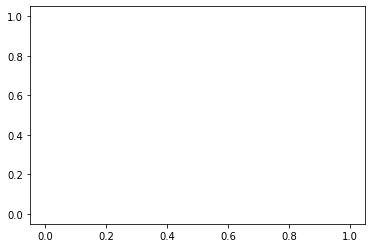

In [10]:
# The output data has ndim + 4 columns. The first ndim columns are just the samples from the parameters, 
#the ndim+1 column is the log-posterior, ndim+2 is the log-likelihood, ndim+3 is the acceptance rate, 
#and ndim+4 is the parallel tempering swap acceptance rate for the T=1 chain.

data = np.loadtxt('chains/chain_1.txt')
chaint = data[:,:-4]

# throw out first 25% of chain as burn in 
burn = int(0.25*chaint.shape[0])
plt.plot(data[burn:,-4])

In [11]:
# get the true values and plot the posteriors for the first 10 parameters
truth = glo.mu
corner.corner(chaint[burn:,:10], bins=50, truths=truth);

ValueError: It looks like the parameter(s) in column(s) 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 have no dynamic range. Please provide a `range` argument.